# Visualizar resultados de las preferencias de TEs en genes codificantes vs zonas intergenicas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import multiprocessing as mp

In [2]:
# A partir del em_per_x hacer un grafico del tamaño de todos los tipos de TE
def process_tes(dataset):
    # Extract lengths and types
    lengths = [(row[2] - row[1], row[6].split("/")[0]) for _, row in dataset.iterrows()]

    # Initialize lists for each TE type
    sine_lengths = []
    line_lengths = []
    ltr_lengths = []
    dna_lengths = []

    # Classify lengths by TE type
    for length, te_type in lengths:
        if te_type == "SINE":
            sine_lengths.append(length)
        elif te_type == "LINE":
            line_lengths.append(length)
        elif te_type == "LTR":
            ltr_lengths.append(length)
        elif te_type == "DNA":
            dna_lengths.append(length)
        elif te_type == "RC":
            dna_lengths.append(length)
        elif te_type == "Retroposon":
            dna_lengths.append(length)
    
    return [sine_lengths, line_lengths, ltr_lengths, dna_lengths]

In [3]:
def feat_len(dataset):
    return [row[2] - row[1] for _, row in dataset.iterrows()]

In [4]:
def occ_report(dataset1, intr_len, length_intergenic, intergenic):
    # dataset1 tiene el arreglo con todos los arreglos de los largos de los elementos moviles
    # intr_len es el largo de todos los intrones codificantes a proteina
    # length_intergenic es el largo de las zonas intergenicas
    # intergenic es el arreglo con arreglo de los tamaños de los elementos moviles en zonas intergenicas

    all_lens = 0
    all_intergenics = 0
    titles = ["SINE", "LINE", "LTR", "DNA"]
    intergenics = []
    intronics = []

    
    for length1, title, length2 in zip(dataset1, titles, intergenic):
        all_lens += sum(length1)
        all_intergenics += sum(length2)

        occ_intr = sum(length1)/intr_len
        occ_intergenic = sum(length2)/length_intergenic

        print(f"Para {title}")
        print(f"Ocupancia en intrones : {occ_intr}")
        print(f"Ocupancia intergenica: {occ_intergenic}")

        intronics.append(occ_intr)
        intergenics.append(occ_intergenic)

    print(f"En total en intrones: {all_lens/intr_len}")
    print(f"En total en intergenica: {all_intergenics/length_intergenic}")

    return(intronics, intergenics)

In [5]:
def t_test(data1, data2, titles):
    # iterativamente ver si las lengths de line/sine etc son estadisticamente diferentes entre si
    for length1, length2, title in zip(data1, data2, titles):
        t_stat, p_value = stats.ttest_ind(length1, length2)

        print(f"\nPara {title}")
        print(f"Promedio 1: {np.mean(length1)}")
        print(f"Promedio 2: {np.mean(length2)}")
        print("Two-sample t-test")
        print(f"t-statistic: {t_stat}")
        print(f"p-value: {p_value}")

        if p_value < 0.05:
            print("Reject the null hypothesis: The means are significantly different.")
        else:
            print("Fail to reject the null hypothesis: The means are not significantly different.")

In [6]:
def graph_data(data, supertitle):
    
    class_lengths = []
    class_freqs = []

    # Create a 2x3 grid of subplots
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs = axs.flatten()

    # Data and titles for subplots
    titles = ["SINE", "LINE", "LTR", "DNA"]

    # Plot each histogram
    for ax, lengths, title in zip(axs, data, titles):
        ax.hist(lengths, bins=30, edgecolor='black')
        n_elements = len(lengths)
        mean_length = sum(lengths) / len(lengths) if lengths else 0

        ax.set_title(f'Lengths of {title} Elements')
        ax.set_xlabel('Length')
        ax.set_ylabel('Frequency')
        ax.legend([f'Mean: {mean_length:.2f} - N: {n_elements}'])

        class_lengths.append(mean_length)
        class_freqs.append(n_elements)

    plt.suptitle(supertitle, fontsize=16)

    plt.tight_layout()
    plt.show()

    return class_lengths, class_freqs

In [7]:
def graph_data_overlapping(data1, data2, supertitle):
    
    class_lengths1 = []
    class_lengths2 = []
    class_freqs1 = []
    class_freqs2 = []

    # Create a 2x3 grid of subplots
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs = axs.flatten()

    # Data and titles for subplots
    titles = ["SINE", "LINE", "LTR", "DNA"]

    # Plot each histogram
    for ax, lengths1, lengths2, title in zip(axs, data1, data2, titles):
        ax.hist(lengths1, bins=30, alpha=0.5, edgecolor='black', label='Data1')  # Histogram for data1
        ax.hist(lengths2, bins=30, alpha=0.5, edgecolor='black', label='Data2')  # Histogram for data2
        
        n_elements1 = len(lengths1)
        n_elements2 = len(lengths2)
        mean_length1 = sum(lengths1) / len(lengths1) if lengths1 else 0
        mean_length2 = sum(lengths2) / len(lengths2) if lengths2 else 0

        ax.set_title(f'Lengths of {title} Elements')
        ax.set_xlabel('Length')
        ax.set_ylabel('Frequency')
        ax.legend([f'Intronic - Mean: {mean_length1:.2f}, N: {n_elements1}', 
                            f'Intergenic - Mean: {mean_length2:.2f}, N: {n_elements2}'])

        class_lengths1.append(mean_length1)
        class_lengths2.append(mean_length2)
        class_freqs1.append(n_elements1)
        class_freqs2.append(n_elements2)

    plt.suptitle(supertitle, fontsize=16)

    plt.tight_layout()
    plt.show()

    return (class_lengths1, class_freqs1), (class_lengths2, class_freqs2)


In [8]:
# Tomar las ocupancias en intrones y zonas intergenicas, calcular la preferencia dividiendo
def pref_intron_inter(occs_intronic, occs_intergenic):
    prefs = []
    for intronic, intergenic in zip(occs_intronic, occs_intergenic):
        try:
            prefs.append(intronic/intergenic)
        except:
            prefs.append(None)
    print(prefs)
    return prefs


In [9]:
def df_per_chr(occs_per_chr):
    data = []
    for key in occs_per_chr.keys():
        data.append(occs_per_chr[key])
    intronic_chr = pd.DataFrame(data=data, columns=titles, index=occs_per_chr.keys())
    return intronic_chr

In [10]:
def df_pref_per_chr(occs_per_chr_intronic, occs_per_chr_intergenic):
    data = []
    for key1, key2 in zip(occs_per_chr_intronic, occs_per_chr_intergenic):
        data.append([val1/val2 if val2 != 0 else None for val1, val2 in zip(occs_per_chr_intronic[key1], occs_per_chr_intergenic[key2])])
    pref_chr = pd.DataFrame(data=data, columns=titles, index=occs_per_chr_intergenic.keys())
    return pref_chr

In [11]:
def count_genes_per_chr(chr_name, df, chr_col_index):
    return chr_name, df[df[chr_col_index] == chr_name].shape[0]

def parallel_gene_count(chr_lengths, df, chr_col_index=0):
    with mp.Pool(mp.cpu_count()) as pool:
        # Use pool.starmap to pass multiple arguments to the function
        results = pool.starmap(count_genes_per_chr, [(chr_name, df, chr_col_index) for chr_name in chr_lengths.keys()])
    
    # Convert the results into a dictionary
    return dict(results)

In [12]:
def min_max_normalize(data):
    min_val = min(data)
    max_val = max(data)
    
    # Handle the case where all values are the same (avoid division by zero)
    if min_val == max_val:
        return [0.0 for _ in data]
    
    return [(x - min_val) / (max_val - min_val) for x in data]

In [13]:
titles = ["SINE", "LINE", "LTR", "DNA"]

## En Mus Musculus

In [14]:
# Cargar datos para mus musculus
mm_pcgenes_df = pd.read_csv("results_rmodelers/mus_musculus/em_per_gene.bed", sep="\t", header=None)
m_musculus_pcgenes = process_tes(mm_pcgenes_df)

mm_introns_df = pd.read_csv("results_rmodelers/mus_musculus/em_per_intron.bed", sep="\t", header=None)
m_musculus_introns = process_tes(mm_introns_df)

mm_intergenic_df = pd.read_csv("results_rmodelers/mus_musculus/em_intergenic.bed", sep="\t", header=None)
m_musculus_intergenic = process_tes(mm_intergenic_df)

mm_fullintron_df = pd.read_csv("results_rmodelers/mus_musculus/introns.bed", sep="\t", header=None)
m_musculus_fullintron = sum(feat_len(mm_fullintron_df))

mm_fullgene_df = pd.read_csv("results_rmodelers/mus_musculus/genes.bed", sep="\t", header=None)
m_musculus_fullgene = sum(feat_len(mm_fullgene_df))

#mm_occs_intronic, mm_occs_intergenic = occ_report(m_musculus_introns, m_musculus_fullintron, m_musculus_intergenic_size, m_musculus_intergenic)


In [15]:
mm_chr_lengths = {"NC_000067.7": 195154279,
                    "NC_000068.8":181755017,
                    "NC_000069.7":159745316,
                    "NC_000070.7":156860686,
                    "NC_000071.7":151758149,
                    "NC_000072.7":149588044,
                    "NC_000073.7":144995196,
                    "NC_000074.7":130127694,
                    "NC_000075.7":124359700,
                    "NC_000076.7":130530862,
                    "NC_000077.7":121973369,
                    "NC_000078.7":120092757,
                    "NC_000079.7":120883175,
                    "NC_000080.7":125139656,
                    "NC_000081.7":104073951,
                    "NC_000082.7":98008968,
                    "NC_000083.7":95294699,
                    "NC_000084.7":90720763,
                    "NC_000085.7":61420004,
                    "NC_000086.8":169476592,
                    "NC_000087.8":91455967,
                    "NC_005089.1":16299,}

In [16]:
mm_genes_per_chr = parallel_gene_count(mm_chr_lengths, mm_fullgene_df, chr_col_index=0)

In [17]:
mm_genes_per_chr

{'NC_000067.7': 2366,
 'NC_000068.8': 3094,
 'NC_000069.7': 1977,
 'NC_000070.7': 2361,
 'NC_000071.7': 2292,
 'NC_000072.7': 2125,
 'NC_000073.7': 3226,
 'NC_000074.7': 2054,
 'NC_000075.7': 2120,
 'NC_000076.7': 1914,
 'NC_000077.7': 2697,
 'NC_000078.7': 1522,
 'NC_000079.7': 1820,
 'NC_000080.7': 1639,
 'NC_000081.7': 1516,
 'NC_000082.7': 1268,
 'NC_000083.7': 1726,
 'NC_000084.7': 1079,
 'NC_000085.7': 1153,
 'NC_000086.8': 1544,
 'NC_000087.8': 300,
 'NC_005089.1': 37}

In [18]:
mm_introns_per_chr = parallel_gene_count(mm_chr_lengths, mm_fullintron_df, chr_col_index=0)

In [19]:
mm_introns_per_chr

{'NC_000067.7': 17819,
 'NC_000068.8': 21734,
 'NC_000069.7': 12457,
 'NC_000070.7': 16336,
 'NC_000071.7': 17164,
 'NC_000072.7': 13594,
 'NC_000073.7': 19113,
 'NC_000074.7': 13500,
 'NC_000075.7': 15430,
 'NC_000076.7': 12830,
 'NC_000077.7': 19574,
 'NC_000078.7': 9643,
 'NC_000079.7': 9749,
 'NC_000080.7': 11234,
 'NC_000081.7': 10924,
 'NC_000082.7': 8078,
 'NC_000083.7': 11795,
 'NC_000084.7': 7642,
 'NC_000085.7': 8272,
 'NC_000086.8': 9155,
 'NC_000087.8': 763,
 'NC_005089.1': 0}

In [20]:
m_musculus_size = sum([len for len in mm_chr_lengths.values()])
m_musculus_intergenic_size = m_musculus_size-m_musculus_fullintron

In [21]:
#graph_data(m_musculus_pcgenes, "Mus musculus, pc_genes")

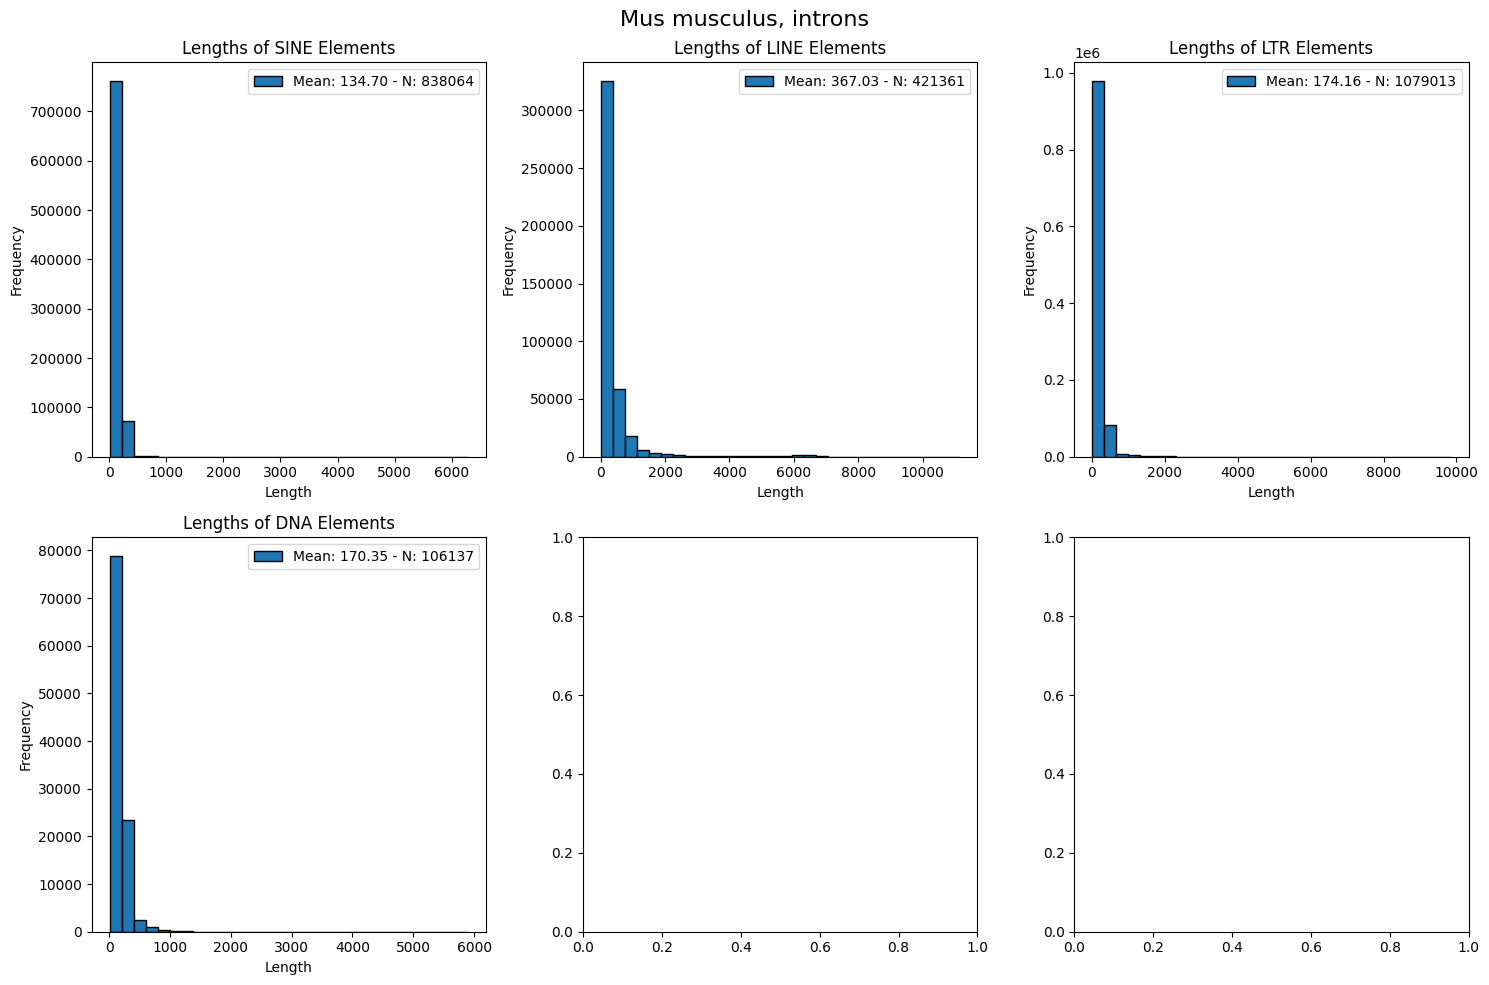

In [22]:
mm_intronic_lengths, mm_intronic_freqs = graph_data(m_musculus_introns, "Mus musculus, introns")

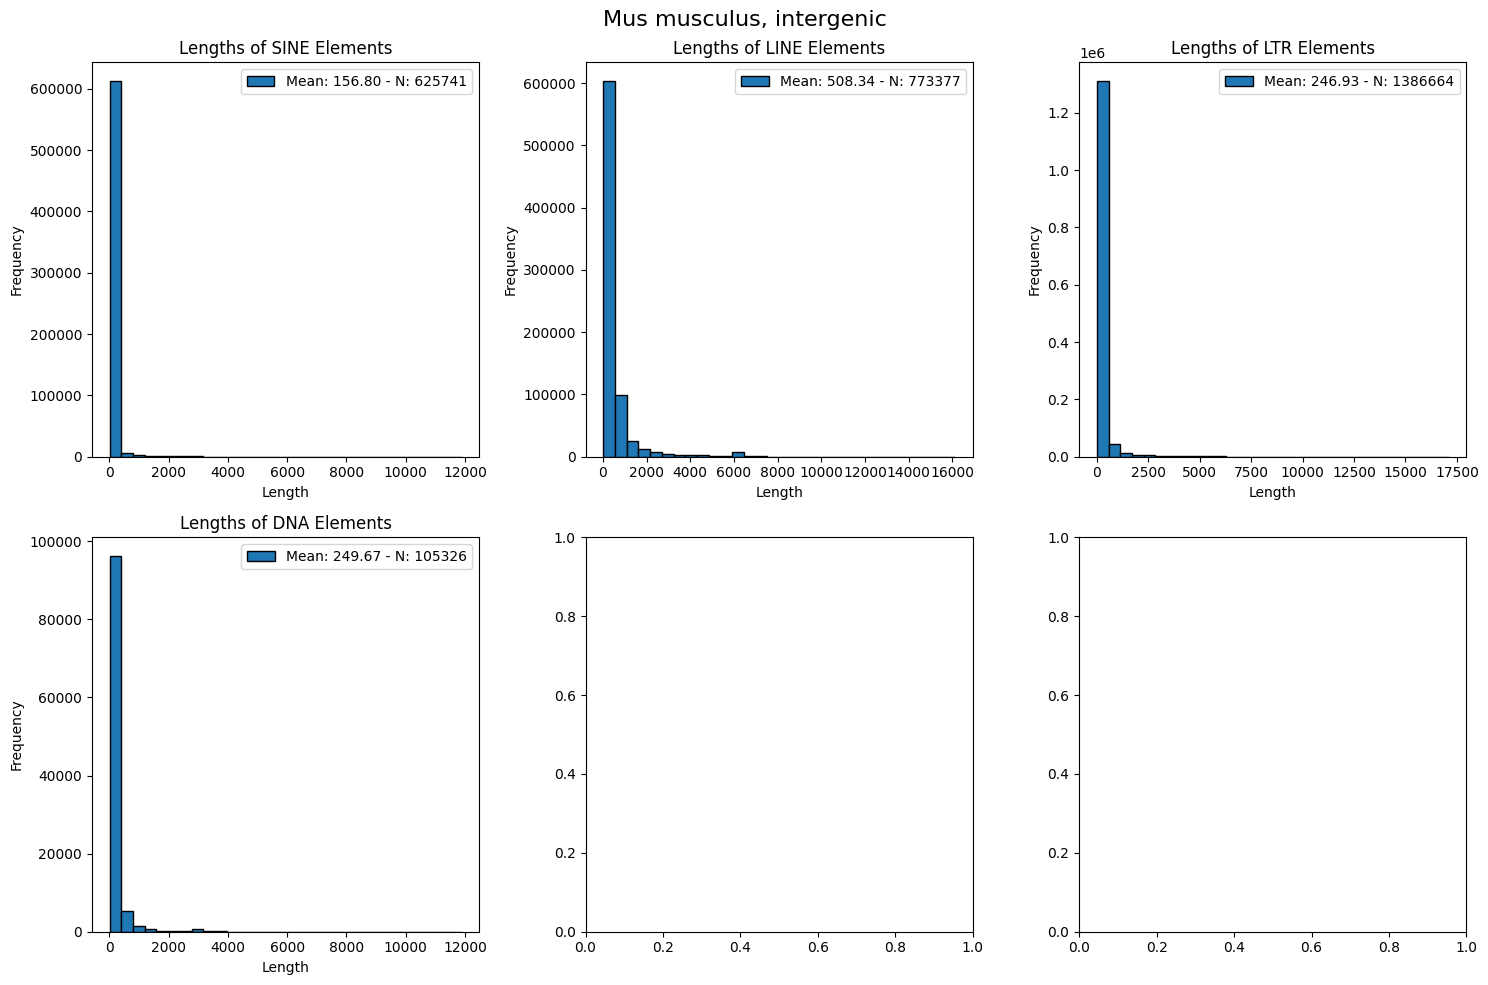

In [23]:
mm_intergenic_lengths, mm_intergenic_freqs = graph_data(m_musculus_intergenic, "Mus musculus, intergenic")

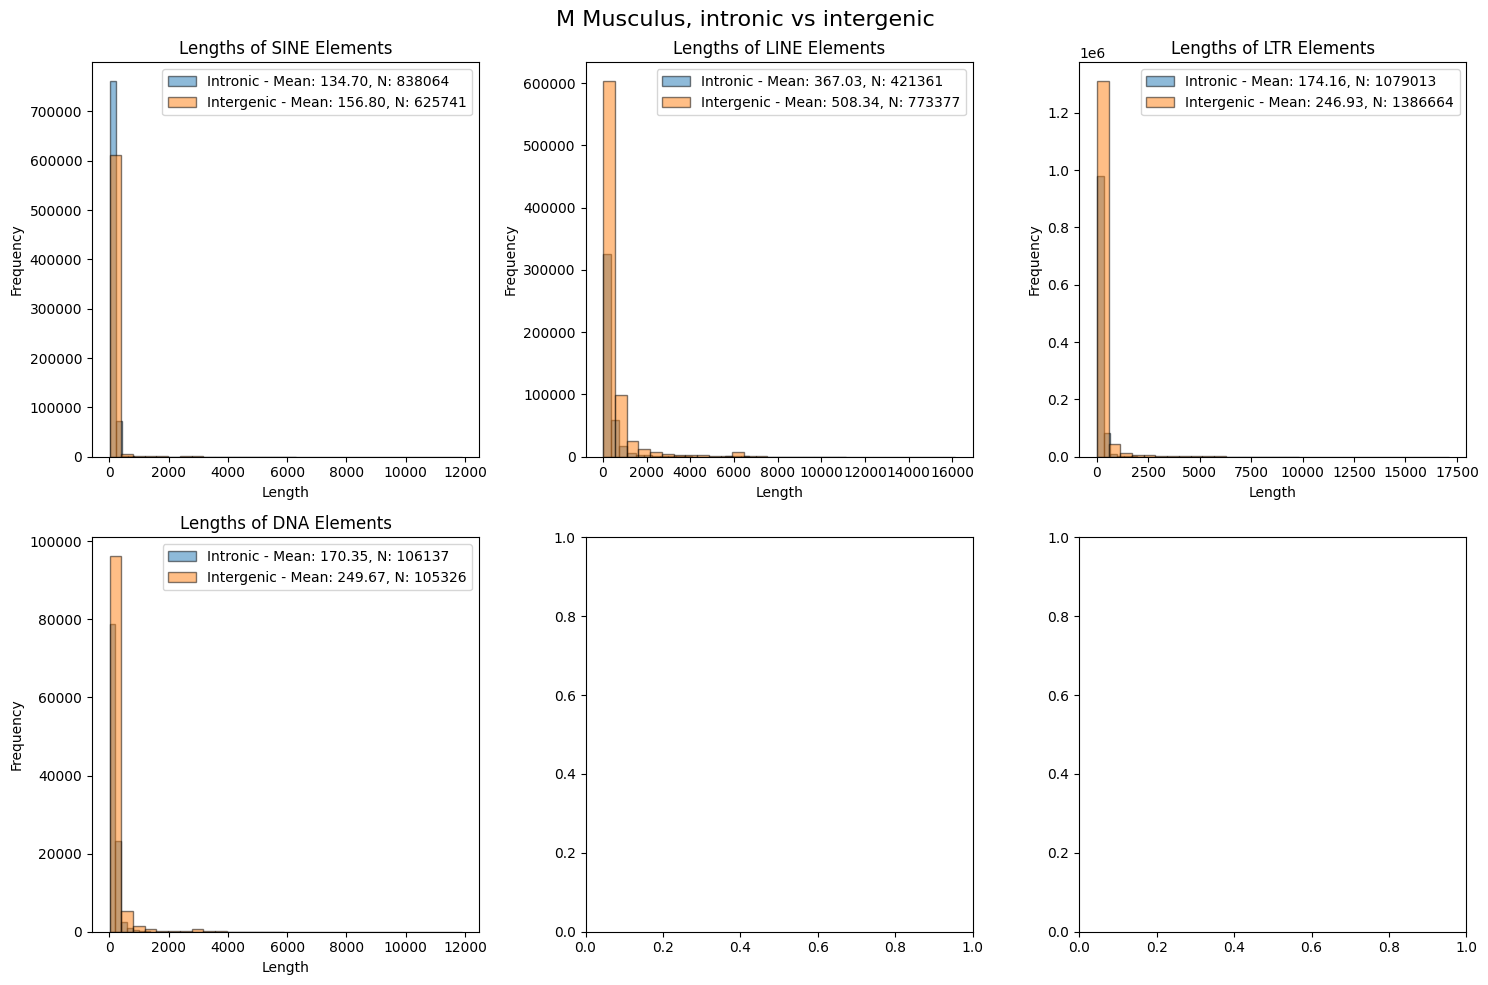

(([134.7004560510892,
   367.0349201753366,
   174.16480987717478,
   170.34756022876095],
  [838064, 421361, 1079013, 106137]),
 ([156.7954696911342,
   508.34458743924375,
   246.93276381300734,
   249.6703662913241],
  [625741, 773377, 1386664, 105326]))

In [24]:
graph_data_overlapping(m_musculus_introns, m_musculus_intergenic, "M Musculus, intronic vs intergenic")

In [25]:
t_test(m_musculus_introns, m_musculus_intergenic, titles)


Para SINE
Promedio 1: 134.7004560510892
Promedio 2: 156.7954696911342
Two-sample t-test
t-statistic: -73.82175859484538
p-value: 0.0
Reject the null hypothesis: The means are significantly different.

Para LINE
Promedio 1: 367.0349201753366
Promedio 2: 508.34458743924375
Two-sample t-test
t-statistic: -86.03737683294514
p-value: 0.0
Reject the null hypothesis: The means are significantly different.

Para LTR
Promedio 1: 174.16480987717478
Promedio 2: 246.93276381300734
Two-sample t-test
t-statistic: -144.20896178008798
p-value: 0.0
Reject the null hypothesis: The means are significantly different.

Para DNA
Promedio 1: 170.34756022876095
Promedio 2: 249.6703662913241
Two-sample t-test
t-statistic: -48.35794501620713
p-value: 0.0
Reject the null hypothesis: The means are significantly different.


In [26]:
mm_occs_intronic, mm_occs_intergenic = occ_report(m_musculus_introns, m_musculus_fullintron, m_musculus_intergenic_size, m_musculus_intergenic)

Para SINE
Ocupancia en intrones : 0.0977775721846171
Ocupancia intergenica: 0.06253654049404506
Para LINE
Ocupancia en intrones : 0.1339537017358034
Ocupancia intergenica: 0.25058506667041824
Para LTR
Ocupancia en intrones : 0.16277214444404617
Ocupancia intergenica: 0.21825072157791384
Para DNA
Ocupancia en intrones : 0.01566014301218973
Ocupancia intergenica: 0.01676132394647863
En total en intrones: 0.41016356137665644
En total en intergenica: 0.5481336526888558


Cromosoma a cromosoma

In [27]:
mm_occs_per_chr_intronic = {}
mm_occs_per_chr_intergenic = {}
mm_freqs_per_chr_intronic = {}
mm_freqs_per_chr_intergenic = {}

for chr in mm_chr_lengths.keys():
    print(f"Para {chr}")
    df_chr_intron = process_tes(mm_introns_df[mm_introns_df[0]==chr])
    df_chr_intergenic = process_tes(mm_intergenic_df[mm_intergenic_df[0]==chr])
    df_chr_fullintron = sum(feat_len(mm_fullintron_df[mm_fullintron_df[0]==chr]))
    if df_chr_fullintron == 0:
        continue

    mini_intergenic_size = mm_chr_lengths[chr] - df_chr_fullintron

    mm_occs_per_chr_intronic[chr], mm_occs_per_chr_intergenic[chr] = occ_report(df_chr_intron, df_chr_fullintron, mini_intergenic_size, df_chr_intergenic)
    
    mm_freqs_per_chr_intronic[chr] = [len(el) for el in df_chr_intron]
    mm_freqs_per_chr_intergenic[chr] = [len(el) for el in df_chr_intergenic]

    print("\n")

Para NC_000067.7
Para SINE
Ocupancia en intrones : 0.08671700841535097
Ocupancia intergenica: 0.055525013501986686
Para LINE
Ocupancia en intrones : 0.14249522102314643
Ocupancia intergenica: 0.24957569537740162
Para LTR
Ocupancia en intrones : 0.1588693770192909
Ocupancia intergenica: 0.20233851394357288
Para DNA
Ocupancia en intrones : 0.015459227642208384
Ocupancia intergenica: 0.012921620973012367
En total en intrones: 0.4035408340999967
En total en intergenica: 0.5203608437959736


Para NC_000068.8
Para SINE
Ocupancia en intrones : 0.09850207899293471
Ocupancia intergenica: 0.0609281136399933
Para LINE
Ocupancia en intrones : 0.12264744462389722
Ocupancia intergenica: 0.21675979341413507
Para LTR
Ocupancia en intrones : 0.15853454735867822
Ocupancia intergenica: 0.18603249416863613
Para DNA
Ocupancia en intrones : 0.016138449620572114
Ocupancia intergenica: 0.013289370080781451
En total en intrones: 0.39582252059608225
En total en intergenica: 0.47700977130354594


Para NC_000069.

Preferencias en intrones vs intergenica, nivel genoma completo

In [28]:
mm_prefs = pref_intron_inter(mm_occs_intronic, mm_occs_intergenic)

[1.5635270421447094, 0.5345637851276503, 0.745803465240493, 0.9343022700470958]


## En Homo Sapiens

In [29]:
# Cargar datos para homo sapiens
hs_pcgenes_df = pd.read_csv("results_rmodelers/homo_sapiens/em_per_gene.bed", sep="\t", header=None)
homo_sapiens_pcgenes = process_tes(hs_pcgenes_df)

hs_introns_df = pd.read_csv("results_rmodelers/homo_sapiens/em_per_intron.bed", sep="\t", header=None)
homo_sapiens_introns = process_tes(hs_introns_df)

hs_intergenic_df = pd.read_csv("results_rmodelers/homo_sapiens/em_intergenic.bed", sep="\t", header=None)
homo_sapiens_intergenic = process_tes(hs_intergenic_df)

hs_fullintron_df = pd.read_csv("results_rmodelers/homo_sapiens/introns.bed", sep="\t", header=None)
homo_sapiens_fullintron = sum(feat_len(hs_fullintron_df))

hs_fullgene_df = pd.read_csv("results_rmodelers/homo_sapiens/genes.bed", sep="\t", header=None)
h_sapiens_fullgene = sum(feat_len(hs_fullgene_df))

In [30]:
hs_chr_lengths = {"NC_000001.11":248956422,
                    "NC_000002.12":242193529,
                    "NC_000003.12":198295559,
                    "NC_000004.12":190214555,
                    "NC_000005.10":181538259,
                    "NC_000006.12":170805979,
                    "NC_000007.14":159345973,
                    "NC_000008.11":145138636,
                    "NC_000009.12":138394717,
                    "NC_000010.11":133797422,
                    "NC_000011.10":135086622,
                    "NC_000012.12":133275309,
                    "NC_000013.11":114364328,
                    "NC_000014.9":107043718,
                    "NC_000015.10":101991189,
                    "NC_000016.10":90338345,
                    "NC_000017.11":83257441,
                    "NC_000018.10":80373285,
                    "NC_000019.10":58617616,
                    "NC_000020.11":64444167,
                    "NC_000021.9":46709983,
                    "NC_000022.11":50818468,
                    "NC_000023.11":156040895,
                    "NC_000024.10":57227415,
                    "NC_012920.1":16569,
                    }
homo_sapiens_size = sum([len for len in hs_chr_lengths.values()])

In [31]:
#graph_data(homo_sapiens_pcgenes, "Human, pc_genes")

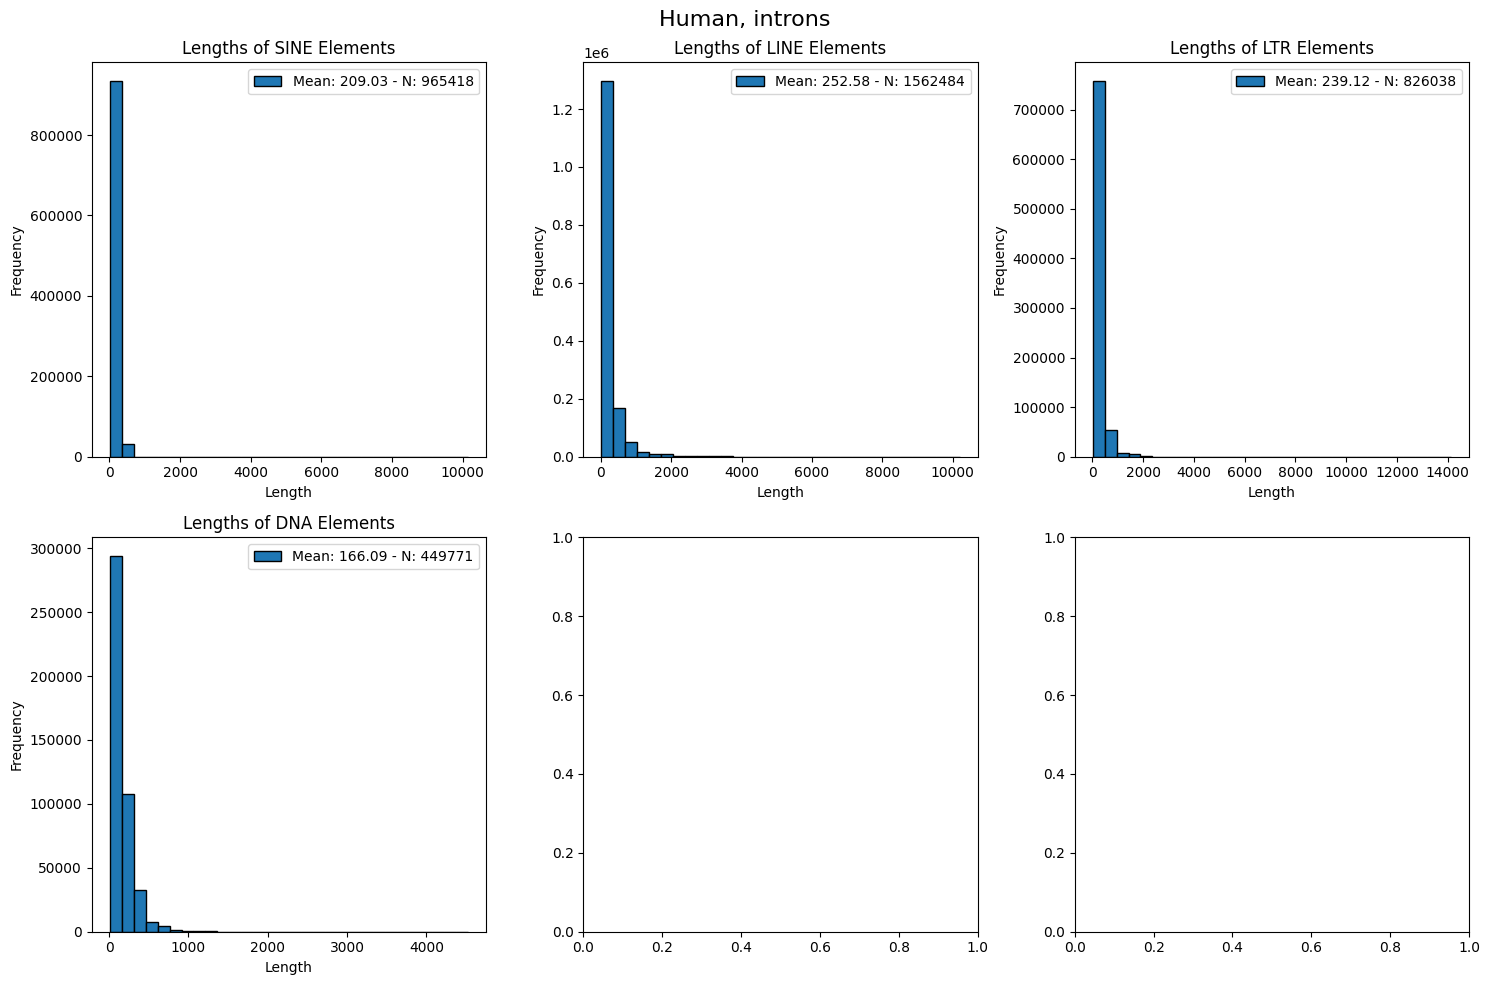

In [32]:
hs_intronic_lengths, hs_intronic_freqs = graph_data(homo_sapiens_introns, "Human, introns")

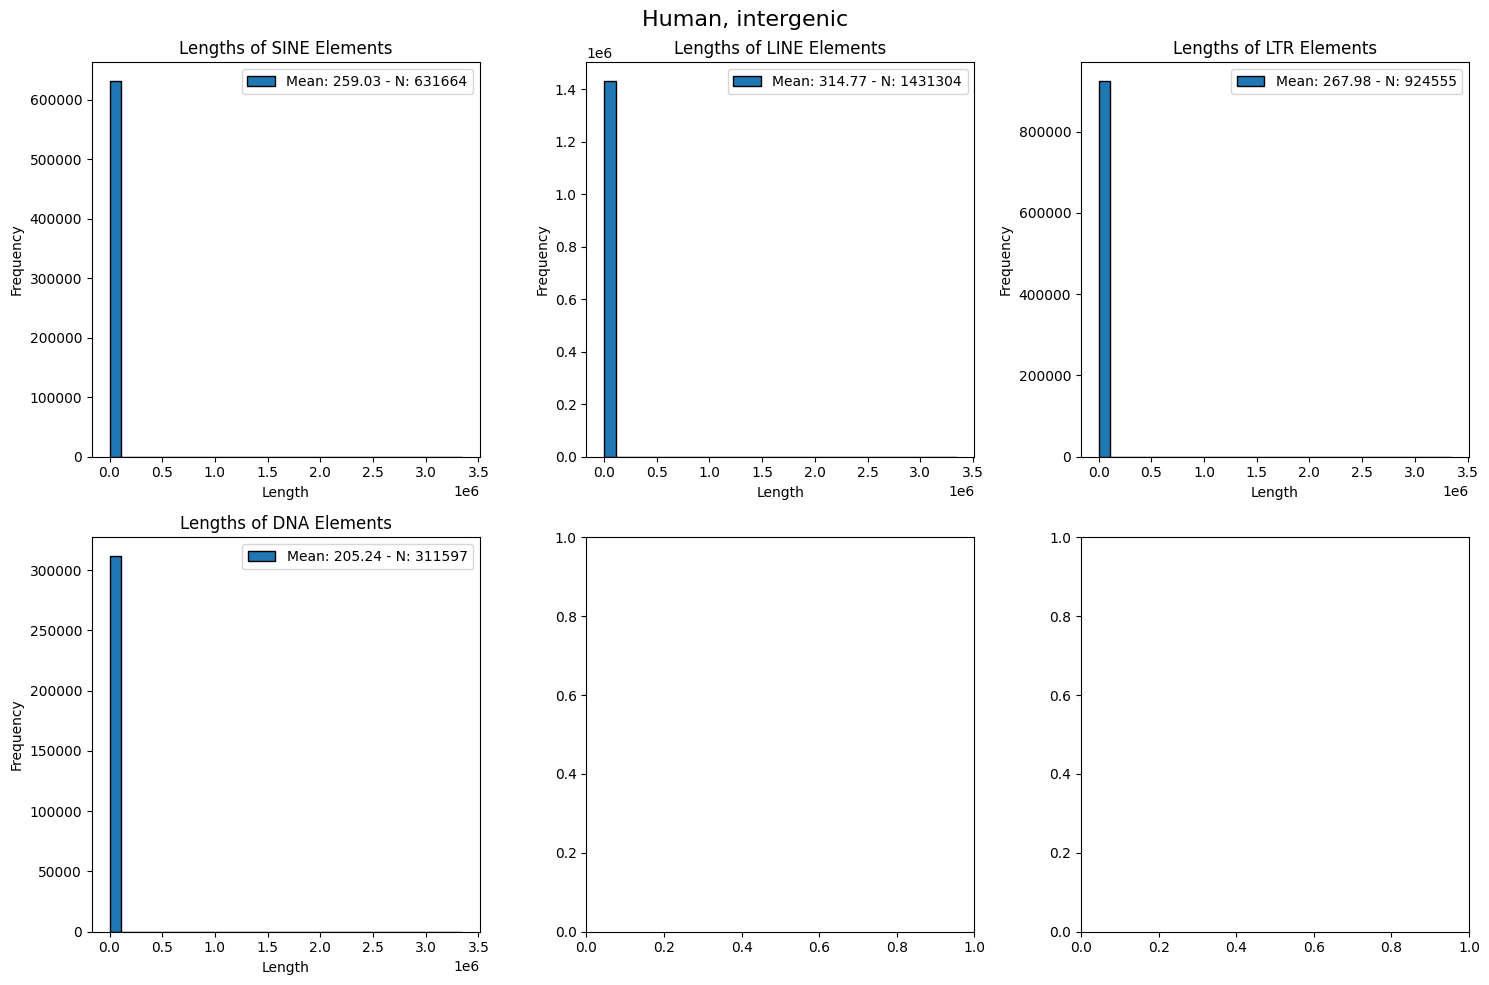

In [33]:
hs_intergenic_lengths, hs_intergenic_freqs = graph_data(homo_sapiens_intergenic, "Human, intergenic")

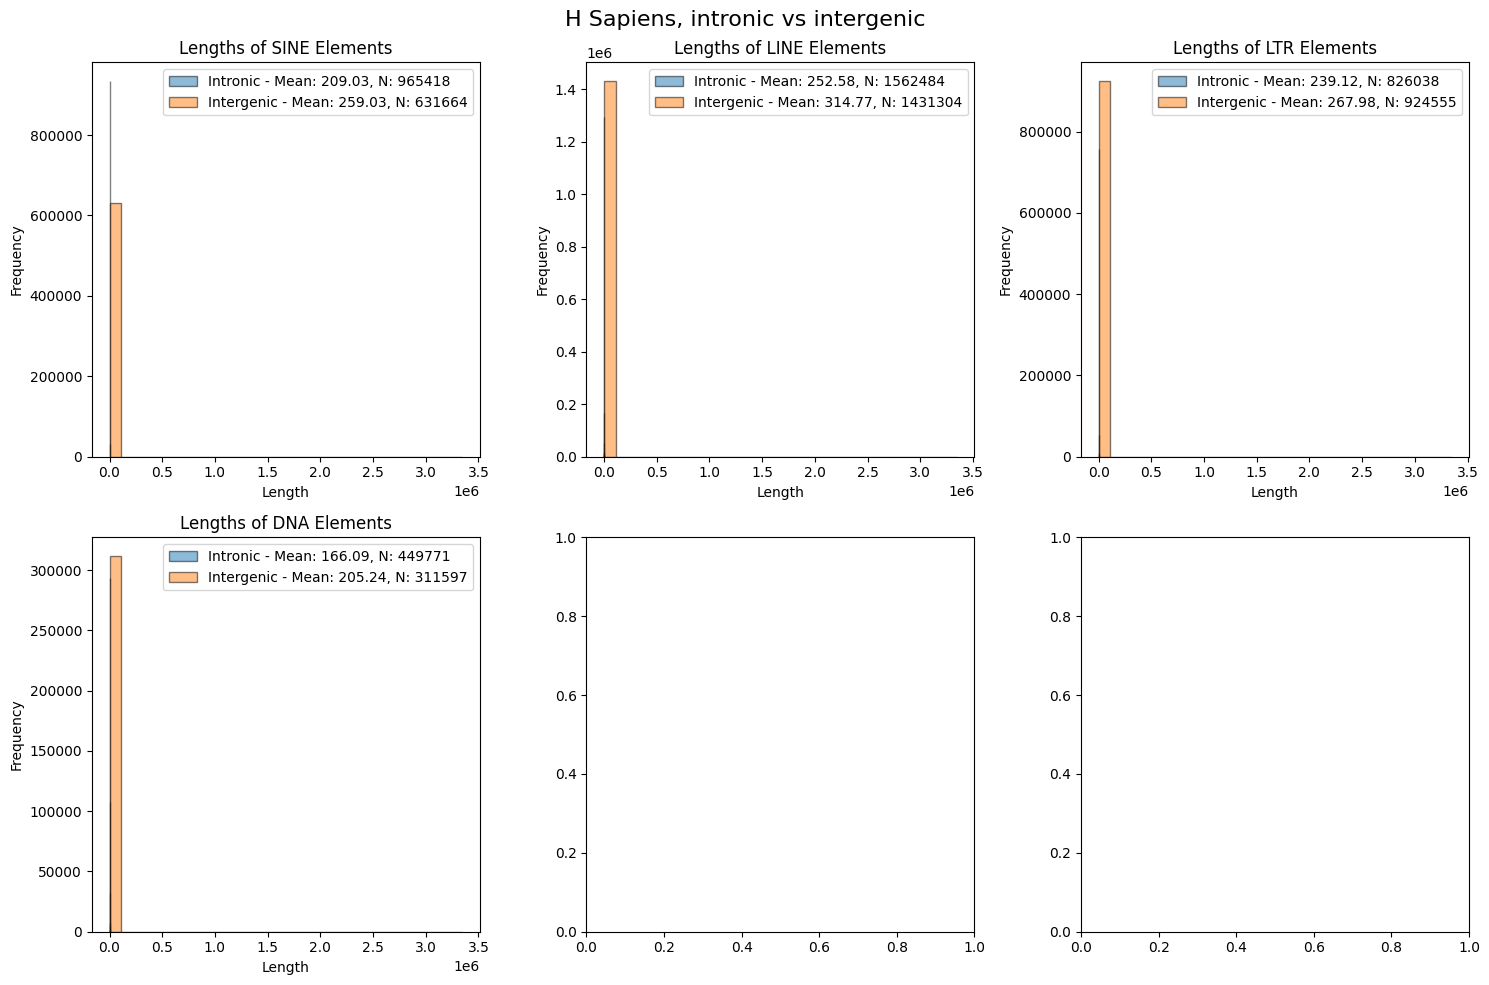

(([209.02962343772336,
   252.58083666776747,
   239.12321467051152,
   166.09058832161256],
  [965418, 1562484, 826038, 449771]),
 ([259.0259679196535,
   314.77443855393403,
   267.98247805701124,
   205.24002156631803],
  [631664, 1431304, 924555, 311597]))

In [34]:
graph_data_overlapping(homo_sapiens_introns, homo_sapiens_intergenic, "H Sapiens, intronic vs intergenic")

In [35]:
hs_occs_intronic, hs_occs_intergenic = occ_report(homo_sapiens_introns, homo_sapiens_fullintron, homo_sapiens_size, homo_sapiens_intergenic)

Para SINE
Ocupancia en intrones : 0.1199468988216386
Ocupancia intergenica: 0.05297998882066767
Para LINE
Ocupancia en intrones : 0.23457502441356526
Ocupancia intergenica: 0.14588605281366196
Para LTR
Ocupancia en intrones : 0.117405261697798
Ocupancia intergenica: 0.08022719004292245
Para DNA
Ocupancia en intrones : 0.044401972877672204
Ocupancia intergenica: 0.020707980639131145
En total en intrones: 0.516329157810674
En total en intergenica: 0.29980121231638324


In [36]:
t_test(homo_sapiens_introns, homo_sapiens_intergenic, titles)


Para SINE
Promedio 1: 209.02962343772336
Promedio 2: 259.0259679196535
Two-sample t-test
t-statistic: -5.006925676615632
p-value: 5.531213863055932e-07
Reject the null hypothesis: The means are significantly different.

Para LINE
Promedio 1: 252.58083666776747
Promedio 2: 314.77443855393403
Two-sample t-test
t-statistic: -11.286773667076904
p-value: 1.5274348776764695e-29
Reject the null hypothesis: The means are significantly different.

Para LTR
Promedio 1: 239.12321467051152
Promedio 2: 267.98247805701124
Two-sample t-test
t-statistic: -6.304467713720587
p-value: 2.892544927435372e-10
Reject the null hypothesis: The means are significantly different.

Para DNA
Promedio 1: 166.09058832161256
Promedio 2: 205.24002156631803
Two-sample t-test
t-statistic: -2.9345409023961535
p-value: 0.0033405149271513975
Reject the null hypothesis: The means are significantly different.


Cromosoma a cromosoma

In [37]:
hs_occs_per_chr_intronic = {}
hs_occs_per_chr_intergenic = {}
hs_freqs_per_chr_intronic = {}
hs_freqs_per_chr_intergenic = {}

for chr in hs_chr_lengths.keys():
    print(f"Para {chr}")
    df_chr_intron = process_tes(hs_introns_df[hs_introns_df[0]==chr])
    df_chr_intergenic = process_tes(hs_intergenic_df[hs_intergenic_df[0]==chr])
    df_chr_fullintron = sum(feat_len(hs_fullintron_df[hs_fullintron_df[0]==chr]))
    if df_chr_fullintron == 0:
        continue

    mini_intergenic_size = hs_chr_lengths[chr] - df_chr_fullintron

    hs_occs_per_chr_intronic[chr], hs_occs_per_chr_intergenic[chr] = occ_report(df_chr_intron, df_chr_fullintron, mini_intergenic_size, df_chr_intergenic)

    hs_freqs_per_chr_intronic[chr] = [len(el) for el in df_chr_intron]
    hs_freqs_per_chr_intergenic[chr] = [len(el) for el in df_chr_intergenic]

    print("\n")

Para NC_000001.11
Para SINE
Ocupancia en intrones : 0.12791783655100142
Ocupancia intergenica: 0.10483831271456988
Para LINE
Ocupancia en intrones : 0.24115895499681356
Ocupancia intergenica: 0.23321771976241243
Para LTR
Ocupancia en intrones : 0.12214525518888647
Ocupancia intergenica: 0.13356418774062787
Para DNA
Ocupancia en intrones : 0.04371305533235212
Ocupancia intergenica: 0.0326269993530726
En total en intrones: 0.5349351020690536
En total en intergenica: 0.5042472195706827


Para NC_000002.12
Para SINE
Ocupancia en intrones : 0.10245113880095405
Ocupancia intergenica: 0.10016953183867858
Para LINE
Ocupancia en intrones : 0.23516374735389242
Ocupancia intergenica: 0.2725004799091327
Para LTR
Ocupancia en intrones : 0.11236412203322846
Ocupancia intergenica: 0.1443250621718581
Para DNA
Ocupancia en intrones : 0.04671330024141991
Ocupancia intergenica: 0.04084997353573443
En total en intrones: 0.49669230842949486
En total en intergenica: 0.5578450474554038


Para NC_000003.12
Pa

In [38]:
hs_prefs = pref_intron_inter(hs_occs_intronic, hs_occs_intergenic)

[2.2640038529952826, 1.6079331772255459, 1.463409869334634, 2.1441961749649]


## En A. Thaliana

In [39]:
# Cargar datos para a thaliana

at_pcgenes_df = pd.read_csv("results/a_thaliana/em_per_gene.bed", sep="\t", header=None)
a_thaliana_pcgenes = process_tes(at_pcgenes_df)

at_introns_df = pd.read_csv("results/a_thaliana/em_per_intron.bed", sep="\t", header=None)
a_thaliana_introns = process_tes(at_introns_df)

at_intergenic_df = pd.read_csv("results/a_thaliana/em_intergenic.bed", sep="\t", header=None)
a_thaliana_intergenic = process_tes(at_intergenic_df)

at_fullintron_df = pd.read_csv("results/a_thaliana/introns.bed", sep="\t", header=None)
a_thaliana_fullintron = sum(feat_len(at_fullintron_df))

at_fullgene_df = pd.read_csv("results/a_thaliana/genes.bed", sep="\t", header=None)
a_thaliana_fullgene = sum(feat_len(at_fullgene_df))

In [40]:
at_chr_lengths = {"NC_003070.9":30427671,
                    "NC_003071.7":19698289,
                    "NC_003074.8":23459830,
                    "NC_003075.7":18585056,
                    "NC_003076.8":26975502,
                    "NC_037304.1":367808,
                    "NC_000932.1":154478,}
a_thaliana_size = sum([len for len in at_chr_lengths.values()])

In [41]:
#graph_data(a_thaliana_pcgenes, "A thaliana, pcgenes")

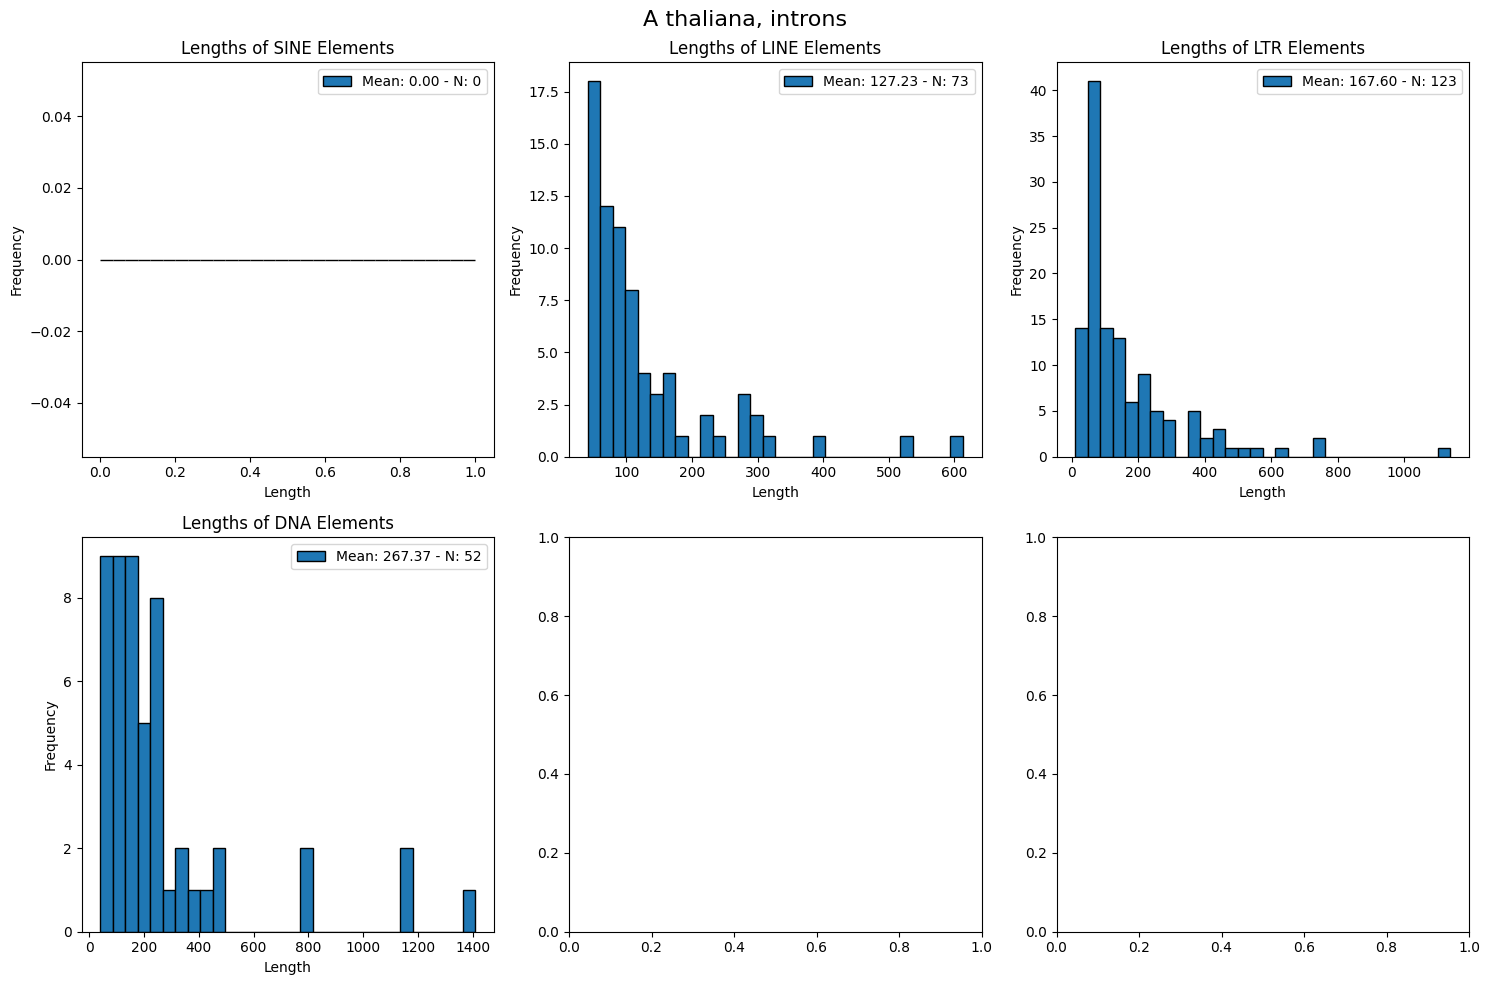

In [42]:
at_intronic_lengths, at_intronic_freqs = graph_data(a_thaliana_introns, "A thaliana, introns")

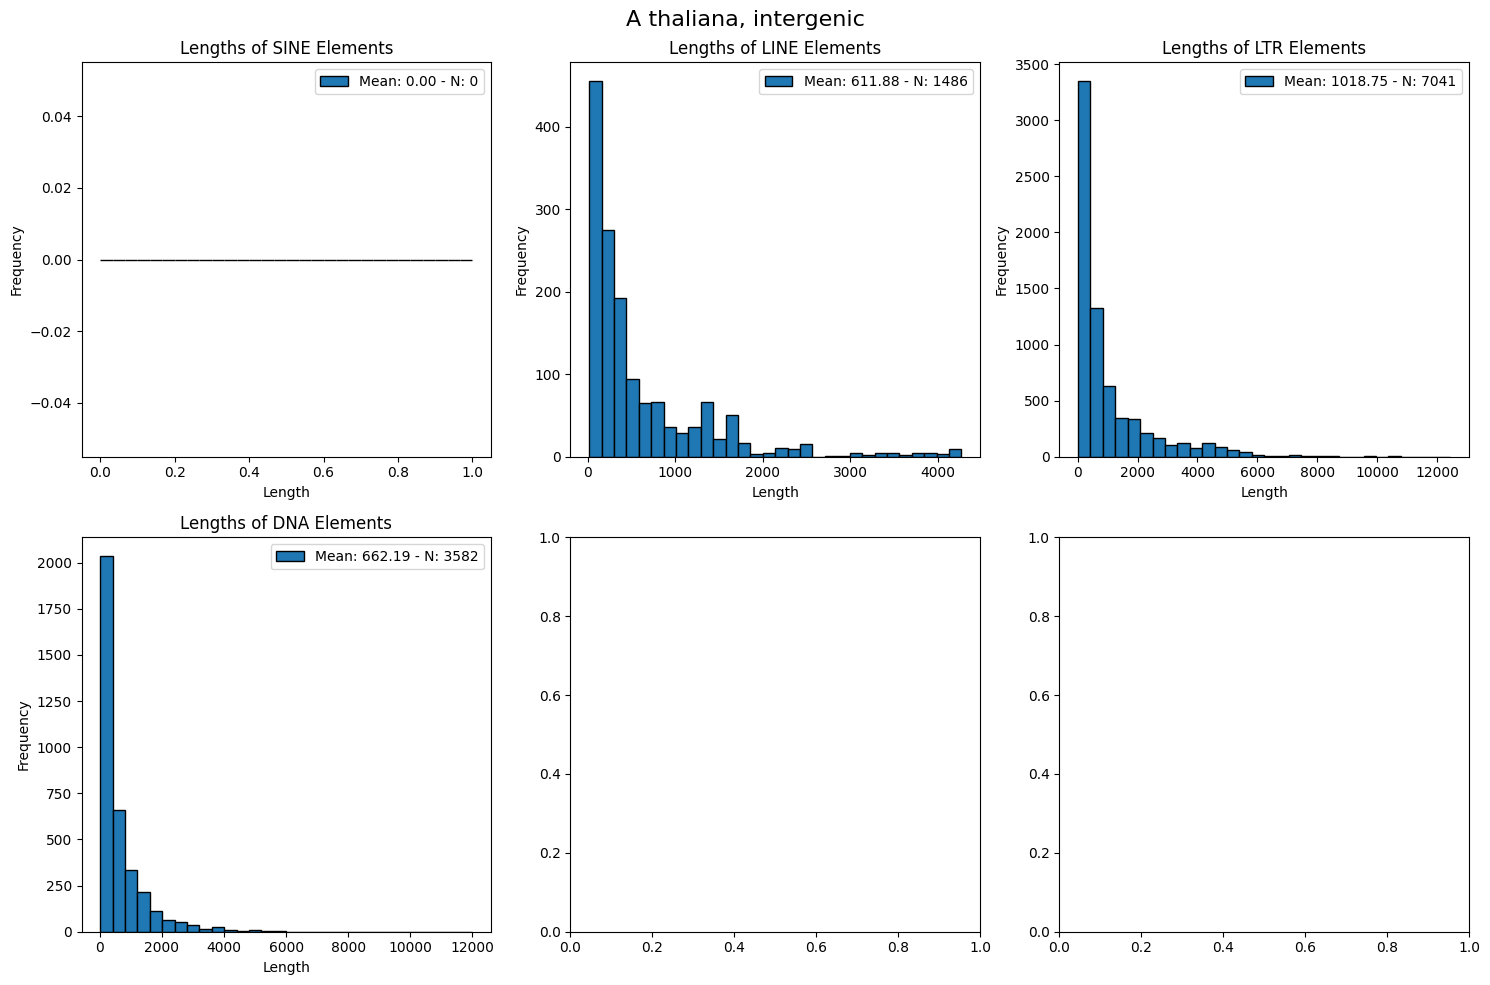

In [43]:
at_intergenic_lengths, at_intergenic_freqs = graph_data(a_thaliana_intergenic, "A thaliana, intergenic")

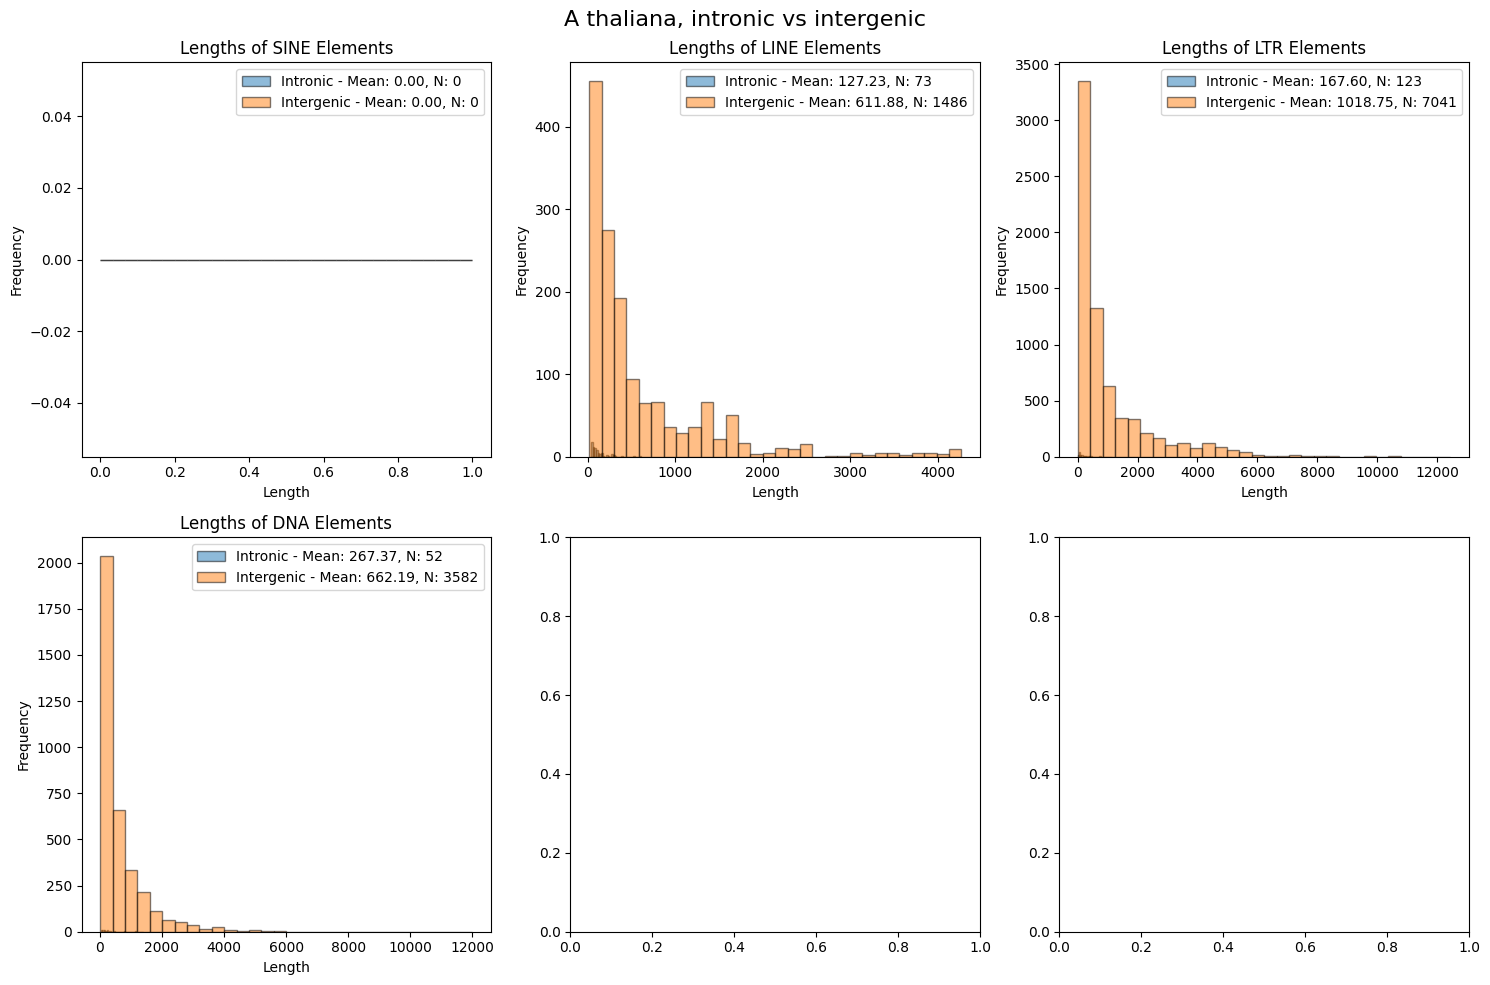

(([0, 127.23287671232876, 167.60162601626016, 267.36538461538464],
  [0, 73, 123, 52]),
 ([0, 611.8808882907133, 1018.7462008237467, 662.1926298157454],
  [0, 1486, 7041, 3582]))

In [44]:
graph_data_overlapping(a_thaliana_introns, a_thaliana_intergenic, "A thaliana, intronic vs intergenic")

In [45]:
at_occs_intronic, at_occs_intergenic = occ_report(a_thaliana_introns, a_thaliana_fullintron, a_thaliana_size, a_thaliana_intergenic)

Para SINE
Ocupancia en intrones : 0.0
Ocupancia intergenica: 0.0
Para LINE
Ocupancia en intrones : 0.0005061344277345972
Ocupancia intergenica: 0.007598106284057693
Para LTR
Ocupancia en intrones : 0.001123380838474238
Ocupancia intergenica: 0.05994045189819749
Para DNA
Ocupancia en intrones : 0.0007576213338494946
Ocupancia intergenica: 0.019821183886832034
En total en intrones: 0.0023871366000583296
En total en intergenica: 0.08735974206908721


In [46]:
t_test(a_thaliana_introns, a_thaliana_intergenic, titles)


Para SINE
Promedio 1: nan
Promedio 2: nan
Two-sample t-test
t-statistic: nan
p-value: nan
Fail to reject the null hypothesis: The means are not significantly different.

Para LINE
Promedio 1: 127.23287671232876
Promedio 2: 611.8808882907133
Two-sample t-test
t-statistic: -5.472793832291473
p-value: 5.1552224040146585e-08
Reject the null hypothesis: The means are significantly different.

Para LTR
Promedio 1: 167.60162601626016
Promedio 2: 1018.7462008237467
Two-sample t-test
t-statistic: -6.9426597816481825
p-value: 4.185286100303396e-12
Reject the null hypothesis: The means are significantly different.

Para DNA
Promedio 1: 267.36538461538464
Promedio 2: 662.1926298157454
Two-sample t-test
t-statistic: -3.3018692459999572
p-value: 0.0009697172569304798
Reject the null hypothesis: The means are significantly different.


/home/seba/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/seba/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Cromosoma a cromosoma

In [47]:
at_occs_per_chr_intronic = {}
at_occs_per_chr_intergenic = {}
at_freqs_per_chr_intronic = {}
at_freqs_per_chr_intergenic = {}

for chr in at_chr_lengths.keys():
    print(f"Para {chr}")
    df_chr_intron = process_tes(at_introns_df[at_introns_df[0]==chr])
    df_chr_intergenic = process_tes(at_intergenic_df[at_intergenic_df[0]==chr])
    df_chr_fullintron = sum(feat_len(at_fullintron_df[at_fullintron_df[0]==chr]))
    if df_chr_fullintron == 0:
        continue

    mini_intergenic_size = at_chr_lengths[chr] - df_chr_fullintron

    at_occs_per_chr_intronic[chr], at_occs_per_chr_intergenic[chr] = occ_report(df_chr_intron, df_chr_fullintron, mini_intergenic_size, df_chr_intergenic)

    at_freqs_per_chr_intronic[chr] = [len(el) for el in df_chr_intron]
    at_freqs_per_chr_intergenic[chr] = [len(el) for el in df_chr_intergenic]

    print("\n")

Para NC_003070.9
Para SINE
Ocupancia en intrones : 0.0
Ocupancia intergenica: 0.0
Para LINE
Ocupancia en intrones : 0.0006094385544763088
Ocupancia intergenica: 0.006317001032624366
Para LTR
Ocupancia en intrones : 0.0014485147003811699
Ocupancia intergenica: 0.05236160636340372
Para DNA
Ocupancia en intrones : 0.0010525737286831856
Ocupancia intergenica: 0.01741475600871374
En total en intrones: 0.0031105269835406645
En total en intergenica: 0.07609336340474183


Para NC_003071.7
Para SINE
Ocupancia en intrones : 0.0
Ocupancia intergenica: 0.0
Para LINE
Ocupancia en intrones : 0.0006723641241896088
Ocupancia intergenica: 0.014678268842573906
Para LTR
Ocupancia en intrones : 0.0016141014746046253
Ocupancia intergenica: 0.07664132849515984
Para DNA
Ocupancia en intrones : 0.001039011015440858
Ocupancia intergenica: 0.032311940711496616
En total en intrones: 0.0033254766142350924
En total en intergenica: 0.12363153804923036


Para NC_003074.8
Para SINE
Ocupancia en intrones : 0.0
Ocupanc

In [48]:
at_prefs = pref_intron_inter(at_occs_intronic, at_occs_intergenic)

[None, 0.06661323345746897, 0.01874161443397493, 0.038222809403065536]


## En Drosophila melanogaster

In [49]:
# Cargar datos para drosphila

dm_pcgenes_df = pd.read_csv("results/dros_melanogaster/em_per_gene.bed", sep="\t", header=None)
dros_pcgenes = process_tes(dm_pcgenes_df)

dm_introns_df = pd.read_csv("results/dros_melanogaster/em_per_intron.bed", sep="\t", header=None)
dros_introns = process_tes(dm_introns_df)

dm_intergenic_df = pd.read_csv("results/dros_melanogaster/em_intergenic.bed", sep="\t", header=None)
dros_intergenic = process_tes(dm_intergenic_df)

dm_fullintron_df = pd.read_csv("results/dros_melanogaster/introns.bed", sep="\t", header=None)
dros_fullintron = sum(feat_len(dm_fullintron_df))

dm_fullgene_df = pd.read_csv("results/dros_melanogaster/genes.bed", sep="\t", header=None)
dros_fullgene = sum(feat_len(dm_fullgene_df))

In [50]:
dm_chr_lengths = {"NC_004354.4": 23542271,
                    "NT_033779.5": 23513712,
                    "NT_033778.4": 25286936,
                    "NT_037436.4": 28110227,
                    "NT_033777.3": 32079331,
                    "NC_004353.4": 1348131,
                    "NC_024512.1": 3667352,
                    "NC_024511.2": 19524,}
dros_size = sum([len for len in dm_chr_lengths.values()])

In [51]:
#graph_data(dros_pcgenes, "Drosophila, pcgenes")

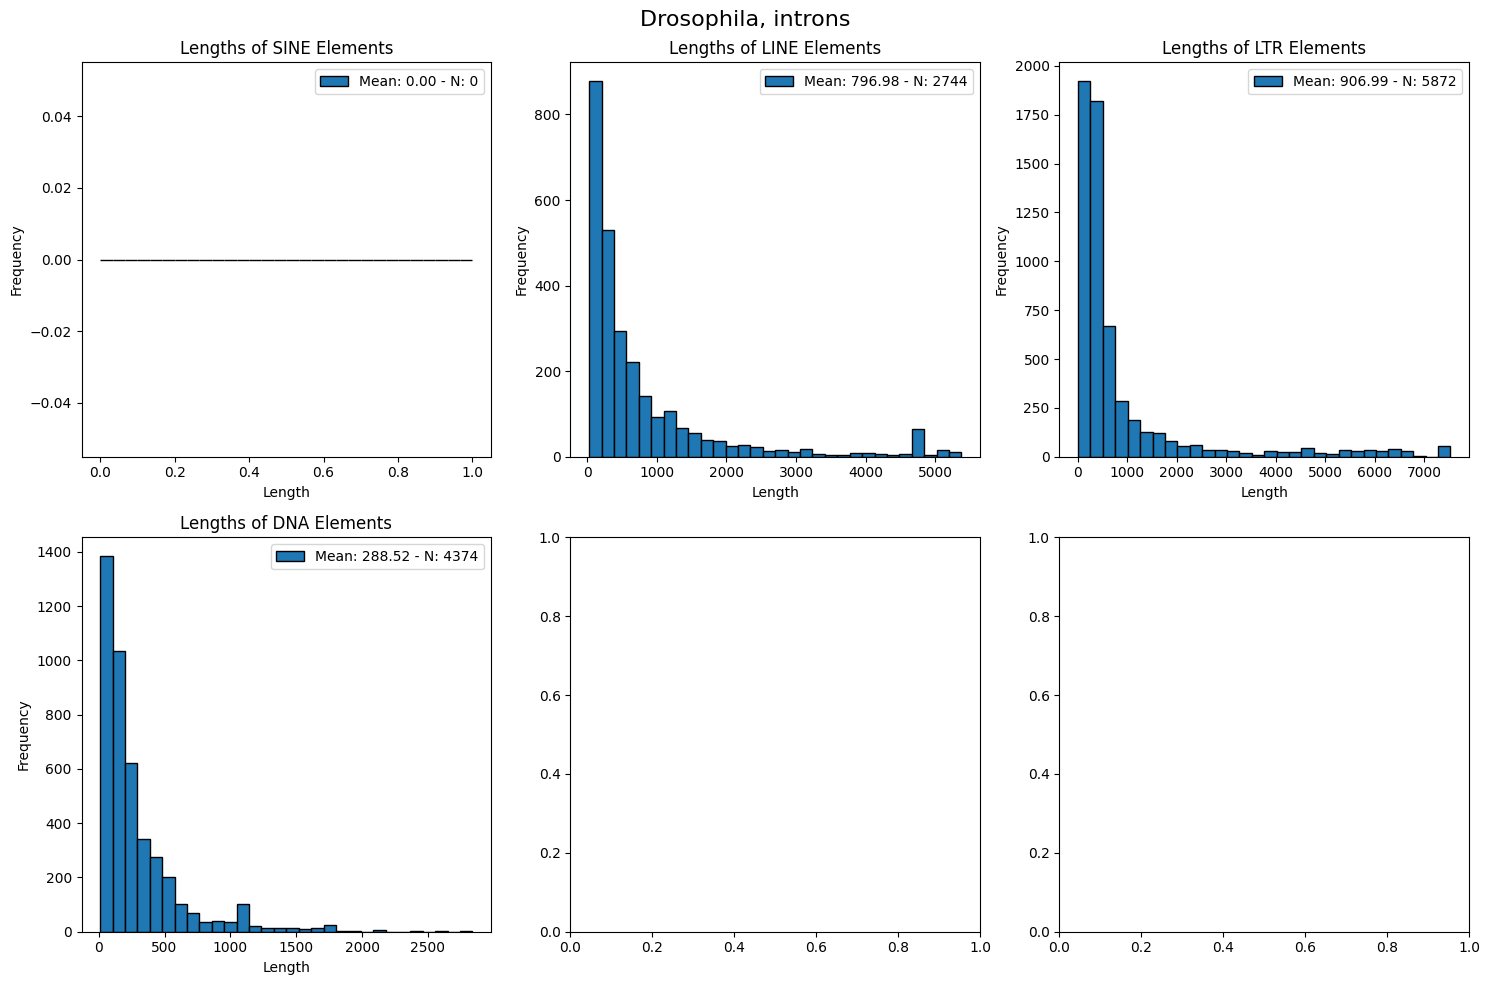

In [52]:
dm_intronic_lengths, dm_intronic_freqs = graph_data(dros_introns, "Drosophila, introns")

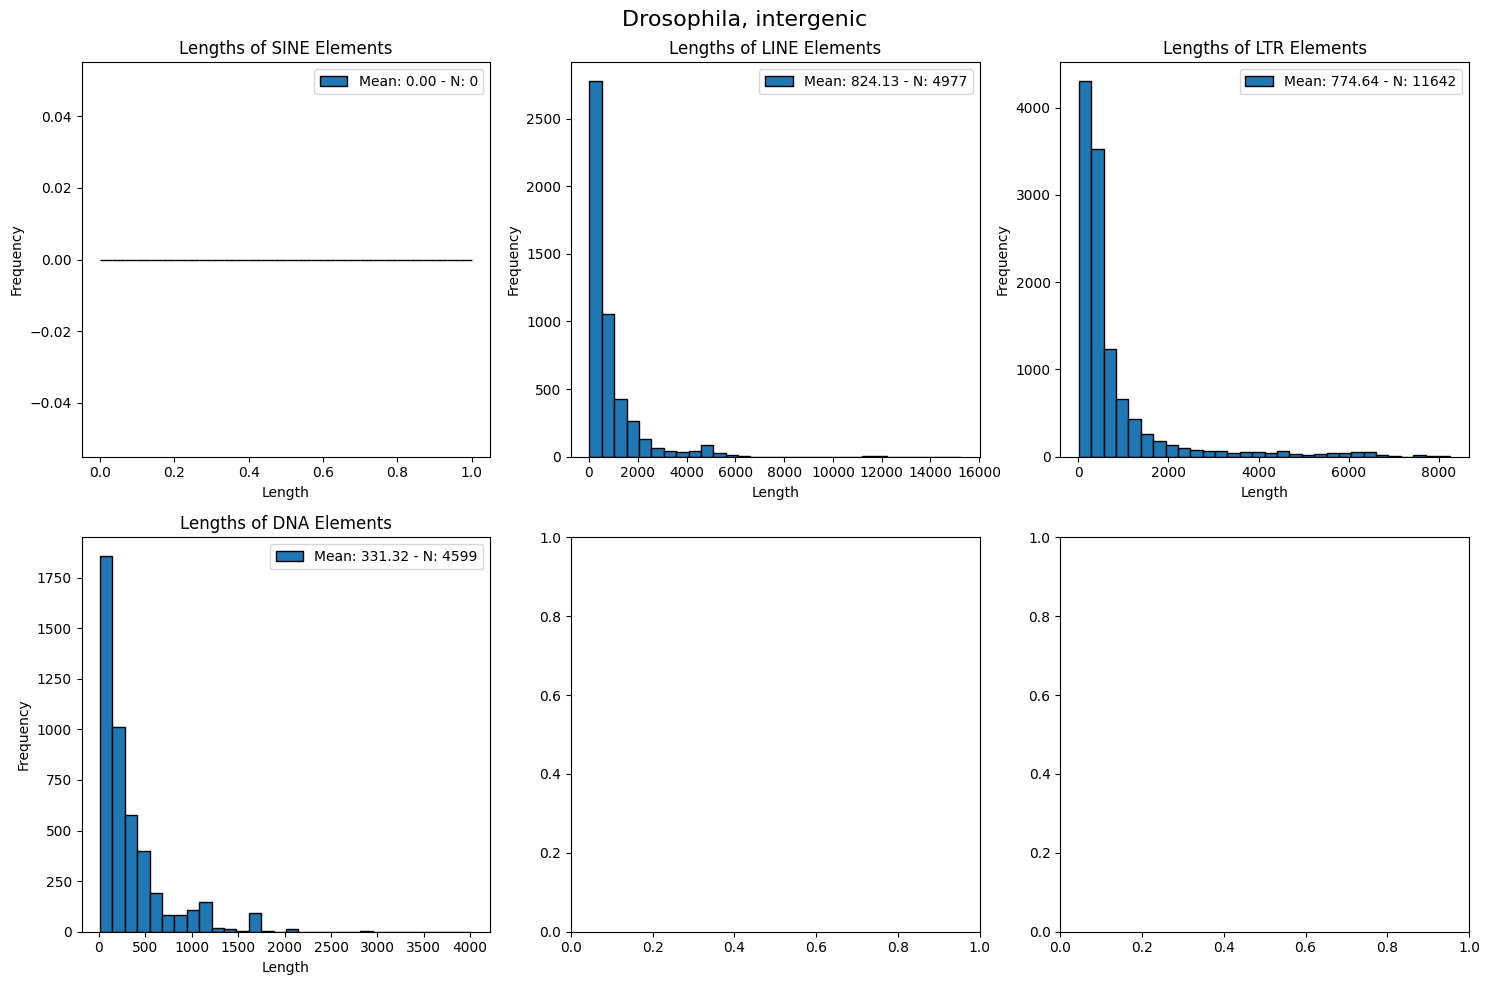

In [53]:
dm_intergenic_lengths, dm_intergenic_freqs = graph_data(dros_intergenic, "Drosophila, intergenic")

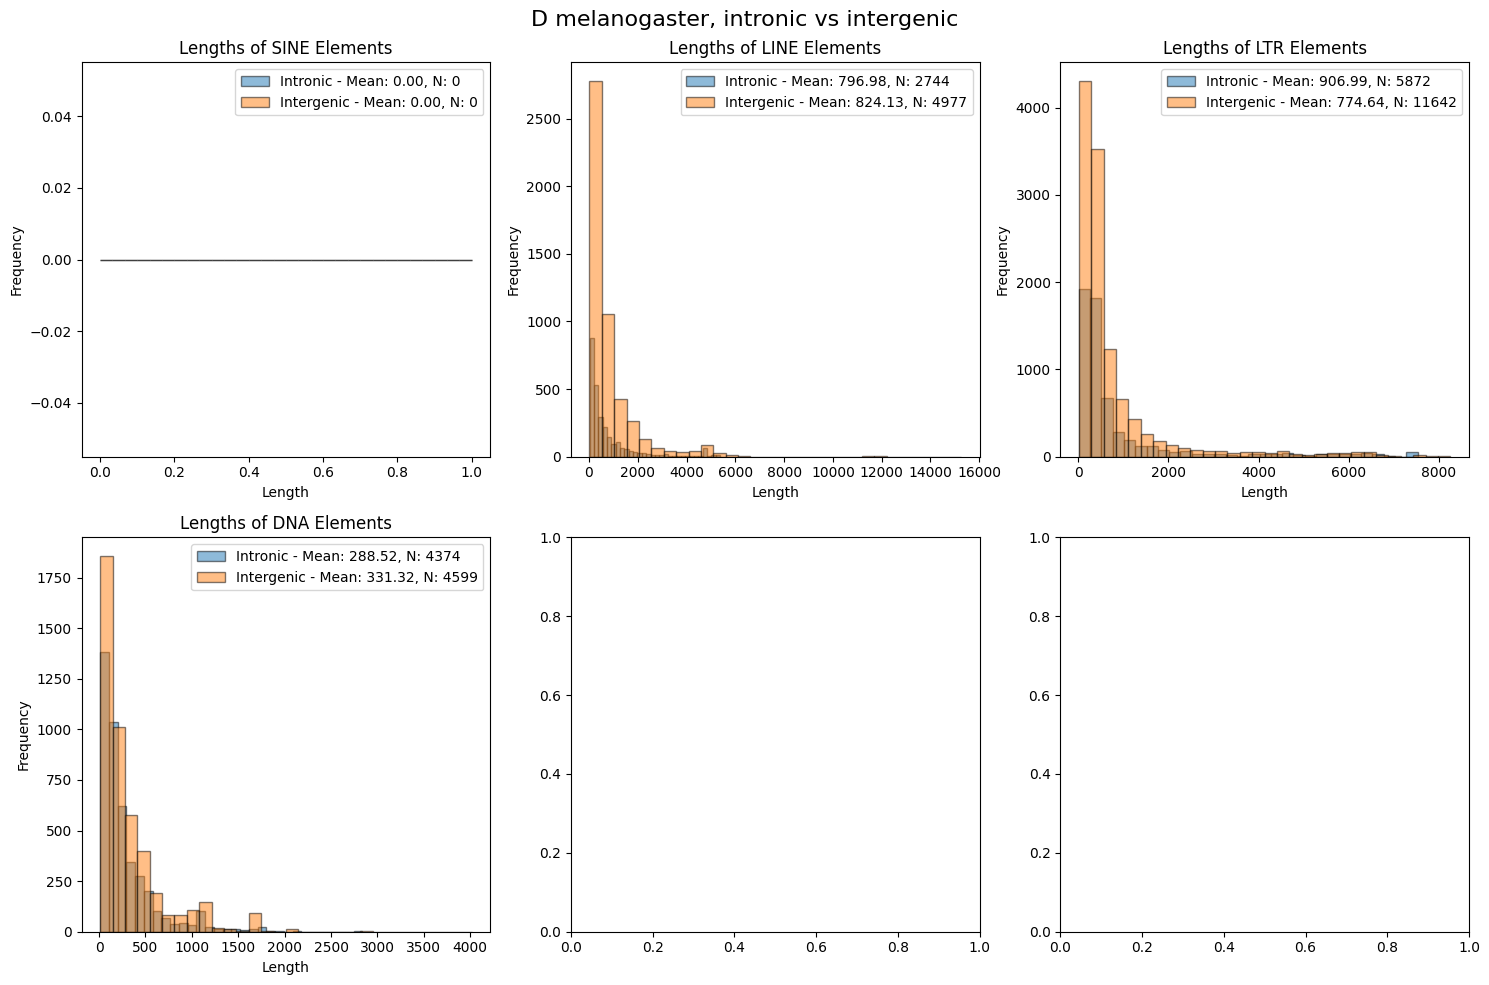

(([0, 796.9795918367347, 906.9919959128065, 288.52217649748513],
  [0, 2744, 5872, 4374]),
 ([0, 824.1269841269841, 774.6364885758461, 331.31963470319636],
  [0, 4977, 11642, 4599]))

In [54]:
graph_data_overlapping(dros_introns, dros_intergenic, "D melanogaster, intronic vs intergenic")

In [55]:
dm_occs_intronic, dm_occs_intergenic = occ_report(dros_introns, dros_fullintron, dros_size, dros_intergenic)

Para SINE
Ocupancia en intrones : 0.0
Ocupancia intergenica: 0.0
Para LINE
Ocupancia en intrones : 0.03558128343323122
Ocupancia intergenica: 0.029815766638575728
Para LTR
Ocupancia en intrones : 0.08665224181030537
Ocupancia intergenica: 0.0655555930644192
Para DNA
Ocupancia en intrones : 0.02053280487171138
Ocupancia intergenica: 0.011076302013344955
En total en intrones: 0.14276633011524797
En total en intergenica: 0.10644766171633989


In [56]:
t_test(dros_introns, dros_intergenic, titles)


Para SINE
Promedio 1: nan
Promedio 2: nan
Two-sample t-test
t-statistic: nan
p-value: nan
Fail to reject the null hypothesis: The means are not significantly different.

Para LINE
Promedio 1: 796.9795918367347
Promedio 2: 824.1269841269841
Two-sample t-test
t-statistic: -1.0387907528540752
p-value: 0.2989346004548029
Fail to reject the null hypothesis: The means are not significantly different.

Para LTR
Promedio 1: 906.9919959128065
Promedio 2: 774.6364885758461
Two-sample t-test
t-statistic: 6.4559088652715735
p-value: 1.1039783454859969e-10
Reject the null hypothesis: The means are significantly different.

Para DNA
Promedio 1: 288.52217649748513
Promedio 2: 331.31963470319636
Two-sample t-test
t-statistic: -5.7735928054246095
p-value: 8.017997797231342e-09
Reject the null hypothesis: The means are significantly different.


/home/seba/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/seba/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Cromosoma a cromosoma

In [57]:
dm_occs_per_chr_intronic = {}
dm_occs_per_chr_intergenic = {}
dm_freqs_per_chr_intronic = {}
dm_freqs_per_chr_intergenic = {}

for chr in dm_chr_lengths.keys():
    print(f"Para {chr}")
    df_chr_intron = process_tes(dm_introns_df[dm_introns_df[0]==chr])
    df_chr_intergenic = process_tes(dm_intergenic_df[dm_intergenic_df[0]==chr])
    df_chr_fullintron = sum(feat_len(dm_fullintron_df[dm_fullintron_df[0]==chr]))
    if df_chr_fullintron == 0:
        continue

    mini_intergenic_size = dm_chr_lengths[chr] - df_chr_fullintron

    dm_occs_per_chr_intronic[chr], dm_occs_per_chr_intergenic[chr] = occ_report(df_chr_intron, df_chr_fullintron, mini_intergenic_size, df_chr_intergenic)

    dm_freqs_per_chr_intronic[chr] = [len(el) for el in df_chr_intron]
    dm_freqs_per_chr_intergenic[chr] = [len(el) for el in df_chr_intergenic]

    print("\n")

Para NC_004354.4
Para SINE
Ocupancia en intrones : 0.0
Ocupancia intergenica: 0.0
Para LINE
Ocupancia en intrones : 0.007228879327017953
Ocupancia intergenica: 0.045231335200394567
Para LTR
Ocupancia en intrones : 0.05004184502295002
Ocupancia intergenica: 0.06130914331201401
Para DNA
Ocupancia en intrones : 0.010472811061116352
Ocupancia intergenica: 0.011329173994275007
En total en intrones: 0.06774353541108433
En total en intergenica: 0.11786965250668358


Para NT_033779.5
Para SINE
Ocupancia en intrones : 0.0
Ocupancia intergenica: 0.0
Para LINE
Ocupancia en intrones : 0.01705981131822247
Ocupancia intergenica: 0.016976651219346005
Para LTR
Ocupancia en intrones : 0.04423624630874039
Ocupancia intergenica: 0.05486048136334912
Para DNA
Ocupancia en intrones : 0.013141921281054672
Ocupancia intergenica: 0.013630625290423177
En total en intrones: 0.07443797890801754
En total en intergenica: 0.0854677578731183


Para NT_033778.4
Para SINE
Ocupancia en intrones : 0.0
Ocupancia intergeni

In [58]:
dm_prefs = pref_intron_inter(dm_occs_intronic, dm_occs_intergenic)

[None, 1.1933714086424345, 1.3218131018226809, 1.8537599324190543]


## En C elegans

In [59]:
# Cargar datos para c_elegans

ce_pcgenes_df = pd.read_csv("results/c_elegans/em_per_gene.bed", sep="\t", header=None)
elegans_pcgenes = process_tes(ce_pcgenes_df)

ce_introns_df = pd.read_csv("results/c_elegans/em_per_intron.bed", sep="\t", header=None)
elegans_introns = process_tes(ce_introns_df)

ce_intergenic_df = pd.read_csv("results/c_elegans/em_intergenic.bed", sep="\t", header=None)
elegans_intergenic = process_tes(ce_intergenic_df)

ce_fullintron_df = pd.read_csv("results/c_elegans/introns.bed", sep="\t", header=None)
elegans_fullintron = sum(feat_len(ce_fullintron_df))

ce_fullgene_df = pd.read_csv("results/c_elegans/genes.bed", sep="\t", header=None)
elegans_fullgene = sum(feat_len(ce_fullgene_df))

In [60]:
ce_chr_lengths = {"NC_003279.8": 15072434,
                    "NC_003280.10": 15279421,
                    "NC_003281.10": 13783801,
                    "NC_003282.8": 17493829,
                    "NC_003283.11": 20924180,
                    "NC_003284.9": 17718942,
                    "NC_001328.1": 13794,}
elegans_size = sum([len for len in ce_chr_lengths.values()])

In [61]:
#graph_data(elegans_pcgenes, "C elegans, pcgenes")

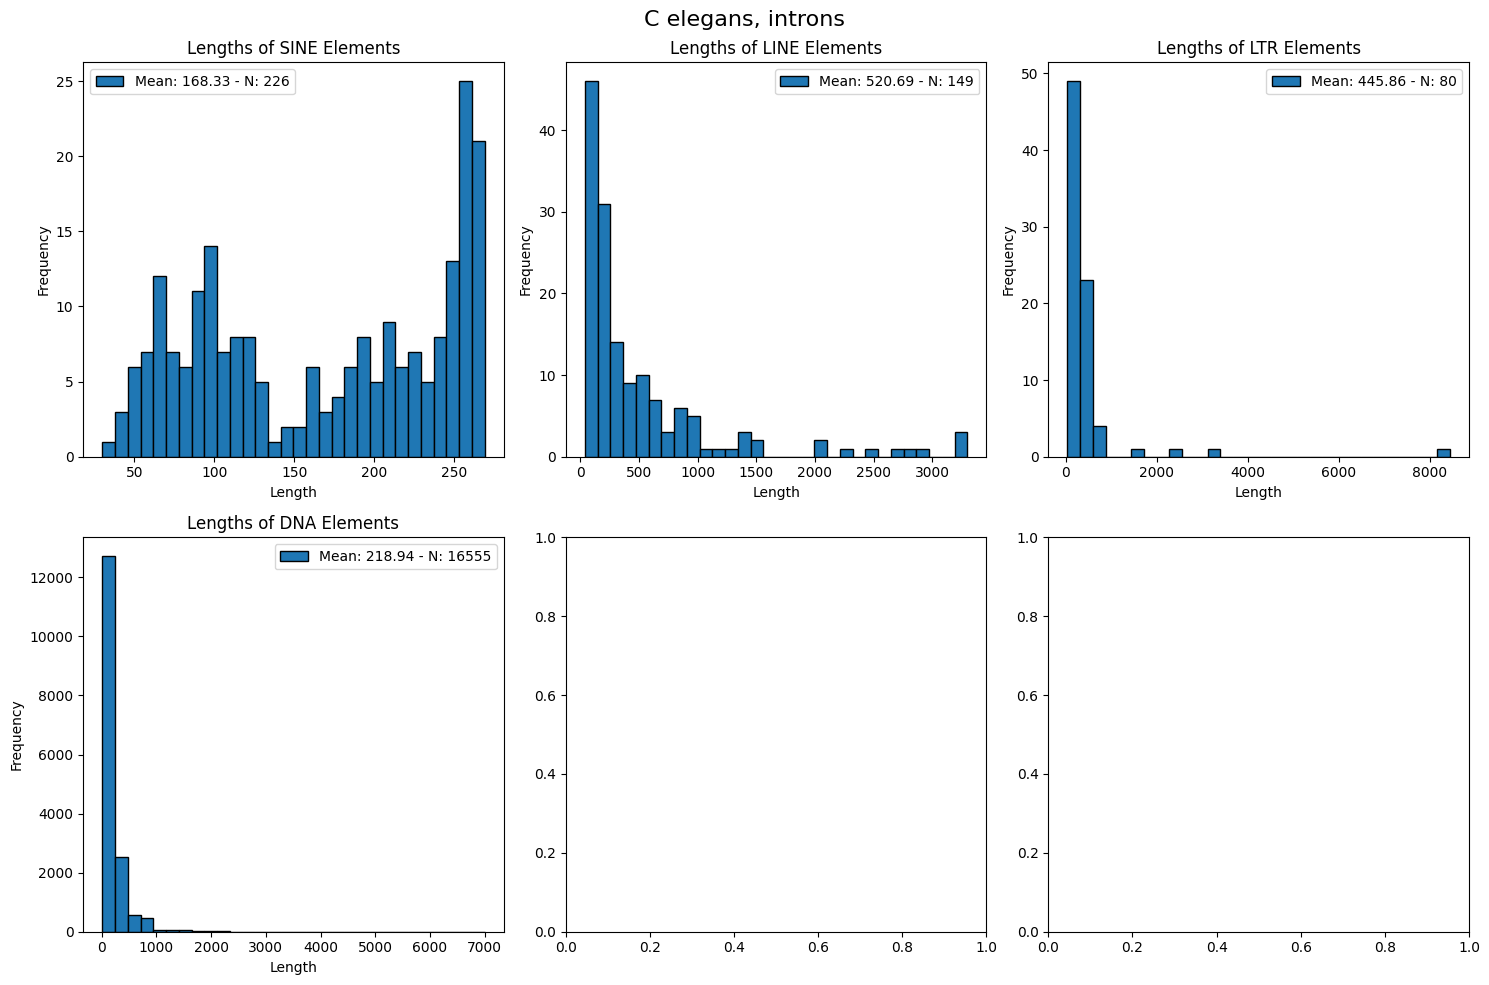

In [62]:
ce_intronic_lengths, ce_intronic_freqs = graph_data(elegans_introns, "C elegans, introns")

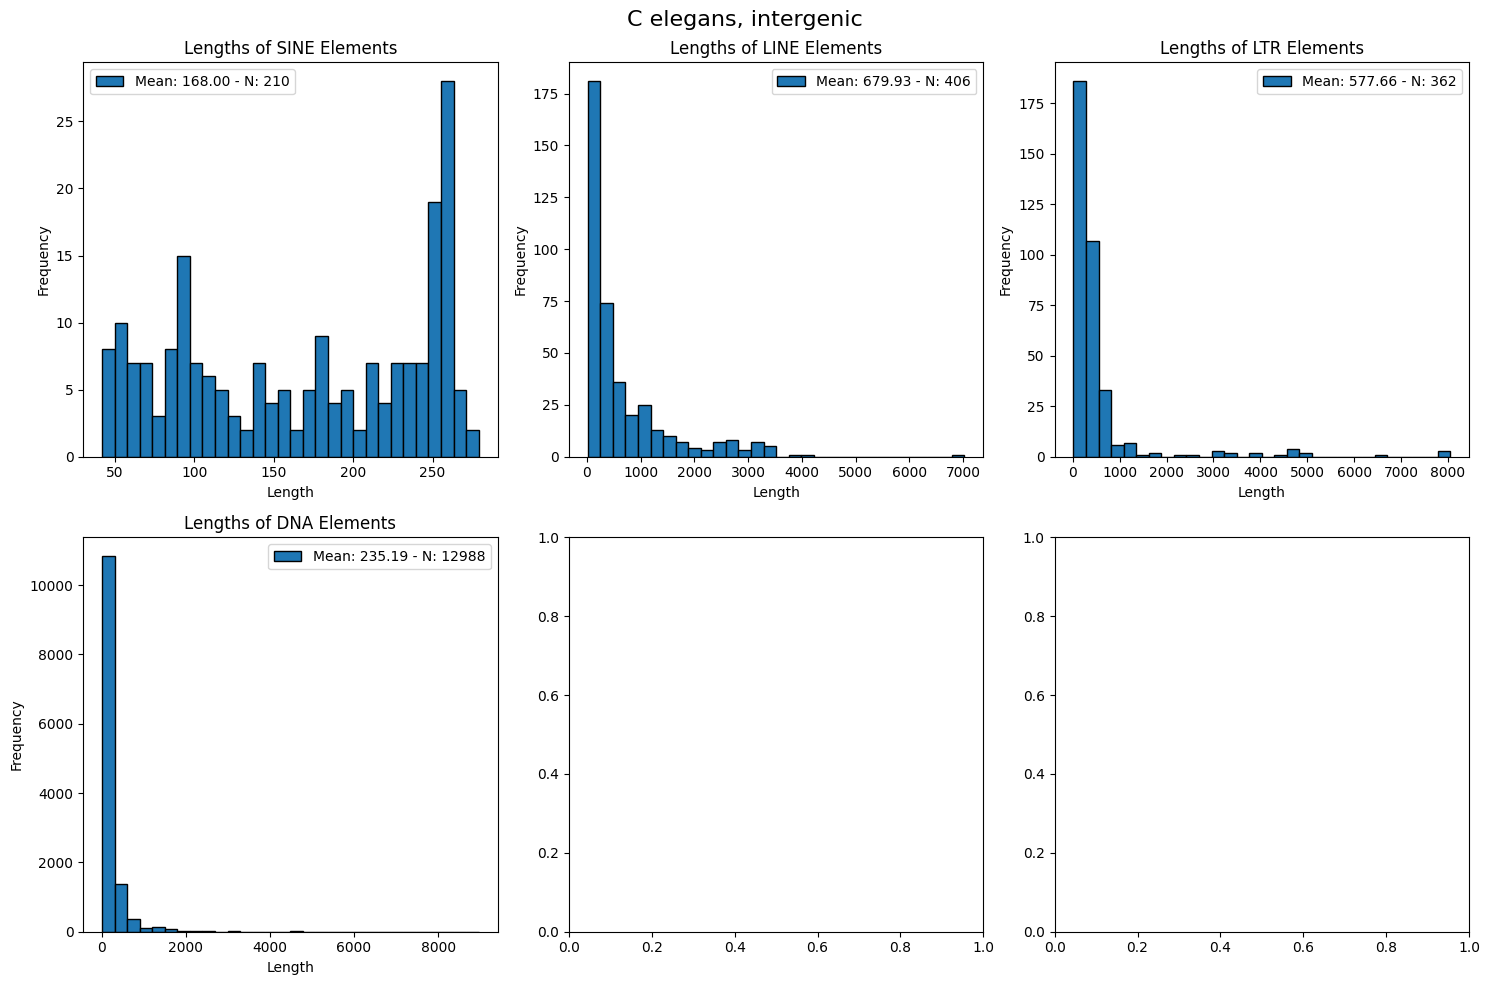

In [63]:
ce_intergenic_lengths, ce_intergenic_freqs = graph_data(elegans_intergenic, "C elegans, intergenic")

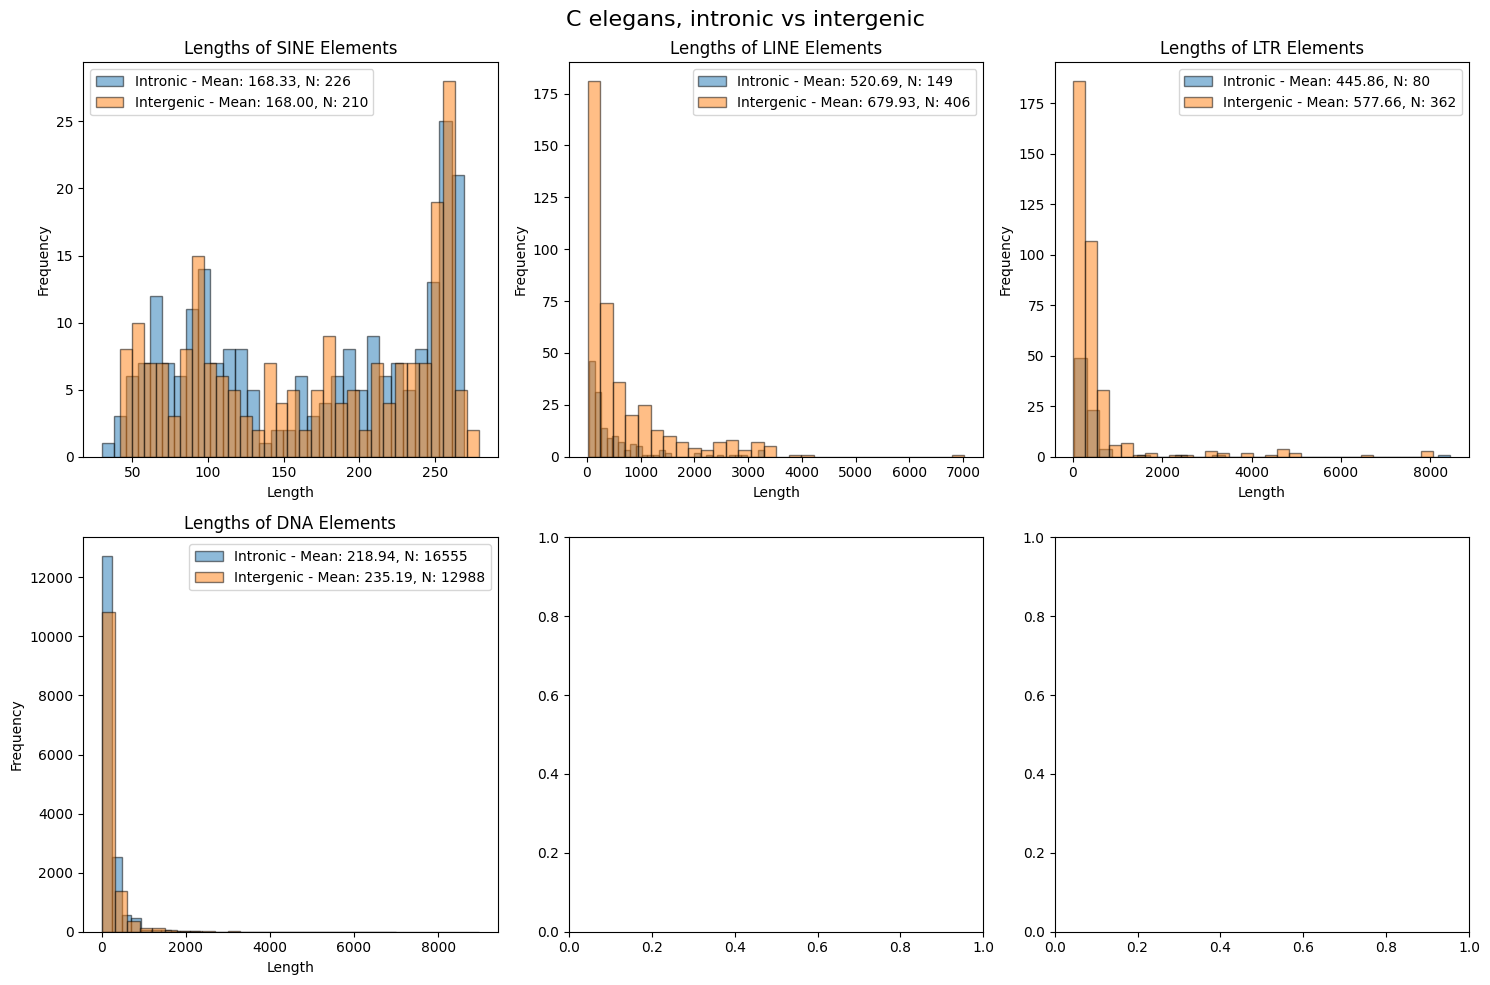

(([168.32743362831857, 520.6912751677852, 445.8625, 218.93506493506493],
  [226, 149, 80, 16555]),
 ([168.0, 679.9261083743843, 577.6602209944751, 235.19464120726823],
  [210, 406, 362, 12988]))

In [64]:
graph_data_overlapping(elegans_introns, elegans_intergenic, "C elegans, intronic vs intergenic")

In [65]:
t_test(elegans_introns, elegans_intergenic, titles)


Para SINE
Promedio 1: 168.32743362831857
Promedio 2: 168.0
Two-sample t-test
t-statistic: 0.044830298283929454
p-value: 0.9642631940282647
Fail to reject the null hypothesis: The means are not significantly different.

Para LINE
Promedio 1: 520.6912751677852
Promedio 2: 679.9261083743843
Two-sample t-test
t-statistic: -1.9879845439952528
p-value: 0.04730602877165789
Reject the null hypothesis: The means are significantly different.

Para LTR
Promedio 1: 445.8625
Promedio 2: 577.6602209944751
Two-sample t-test
t-statistic: -0.994043851083664
p-value: 0.32074785806283135
Fail to reject the null hypothesis: The means are not significantly different.

Para DNA
Promedio 1: 218.93506493506493
Promedio 2: 235.19464120726823
Two-sample t-test
t-statistic: -4.403286237883417
p-value: 1.0699740443978155e-05
Reject the null hypothesis: The means are significantly different.


In [66]:
ce_occs_intronic, ce_occs_intergenic = occ_report(elegans_introns, elegans_fullintron, elegans_size, elegans_intergenic)

Para SINE
Ocupancia en intrones : 0.0011566810569198242
Ocupancia intergenica: 0.0003517924628684202
Para LINE
Ocupancia en intrones : 0.0023589397623419044
Ocupancia intergenica: 0.002752616478878328
Para LTR
Ocupancia en intrones : 0.0010845291156951057
Ocupancia intergenica: 0.002085158086389001
Para DNA
Ocupancia en intrones : 0.11020334867709887
Ocupancia intergenica: 0.030459842705891898
En total en intrones: 0.1148034986120557
En total en intergenica: 0.035649409734027644


Cromosoma a cromosoma

In [67]:
ce_occs_per_chr_intronic = {}
ce_occs_per_chr_intergenic = {}
ce_freqs_per_chr_intronic = {}
ce_freqs_per_chr_intergenic = {}

for chr in ce_chr_lengths.keys():
    print(f"Para {chr}")
    df_chr_intron = process_tes(ce_introns_df[ce_introns_df[0]==chr])
    df_chr_intergenic = process_tes(ce_intergenic_df[ce_intergenic_df[0]==chr])
    df_chr_fullintron = sum(feat_len(ce_fullintron_df[ce_fullintron_df[0]==chr]))
    if df_chr_fullintron == 0:
        continue

    mini_intergenic_size = ce_chr_lengths[chr] - df_chr_fullintron

    ce_occs_per_chr_intronic[chr], ce_occs_per_chr_intergenic[chr] = occ_report(df_chr_intron, df_chr_fullintron, mini_intergenic_size, df_chr_intergenic)

    ce_freqs_per_chr_intronic[chr] = [len(el) for el in df_chr_intron]
    ce_freqs_per_chr_intergenic[chr] = [len(el) for el in df_chr_intergenic]

    print("\n")

Para NC_003279.8
Para SINE
Ocupancia en intrones : 0.000805952025822516
Ocupancia intergenica: 0.0003470600042743875
Para LINE
Ocupancia en intrones : 0.004071827219109944
Ocupancia intergenica: 0.003079386782849554
Para LTR
Ocupancia en intrones : 0.0006897667296393197
Ocupancia intergenica: 0.0017912348190151446
Para DNA
Ocupancia en intrones : 0.12706598239759376
Ocupancia intergenica: 0.04593997601630389
En total en intrones: 0.13263352837216555
En total en intergenica: 0.05115765762244298


Para NC_003280.10
Para SINE
Ocupancia en intrones : 0.0006287797148866359
Ocupancia intergenica: 0.0002549213054619373
Para LINE
Ocupancia en intrones : 0.0009442317002267218
Ocupancia intergenica: 0.0035935863880536024
Para LTR
Ocupancia en intrones : 0.00031757624113362183
Ocupancia intergenica: 0.0022154033006397153
Para DNA
Ocupancia en intrones : 0.10253336621681301
Ocupancia intergenica: 0.049070223015941335
En total en intrones: 0.10442395387306
En total en intergenica: 0.055134134010096

In [68]:
ce_prefs = pref_intron_inter(ce_occs_intronic, ce_occs_intergenic)

[3.287964294313076, 0.8569809054195432, 0.5201184134548056, 3.6179881078565796]


## Gráfico nuevo de tamaño vs proporcion

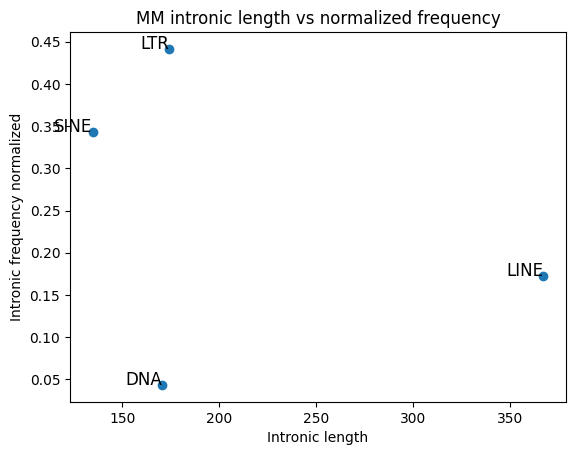

In [69]:
mm_intronic_lengths
mm_intronic_freqs
mm_occs_intronic

intronic_normalized = [el/sum(mm_intronic_freqs) for el in mm_intronic_freqs]

# Create the plot
plt.scatter(mm_intronic_lengths, intronic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(mm_intronic_lengths[i], intronic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intronic length')
plt.ylabel('Intronic frequency normalized')
plt.title('MM intronic length vs normalized frequency')

# Show the plot
plt.show()

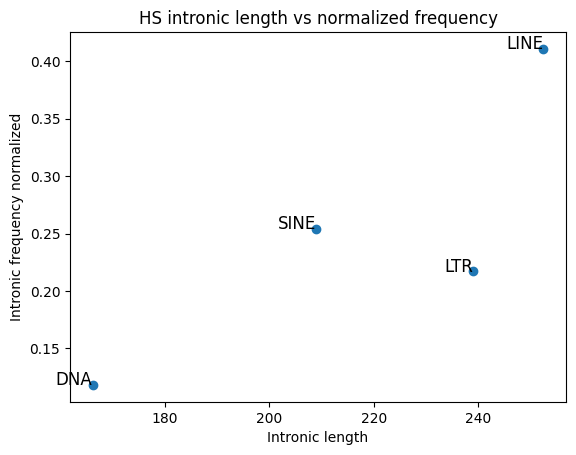

In [70]:
intronic_normalized = [el/sum(hs_intronic_freqs) for el in hs_intronic_freqs]

# Create the plot
plt.scatter(hs_intronic_lengths, intronic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(hs_intronic_lengths[i], intronic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intronic length')
plt.ylabel('Intronic frequency normalized')
plt.title('HS intronic length vs normalized frequency')

# Show the plot
plt.show()

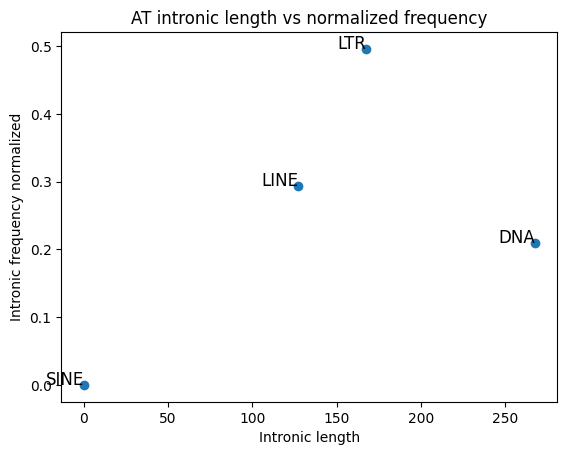

In [71]:
intronic_normalized = [el/sum(at_intronic_freqs) for el in at_intronic_freqs]

# Create the plot
plt.scatter(at_intronic_lengths, intronic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(at_intronic_lengths[i], intronic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intronic length')
plt.ylabel('Intronic frequency normalized')
plt.title('AT intronic length vs normalized frequency')

# Show the plot
plt.show()

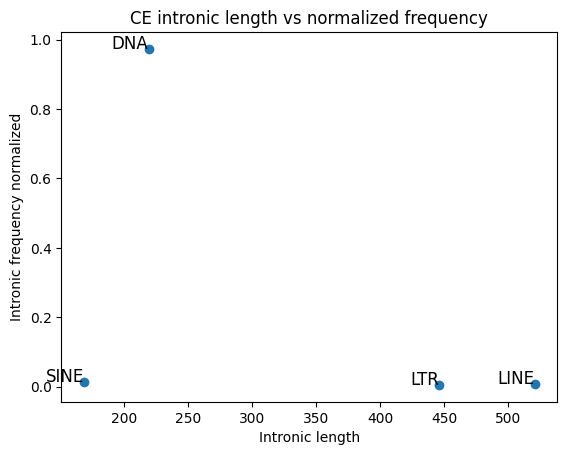

In [72]:
intronic_normalized = [el/sum(ce_intronic_freqs) for el in ce_intronic_freqs]

# Create the plot
plt.scatter(ce_intronic_lengths, intronic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(ce_intronic_lengths[i], intronic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intronic length')
plt.ylabel('Intronic frequency normalized')
plt.title('CE intronic length vs normalized frequency')

# Show the plot
plt.show()

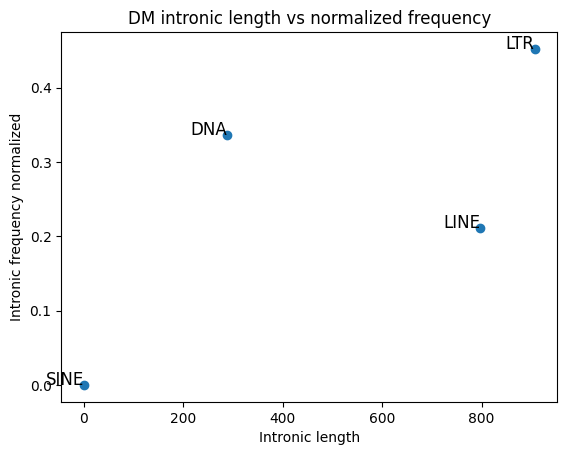

In [73]:
intronic_normalized = [el/sum(dm_intronic_freqs) for el in dm_intronic_freqs]

# Create the plot
plt.scatter(dm_intronic_lengths, intronic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(dm_intronic_lengths[i], intronic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intronic length')
plt.ylabel('Intronic frequency normalized')
plt.title('DM intronic length vs normalized frequency')

# Show the plot
plt.show()

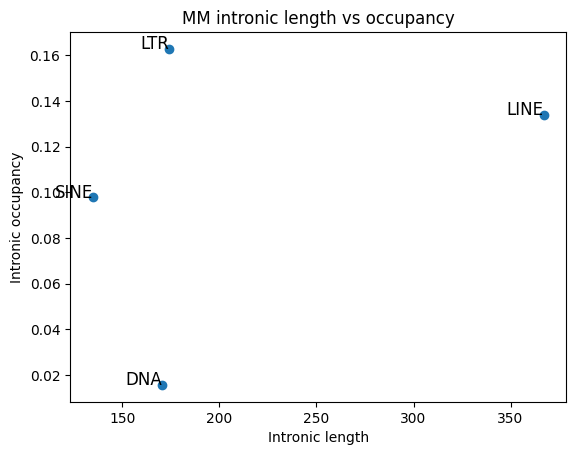

In [74]:
mm_intronic_lengths
mm_intronic_freqs
mm_occs_intronic

#intronic_normalized = [el/sum(mm_occs_intronic) for el in mm_occs_intronic]
intronic_normalized = mm_occs_intronic

# Create the plot
plt.scatter(mm_intronic_lengths, intronic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(mm_intronic_lengths[i], intronic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intronic length')
plt.ylabel('Intronic occupancy')
plt.title('MM intronic length vs occupancy')

# Show the plot
plt.show()

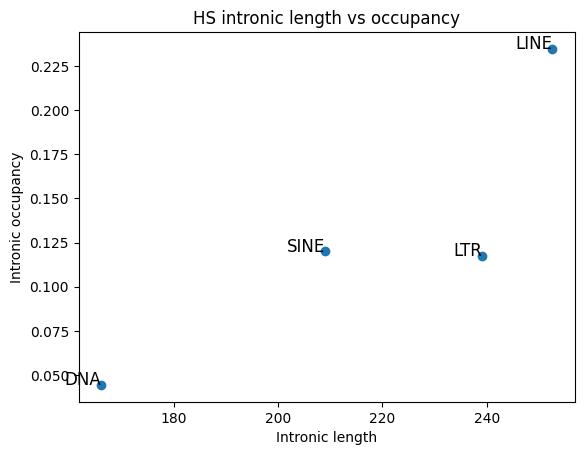

In [75]:
#intronic_normalized = [el/sum(mm_occs_intronic) for el in mm_occs_intronic]
intronic_normalized = hs_occs_intronic

# Create the plot
plt.scatter(hs_intronic_lengths, intronic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(hs_intronic_lengths[i], intronic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intronic length')
plt.ylabel('Intronic occupancy')
plt.title('HS intronic length vs occupancy')

# Show the plot
plt.show()

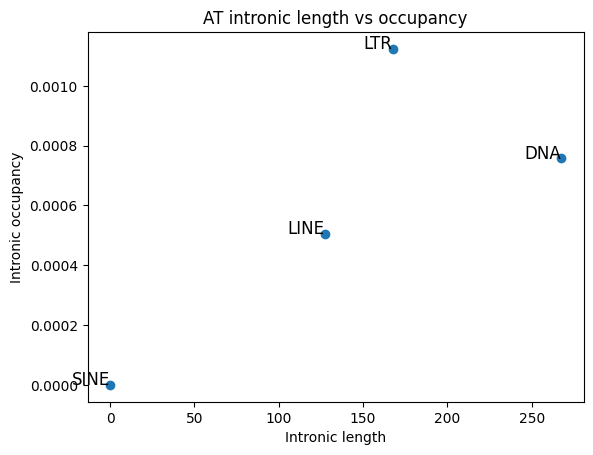

In [76]:
#intronic_normalized = [el/sum(mm_occs_intronic) for el in mm_occs_intronic]
intronic_normalized = at_occs_intronic

# Create the plot
plt.scatter(at_intronic_lengths, intronic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(at_intronic_lengths[i], intronic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intronic length')
plt.ylabel('Intronic occupancy')
plt.title('AT intronic length vs occupancy')

# Show the plot
plt.show()

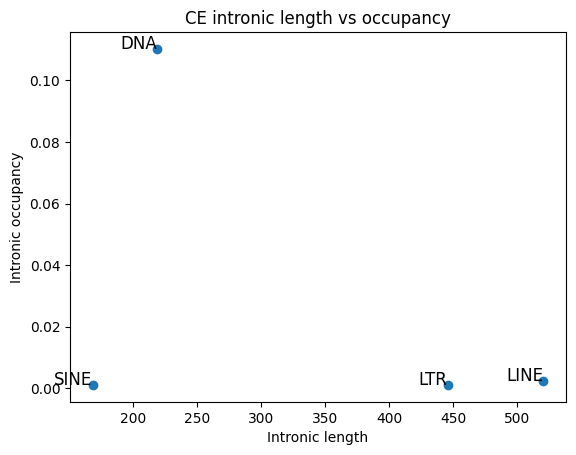

In [77]:
#intronic_normalized = [el/sum(mm_occs_intronic) for el in mm_occs_intronic]
intronic_normalized = ce_occs_intronic

# Create the plot
plt.scatter(ce_intronic_lengths, intronic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(ce_intronic_lengths[i], intronic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intronic length')
plt.ylabel('Intronic occupancy')
plt.title('CE intronic length vs occupancy')

# Show the plot
plt.show()

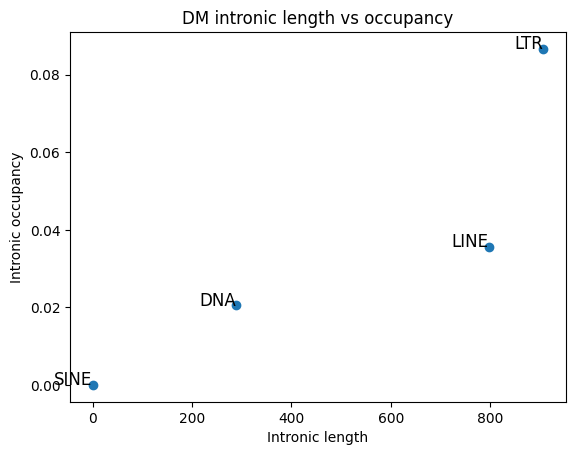

In [78]:
#intronic_normalized = [el/sum(mm_occs_intronic) for el in mm_occs_intronic]
intronic_normalized = dm_occs_intronic

# Create the plot
plt.scatter(dm_intronic_lengths, intronic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(dm_intronic_lengths[i], intronic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intronic length')
plt.ylabel('Intronic occupancy')
plt.title('DM intronic length vs occupancy')

# Show the plot
plt.show()

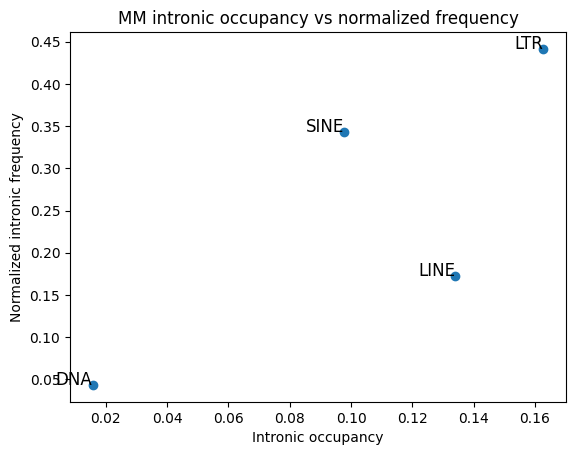

In [79]:

intronic_normalized = [el/sum(mm_intronic_freqs) for el in mm_intronic_freqs]

# Create the plot
plt.scatter(mm_occs_intronic, intronic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(mm_occs_intronic[i], intronic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intronic occupancy')
plt.ylabel('Normalized intronic frequency')
plt.title('MM intronic occupancy vs normalized frequency')

# Show the plot
plt.show()

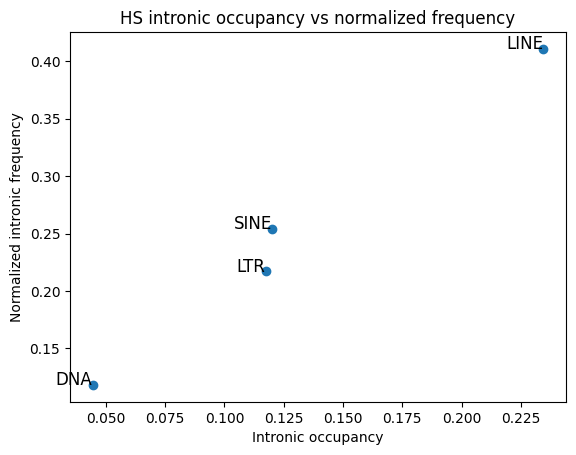

In [80]:
intronic_normalized = [el/sum(hs_intronic_freqs) for el in hs_intronic_freqs]

# Create the plot
plt.scatter(hs_occs_intronic, intronic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(hs_occs_intronic[i], intronic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intronic occupancy')
plt.ylabel('Normalized intronic frequency')
plt.title('HS intronic occupancy vs normalized frequency')

# Show the plot
plt.show()

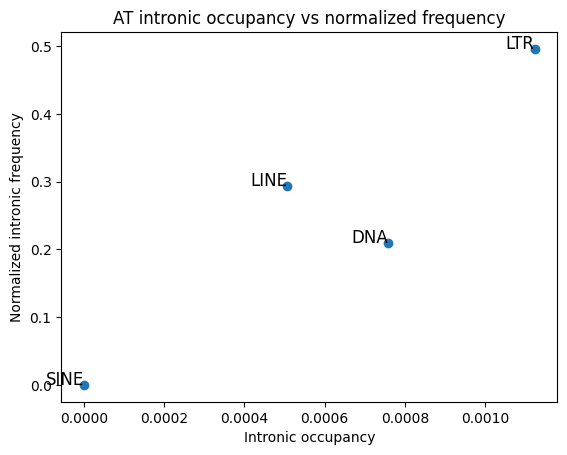

In [81]:
intronic_normalized = [el/sum(at_intronic_freqs) for el in at_intronic_freqs]

# Create the plot
plt.scatter(at_occs_intronic, intronic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(at_occs_intronic[i], intronic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intronic occupancy')
plt.ylabel('Normalized intronic frequency')
plt.title('AT intronic occupancy vs normalized frequency')

# Show the plot
plt.show()

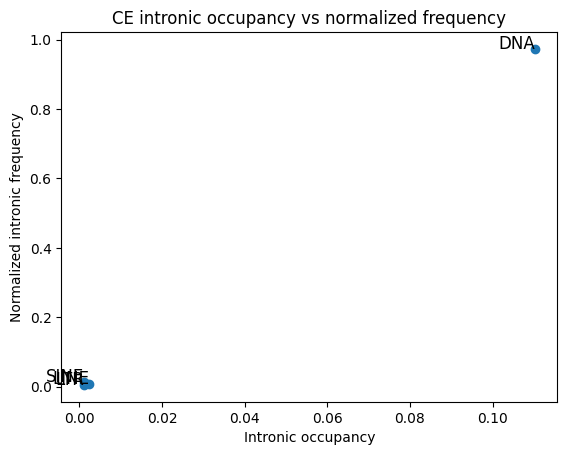

In [82]:
intronic_normalized = [el/sum(ce_intronic_freqs) for el in ce_intronic_freqs]

# Create the plot
plt.scatter(ce_occs_intronic, intronic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(ce_occs_intronic[i], intronic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intronic occupancy')
plt.ylabel('Normalized intronic frequency')
plt.title('CE intronic occupancy vs normalized frequency')

# Show the plot
plt.show()

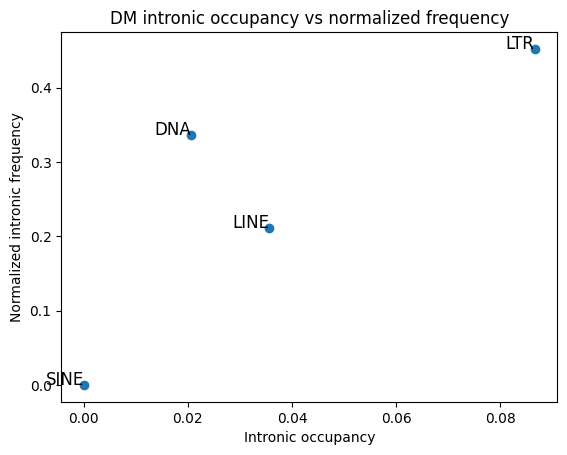

In [83]:
intronic_normalized = [el/sum(dm_intronic_freqs) for el in dm_intronic_freqs]

# Create the plot
plt.scatter(dm_occs_intronic, intronic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(dm_occs_intronic[i], intronic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intronic occupancy')
plt.ylabel('Normalized intronic frequency')
plt.title('DM intronic occupancy vs normalized frequency')

# Show the plot
plt.show()

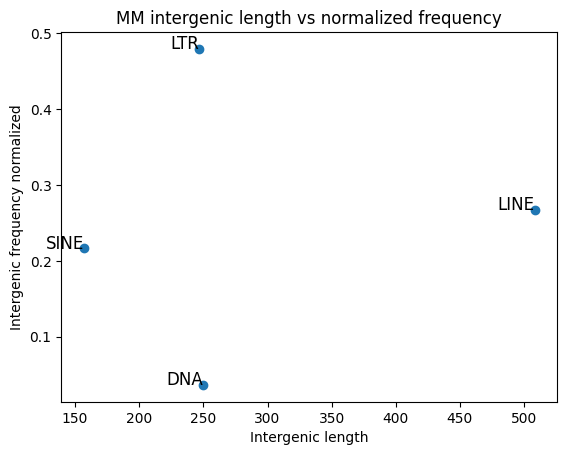

In [84]:
mm_intergenic_lengths
mm_intergenic_freqs
mm_occs_intergenic

intergenic_normalized = [el/sum(mm_intergenic_freqs) for el in mm_intergenic_freqs]

# Create the plot
plt.scatter(mm_intergenic_lengths, intergenic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(mm_intergenic_lengths[i], intergenic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intergenic length')
plt.ylabel('Intergenic frequency normalized')
plt.title('MM intergenic length vs normalized frequency')

# Show the plot
plt.show()

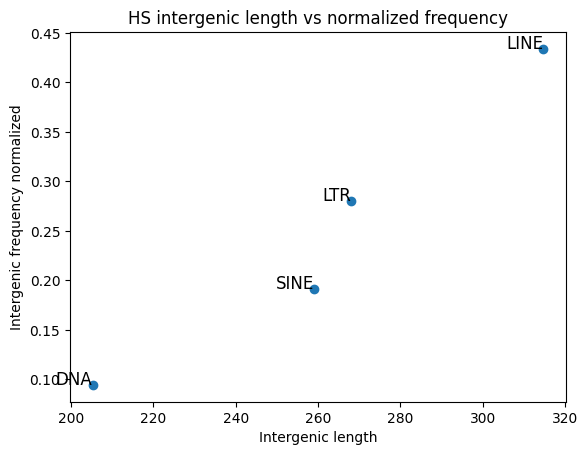

In [85]:
intergenic_normalized = [el/sum(hs_intergenic_freqs) for el in hs_intergenic_freqs]

# Create the plot
plt.scatter(hs_intergenic_lengths, intergenic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(hs_intergenic_lengths[i], intergenic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intergenic length')
plt.ylabel('Intergenic frequency normalized')
plt.title('HS intergenic length vs normalized frequency')

# Show the plot
plt.show()

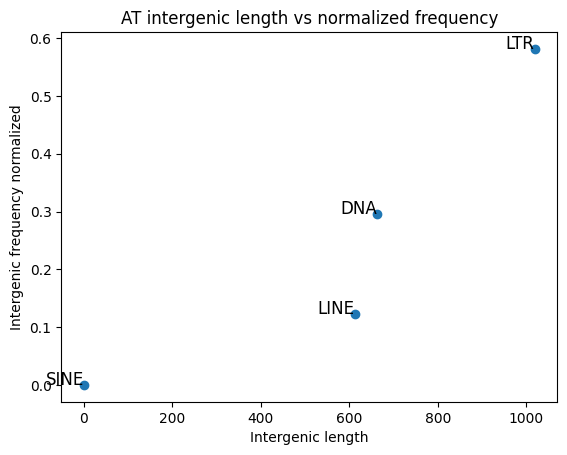

In [86]:
intergenic_normalized = [el/sum(at_intergenic_freqs) for el in at_intergenic_freqs]

# Create the plot
plt.scatter(at_intergenic_lengths, intergenic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(at_intergenic_lengths[i], intergenic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intergenic length')
plt.ylabel('Intergenic frequency normalized')
plt.title('AT intergenic length vs normalized frequency')

# Show the plot
plt.show()

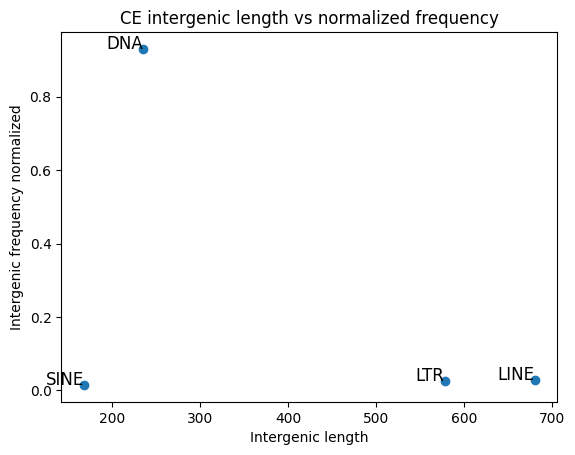

In [87]:
intergenic_normalized = [el/sum(ce_intergenic_freqs) for el in ce_intergenic_freqs]

# Create the plot
plt.scatter(ce_intergenic_lengths, intergenic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(ce_intergenic_lengths[i], intergenic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intergenic length')
plt.ylabel('Intergenic frequency normalized')
plt.title('CE intergenic length vs normalized frequency')

# Show the plot
plt.show()

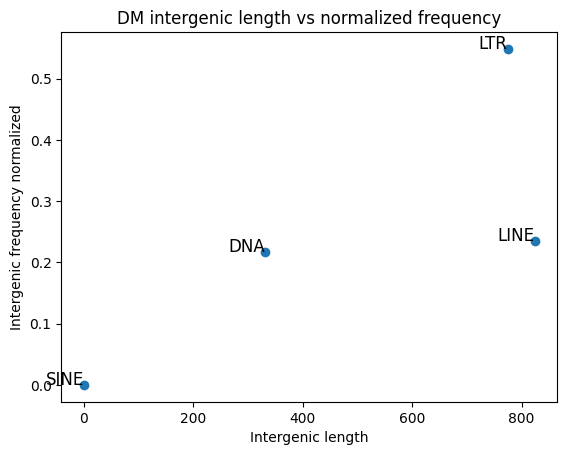

In [88]:
intergenic_normalized = [el/sum(dm_intergenic_freqs) for el in dm_intergenic_freqs]

# Create the plot
plt.scatter(dm_intergenic_lengths, intergenic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(dm_intergenic_lengths[i], intergenic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intergenic length')
plt.ylabel('Intergenic frequency normalized')
plt.title('DM intergenic length vs normalized frequency')

# Show the plot
plt.show()

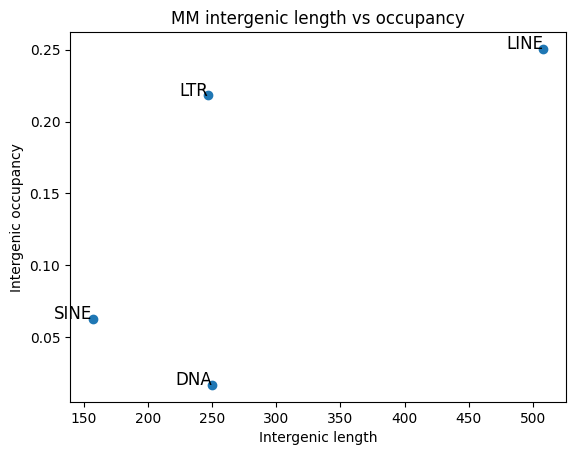

In [89]:
#intronic_normalized = [el/sum(mm_occs_intronic) for el in mm_occs_intronic]
intergenic_normalized = mm_occs_intergenic

# Create the plot
plt.scatter(mm_intergenic_lengths, intergenic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(mm_intergenic_lengths[i], intergenic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intergenic length')
plt.ylabel('Intergenic occupancy')
plt.title('MM intergenic length vs occupancy')

# Show the plot
plt.show()

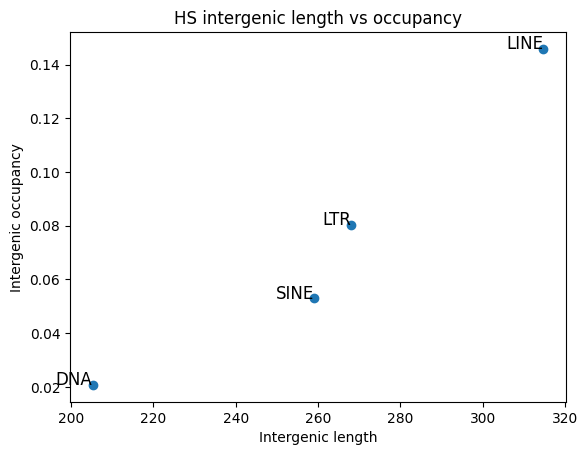

In [90]:
#intronic_normalized = [el/sum(mm_occs_intronic) for el in mm_occs_intronic]
intergenic_normalized = hs_occs_intergenic

# Create the plot
plt.scatter(hs_intergenic_lengths, intergenic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(hs_intergenic_lengths[i], intergenic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intergenic length')
plt.ylabel('Intergenic occupancy')
plt.title('HS intergenic length vs occupancy')

# Show the plot
plt.show()

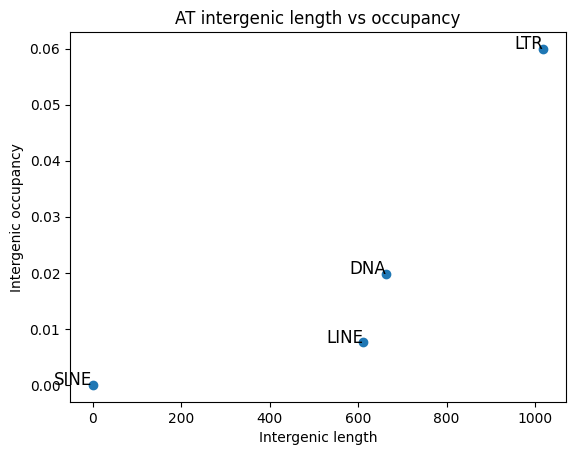

In [91]:
#intronic_normalized = [el/sum(mm_occs_intronic) for el in mm_occs_intronic]
intergenic_normalized = at_occs_intergenic

# Create the plot
plt.scatter(at_intergenic_lengths, intergenic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(at_intergenic_lengths[i], intergenic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intergenic length')
plt.ylabel('Intergenic occupancy')
plt.title('AT intergenic length vs occupancy')

# Show the plot
plt.show()

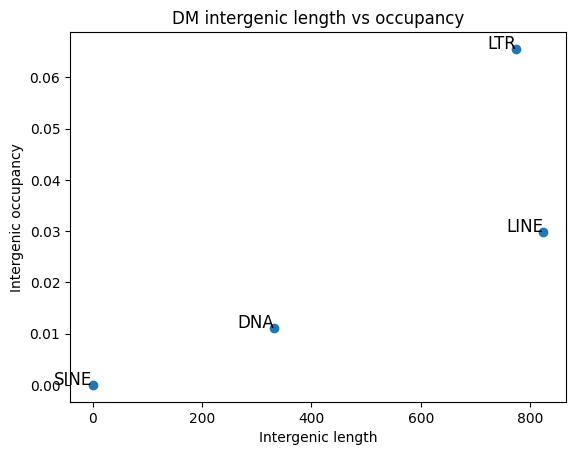

In [92]:
#intronic_normalized = [el/sum(mm_occs_intronic) for el in mm_occs_intronic]
intergenic_normalized = dm_occs_intergenic

# Create the plot
plt.scatter(dm_intergenic_lengths, intergenic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(dm_intergenic_lengths[i], intergenic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intergenic length')
plt.ylabel('Intergenic occupancy')
plt.title('DM intergenic length vs occupancy')

# Show the plot
plt.show()

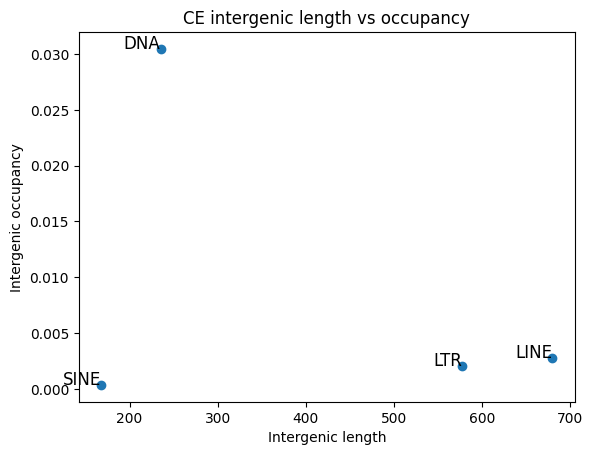

In [93]:
#intronic_normalized = [el/sum(mm_occs_intronic) for el in mm_occs_intronic]
intergenic_normalized = ce_occs_intergenic

# Create the plot
plt.scatter(ce_intergenic_lengths, intergenic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(ce_intergenic_lengths[i], intergenic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intergenic length')
plt.ylabel('Intergenic occupancy')
plt.title('CE intergenic length vs occupancy')

# Show the plot
plt.show()

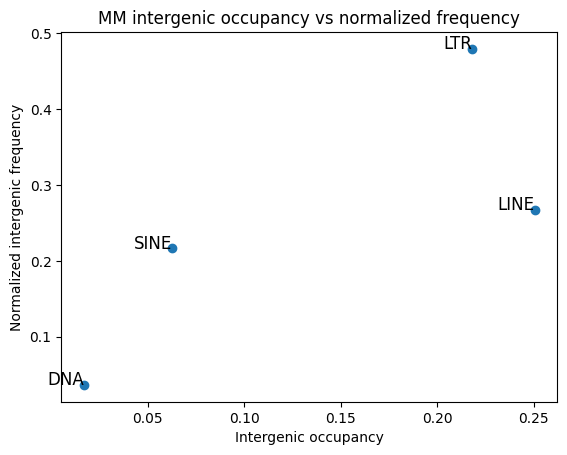

In [94]:
intergenic_normalized = [el/sum(mm_intergenic_freqs) for el in mm_intergenic_freqs]

# Create the plot
plt.scatter(mm_occs_intergenic, intergenic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(mm_occs_intergenic[i], intergenic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intergenic occupancy')
plt.ylabel('Normalized intergenic frequency')
plt.title('MM intergenic occupancy vs normalized frequency')

# Show the plot
plt.show()

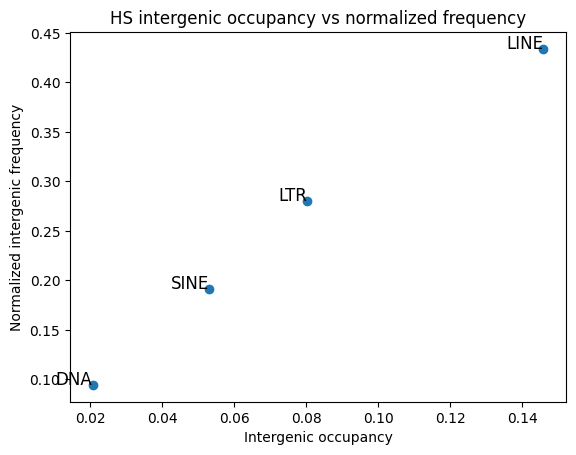

In [95]:
intergenic_normalized = [el/sum(hs_intergenic_freqs) for el in hs_intergenic_freqs]

# Create the plot
plt.scatter(hs_occs_intergenic, intergenic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(hs_occs_intergenic[i], intergenic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intergenic occupancy')
plt.ylabel('Normalized intergenic frequency')
plt.title('HS intergenic occupancy vs normalized frequency')

# Show the plot
plt.show()

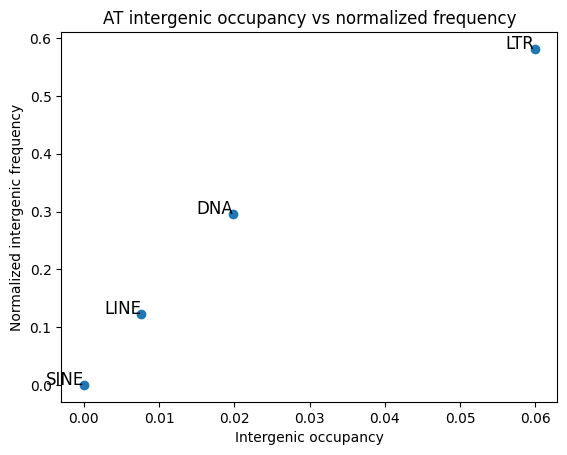

In [96]:
intergenic_normalized = [el/sum(at_intergenic_freqs) for el in at_intergenic_freqs]

# Create the plot
plt.scatter(at_occs_intergenic, intergenic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(at_occs_intergenic[i], intergenic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intergenic occupancy')
plt.ylabel('Normalized intergenic frequency')
plt.title('AT intergenic occupancy vs normalized frequency')

# Show the plot
plt.show()

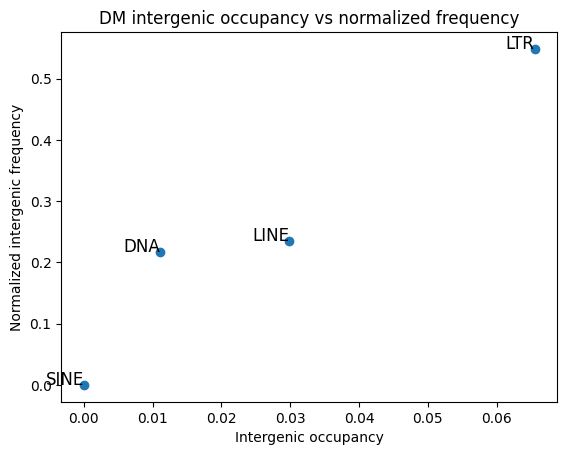

In [97]:
intergenic_normalized = [el/sum(dm_intergenic_freqs) for el in dm_intergenic_freqs]

# Create the plot
plt.scatter(dm_occs_intergenic, intergenic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(dm_occs_intergenic[i], intergenic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intergenic occupancy')
plt.ylabel('Normalized intergenic frequency')
plt.title('DM intergenic occupancy vs normalized frequency')

# Show the plot
plt.show()

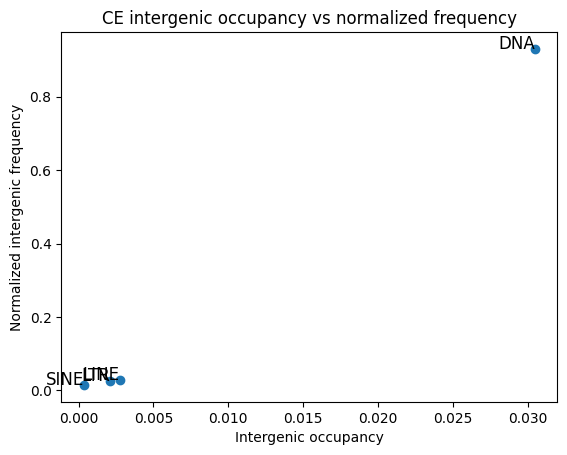

In [98]:
intergenic_normalized = [el/sum(ce_intergenic_freqs) for el in ce_intergenic_freqs]

# Create the plot
plt.scatter(ce_occs_intergenic, intergenic_normalized, marker='o')  # 'o' adds markers at each data point

# Add labels to each point
for i in range(len(titles)):
    plt.text(ce_occs_intergenic[i], intergenic_normalized[i], titles[i], fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Intergenic occupancy')
plt.ylabel('Normalized intergenic frequency')
plt.title('CE intergenic occupancy vs normalized frequency')

# Show the plot
plt.show()

## Análisis de todo junto

### Preferencias intronicas nivel genoma completo

In [99]:
data = [mm_occs_intronic, hs_occs_intronic, at_occs_intronic, dm_occs_intronic, ce_occs_intronic]
intronic_occs = pd.DataFrame(data=data, columns=titles, index=["MM", "HS", "AT", "DM", "CE"])
print(intronic_occs)

        SINE      LINE       LTR       DNA
MM  0.097778  0.133954  0.162772  0.015660
HS  0.119947  0.234575  0.117405  0.044402
AT  0.000000  0.000506  0.001123  0.000758
DM  0.000000  0.035581  0.086652  0.020533
CE  0.001157  0.002359  0.001085  0.110203


In [100]:
data = [mm_occs_intergenic, hs_occs_intergenic, at_occs_intergenic, dm_occs_intergenic, ce_occs_intergenic]
intronic_occs = pd.DataFrame(data=data, columns=titles, index=["MM", "HS", "AT", "DM", "CE"])
print(intronic_occs)

        SINE      LINE       LTR       DNA
MM  0.062537  0.250585  0.218251  0.016761
HS  0.052980  0.145886  0.080227  0.020708
AT  0.000000  0.007598  0.059940  0.019821
DM  0.000000  0.029816  0.065556  0.011076
CE  0.000352  0.002753  0.002085  0.030460


In [101]:
data = [mm_prefs, hs_prefs, at_prefs, dm_prefs, ce_prefs]
all_prefs = pd.DataFrame(data=data, columns=titles, index=["MM", "HS", "AT", "DM", "CE"])
print(all_prefs)

        SINE      LINE       LTR       DNA
MM  1.563527  0.534564  0.745803  0.934302
HS  2.264004  1.607933  1.463410  2.144196
AT       NaN  0.066613  0.018742  0.038223
DM       NaN  1.193371  1.321813  1.853760
CE  3.287964  0.856981  0.520118  3.617988


In [102]:
row_order =["HS", "MM", "DM", "CE", "AT"]
col_order = ["SINE", "DNA", "LINE", "LTR"]
all_prefs = all_prefs.loc[row_order]
all_prefs = all_prefs[col_order]

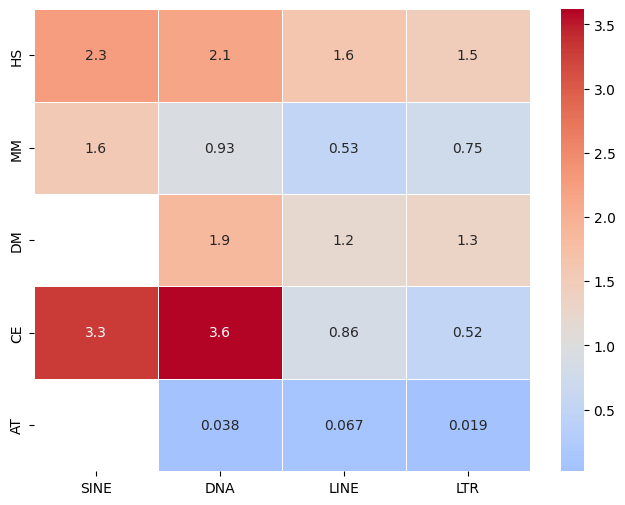

In [103]:
plt.figure(figsize=(8,6))
sns.heatmap(all_prefs, annot=True, cmap="coolwarm", linewidth=0.5, center=1)
#plt.title("Intronic preference for each class of TE for all organisms, by relative occupancy")
plt.show()

In [104]:
data = [mm_intronic_freqs, hs_intronic_freqs, at_intronic_freqs, dm_intronic_freqs, ce_intronic_freqs]
intronic_freqs = pd.DataFrame(data=data, columns=titles, index=["MM", "HS", "AT", "DM", "CE"])
print(intronic_freqs)

      SINE     LINE      LTR     DNA
MM  838064   421361  1079013  106137
HS  965418  1562484   826038  449771
AT       0       73      123      52
DM       0     2744     5872    4374
CE     226      149       80   16555


In [105]:
data = [mm_intergenic_freqs, hs_intergenic_freqs, at_intergenic_freqs, dm_intergenic_freqs, ce_intergenic_freqs]
intergenic_freqs = pd.DataFrame(data=data, columns=titles, index=["MM", "HS", "AT", "DM", "CE"])
print(intergenic_freqs)

      SINE     LINE      LTR     DNA
MM  625741   773377  1386664  105326
HS  631664  1431304   924555  311597
AT       0     1486     7041    3582
DM       0     4977    11642    4599
CE     210      406      362   12988


In [106]:
mm_freq_prefs = pref_intron_inter(mm_intronic_freqs, mm_intergenic_freqs)
hs_freq_prefs = pref_intron_inter(hs_intronic_freqs, hs_intergenic_freqs)
at_freq_prefs = pref_intron_inter(at_intronic_freqs, at_intergenic_freqs)
dm_freq_prefs = pref_intron_inter(dm_intronic_freqs, dm_intergenic_freqs)
ce_freq_prefs = pref_intron_inter(ce_intronic_freqs, ce_intergenic_freqs)

[1.3393145087184635, 0.54483259781452, 0.7781358714151373, 1.0076999031578149]
[1.528372679145875, 1.0916506905590986, 0.8934438729983614, 1.4434381589039689]
[None, 0.04912516823687752, 0.017469109501491265, 0.014517029592406477]
[None, 0.5513361462728551, 0.5043806906029892, 0.9510763209393346]
[1.0761904761904761, 0.3669950738916256, 0.22099447513812154, 1.2746381275023098]


In [107]:
data = [mm_freq_prefs, hs_freq_prefs, at_freq_prefs, dm_freq_prefs, ce_freq_prefs]

all_freq_prefs = pd.DataFrame(data=data, columns=titles, index=["MM", "HS", "AT", "DM", "CE"])
print(all_freq_prefs)


        SINE      LINE       LTR       DNA
MM  1.339315  0.544833  0.778136  1.007700
HS  1.528373  1.091651  0.893444  1.443438
AT       NaN  0.049125  0.017469  0.014517
DM       NaN  0.551336  0.504381  0.951076
CE  1.076190  0.366995  0.220994  1.274638


In [108]:
row_order =["HS", "MM", "DM", "CE", "AT"]
col_order = ["SINE", "DNA", "LINE", "LTR"]
all_freq_prefs = all_freq_prefs.loc[row_order]
all_freq_prefs = all_freq_prefs[col_order]

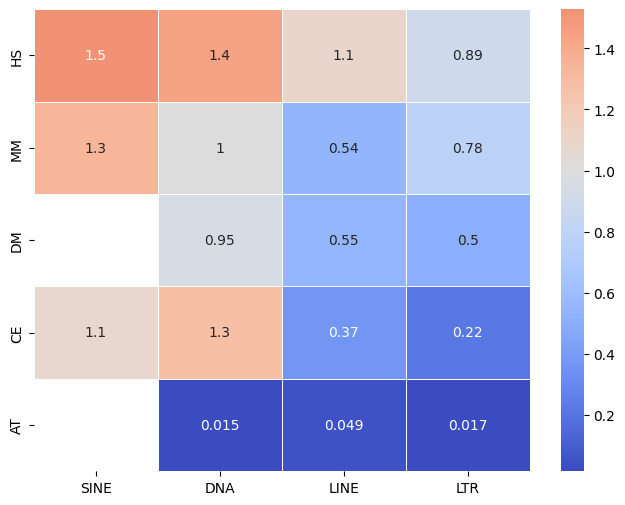

In [109]:
plt.figure(figsize=(8,6))
sns.heatmap(all_freq_prefs, annot=True, cmap="coolwarm", linewidth=0.5, center=1)
#plt.title("Intronic preference for each class of TE for all organisms, by frequency")
plt.show()

In [110]:
organism_names = ["MM", "HS", "AT", "DM", "CE"]
data = [mm_intronic_lengths, hs_intronic_lengths, at_intronic_lengths, dm_intronic_lengths, ce_intronic_lengths,] 
df_lengths_intronic = pd.DataFrame(data=data, columns=titles, index=organism_names)
print(df_lengths_intronic)

          SINE        LINE         LTR         DNA
MM  134.700456  367.034920  174.164810  170.347560
HS  209.029623  252.580837  239.123215  166.090588
AT    0.000000  127.232877  167.601626  267.365385
DM    0.000000  796.979592  906.991996  288.522176
CE  168.327434  520.691275  445.862500  218.935065


In [111]:
data = [mm_intergenic_lengths, hs_intergenic_lengths, at_intergenic_lengths, dm_intergenic_lengths, ce_intergenic_lengths,]
df_lengths_intergenic = pd.DataFrame(data=data, columns=titles, index=organism_names)
print(df_lengths_intergenic)

          SINE        LINE          LTR         DNA
MM  156.795470  508.344587   246.932764  249.670366
HS  259.025968  314.774439   267.982478  205.240022
AT    0.000000  611.880888  1018.746201  662.192630
DM    0.000000  824.126984   774.636489  331.319635
CE  168.000000  679.926108   577.660221  235.194641


In [112]:
df_lengths_pref = df_lengths_intronic / df_lengths_intergenic
print(df_lengths_pref)

        SINE      LINE       LTR       DNA
MM  0.859084  0.722020  0.705313  0.682290
HS  0.806983  0.802419  0.892309  0.809250
AT       NaN  0.207937  0.164518  0.403758
DM       NaN  0.967059  1.170861  0.870827
CE  1.001949  0.765806  0.771842  0.930868


In [113]:
row_order =["HS", "MM", "DM", "CE", "AT"]
col_order = ["SINE", "DNA", "LINE", "LTR"]
df_lengths_pref = df_lengths_pref.loc[row_order]
df_lengths_pref = df_lengths_pref[col_order]

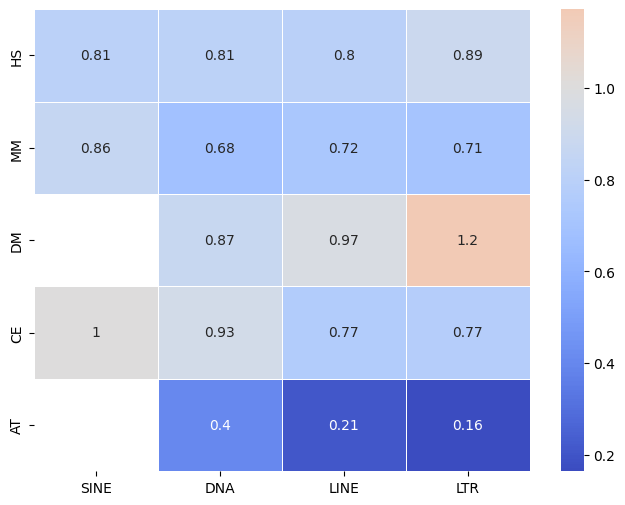

In [114]:
plt.figure(figsize=(8,6))
sns.heatmap(df_lengths_pref, annot=True, cmap="coolwarm", linewidth=0.5, center=1)
#plt.title("Intronic preference for each class of TE for all organisms by mean size")
plt.show()

Matriz de correlaciones genoma completo

In [115]:
for_mm = mm_intronic_lengths + mm_intergenic_lengths + mm_intronic_freqs + mm_intergenic_freqs + mm_occs_intronic + mm_occs_intergenic
for_hs = hs_intronic_lengths + hs_intergenic_lengths + hs_intronic_freqs + hs_intergenic_freqs + hs_occs_intronic + hs_occs_intergenic
for_at = at_intronic_lengths + at_intergenic_lengths + at_intronic_freqs + at_intergenic_freqs + at_occs_intronic + at_occs_intergenic
for_dm = dm_intronic_lengths + dm_intergenic_lengths + dm_intronic_freqs + dm_intergenic_freqs + dm_occs_intronic + dm_occs_intergenic
for_ce = ce_intronic_lengths + ce_intergenic_lengths + ce_intronic_freqs + ce_intergenic_freqs + ce_occs_intronic + ce_occs_intergenic

columns = ['SINE_intronic_length', 'LINE_intronic_length', 'LTR_intronic_length', 'DNA_intronic_length',
            'SINE_intergenic_length', 'LINE_intergenic_length', 'LTR_intergenic_length', 'DNA_intergenic_length',
            'SINE_intronic_freq', 'LINE_intronic_freq', 'LTR_intronic_freq', 'DNA_intronic_freq',
            'SINE_intergenic_freq', 'LINE_intergenic_freq', 'LTR_intergenic_freq', 'DNA_intergenic_freq',
            'SINE_occ_intronic', 'LINE_occ_intronic', 'LTR_occ_intronic', 'DNA_occ_intronic',
            'SINE_occ_intergenic', 'LINE_occ_intergenic', 'LTR_occ_intergenic', 'DNA_occ_intergenic']

data = [for_mm, for_hs, for_at, for_dm, for_ce]
organism_names = ["MM", "HS", "AT", "DM", "CE"]
df = pd.DataFrame(data=data, columns=columns, index=organism_names)

all_df = df.copy()

print(df)

    SINE_intronic_length  LINE_intronic_length  LTR_intronic_length  \
MM            134.700456            367.034920           174.164810   
HS            209.029623            252.580837           239.123215   
AT              0.000000            127.232877           167.601626   
DM              0.000000            796.979592           906.991996   
CE            168.327434            520.691275           445.862500   

    DNA_intronic_length  SINE_intergenic_length  LINE_intergenic_length  \
MM           170.347560              156.795470              508.344587   
HS           166.090588              259.025968              314.774439   
AT           267.365385                0.000000              611.880888   
DM           288.522176                0.000000              824.126984   
CE           218.935065              168.000000              679.926108   

    LTR_intergenic_length  DNA_intergenic_length  SINE_intronic_freq  \
MM             246.932764             249.670366  

Frecuencias de TEs por organismo

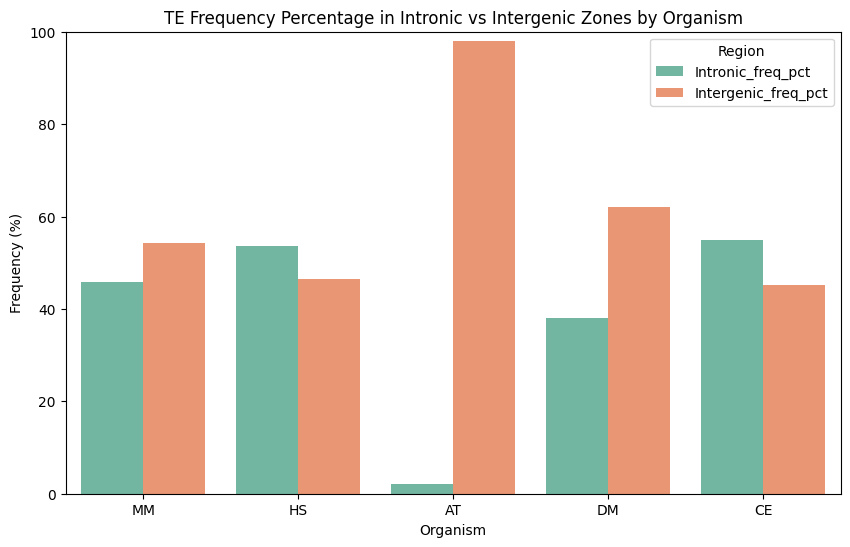

In [116]:
df['Intronic_freq'] = df[['SINE_intronic_freq', 'LINE_intronic_freq', 'LTR_intronic_freq', 'DNA_intronic_freq']].sum(axis=1)
df['Intergenic_freq'] = df[['SINE_intergenic_freq', 'LINE_intergenic_freq', 'LTR_intergenic_freq', 'DNA_intergenic_freq']].sum(axis=1)

df['Total_freq'] = df['Intronic_freq'] + df['Intergenic_freq']

df['Intronic_freq_pct'] = (df['Intronic_freq'] / df['Total_freq']) * 100
df['Intergenic_freq_pct'] = (df['Intergenic_freq'] / df['Total_freq']) * 100

df = df.reset_index()

df_long = df.melt(id_vars='index', value_vars=['Intronic_freq_pct', 'Intergenic_freq_pct'], 
                  var_name='Region', value_name='Frequency')

df_long.rename(columns={'index': 'Organism'}, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='Organism', y='Frequency', hue='Region', data=df_long, palette='Set2')

plt.title('TE Frequency Percentage in Intronic vs Intergenic Zones by Organism')
plt.ylabel('Frequency (%)')
plt.xlabel('Organism')
plt.ylim(0, 100)
plt.legend(title='Region')
plt.show()

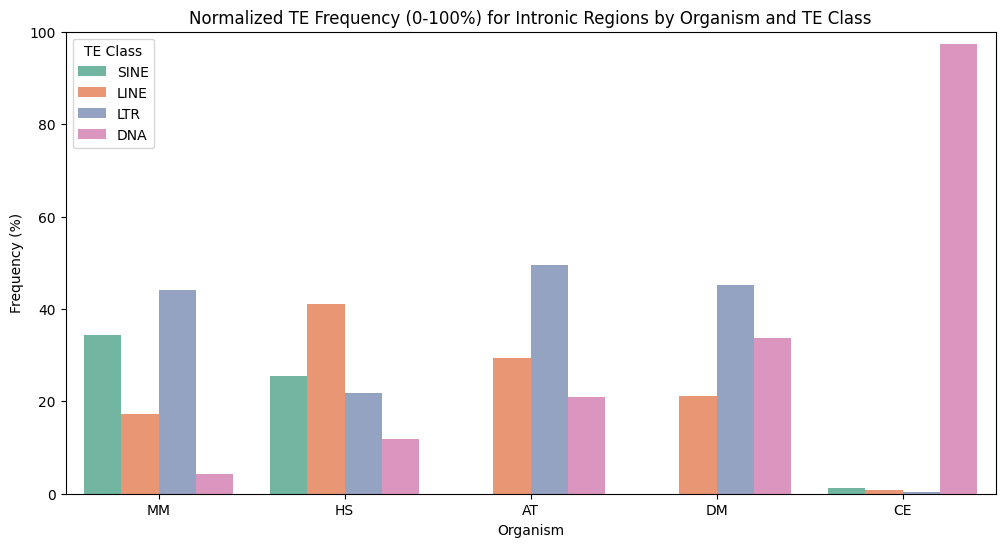

In [117]:
# Columns for intronic frequencies
freq_columns_intronic = ['SINE_intronic_freq', 'LINE_intronic_freq', 'LTR_intronic_freq', 'DNA_intronic_freq']

# Create a dataframe for intronic regions
df_intronic = df[freq_columns_intronic].copy()
df_intronic['Region'] = 'Intronic'
df_intronic['Organism'] = organism_names  # Assuming the organism names are the index of df

# Rename columns to represent TE classes
df_intronic.columns = ['SINE', 'LINE', 'LTR', 'DNA', 'Region', 'Organism']

# Melt the dataframe to long format
df_long_intronic = df_intronic.melt(id_vars=['Organism', 'Region'], var_name='TE_Class', value_name='Frequency')

# Normalize frequencies so that the total frequency for each organism sums to 100%
df_long_intronic['Total_Frequency'] = df_long_intronic.groupby('Organism')['Frequency'].transform('sum')
df_long_intronic['Frequency_pct'] = (df_long_intronic['Frequency'] / df_long_intronic['Total_Frequency']) * 100

# Plot the barplot for intronic regions
plt.figure(figsize=(12, 6))
sns.barplot(x='Organism', y='Frequency_pct', hue='TE_Class', data=df_long_intronic, palette='Set2', dodge=True)

# Customize the plot
plt.title('Normalized TE Frequency (0-100%) for Intronic Regions by Organism and TE Class')
plt.ylabel('Frequency (%)')
plt.xlabel('Organism')
plt.ylim(0, 100)  # Adjust y-axis to represent percentages
plt.legend(title='TE Class')
plt.xticks(rotation=0)
plt.show()


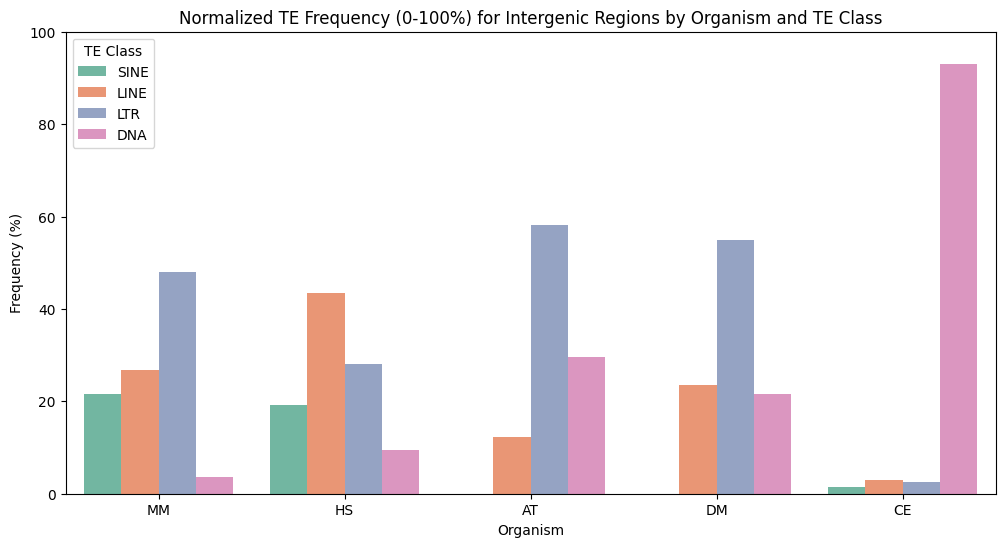

In [118]:
# Columns for intergenic frequencies
freq_columns_intergenic = ['SINE_intergenic_freq', 'LINE_intergenic_freq', 'LTR_intergenic_freq', 'DNA_intergenic_freq']

# Create a dataframe for intergenic regions
df_intergenic = df[freq_columns_intergenic].copy()
df_intergenic['Region'] = 'Intergenic'
df_intergenic['Organism'] = organism_names  # Assuming the organism names are the index of df

# Rename columns to represent TE classes
df_intergenic.columns = ['SINE', 'LINE', 'LTR', 'DNA', 'Region', 'Organism']

# Melt the dataframe to long format
df_long_intergenic = df_intergenic.melt(id_vars=['Organism', 'Region'], var_name='TE_Class', value_name='Frequency')

# Normalize frequencies so that the total frequency for each organism sums to 100%
df_long_intergenic['Total_Frequency'] = df_long_intergenic.groupby('Organism')['Frequency'].transform('sum')
df_long_intergenic['Frequency_pct'] = (df_long_intergenic['Frequency'] / df_long_intergenic['Total_Frequency']) * 100

# Plot the barplot for intergenic regions
plt.figure(figsize=(12, 6))
sns.barplot(x='Organism', y='Frequency_pct', hue='TE_Class', data=df_long_intergenic, palette='Set2', dodge=True)

# Customize the plot
plt.title('Normalized TE Frequency (0-100%) for Intergenic Regions by Organism and TE Class')
plt.ylabel('Frequency (%)')
plt.xlabel('Organism')
plt.ylim(0, 100)  # Adjust y-axis to represent percentages
plt.legend(title='TE Class')
plt.xticks(rotation=0)
plt.show()

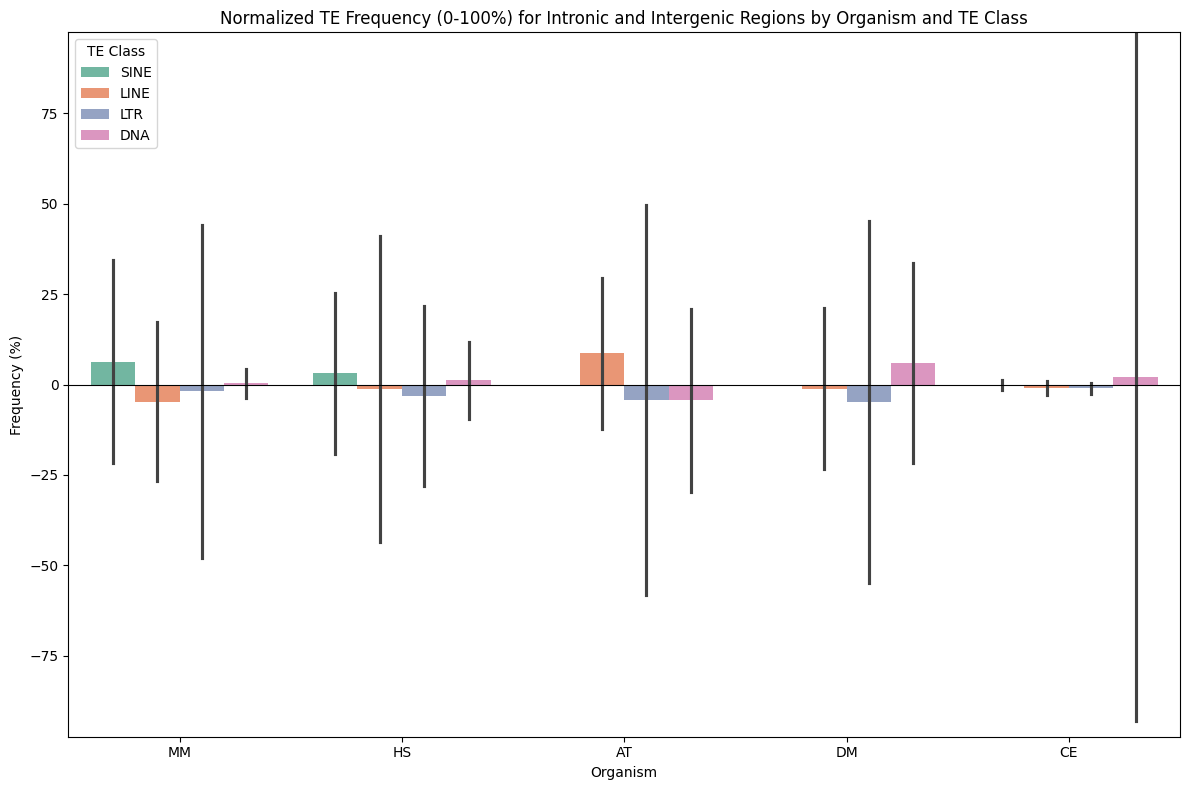

In [119]:
# Combine the intronic and intergenic data into one DataFrame

# Add a flag to differentiate between the two regions
df_long_intronic['Region_Type'] = 'Intronic'
df_long_intergenic['Region_Type'] = 'Intergenic'

# Combine both datasets into one
df_combined = pd.concat([df_long_intronic, df_long_intergenic])

# Make the 'Intergenic' frequencies negative to reflect them along the X-axis
df_combined.loc[df_combined['Region_Type'] == 'Intergenic', 'Frequency_pct'] *= -1

# Plot the combined data
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Organism', 
    y='Frequency_pct', 
    hue='TE_Class', 
    data=df_combined, 
    palette='Set2', 
    dodge=True
)

# Customize the plot
plt.title('Normalized TE Frequency (0-100%) for Intronic and Intergenic Regions by Organism and TE Class')
plt.ylabel('Frequency (%)')
plt.xlabel('Organism')

# Set the y-axis limits symmetrically around zero to give a mirror effect
max_y = df_combined['Frequency_pct'].abs().max()
plt.ylim(-max_y, max_y)

# Add horizontal lines at y=0 for the X-axis
plt.axhline(0, color='black', linewidth=0.8)

# Customize legend and ticks
plt.legend(title='TE Class')
plt.xticks(rotation=0)

# Show the plot
plt.tight_layout()
plt.show()


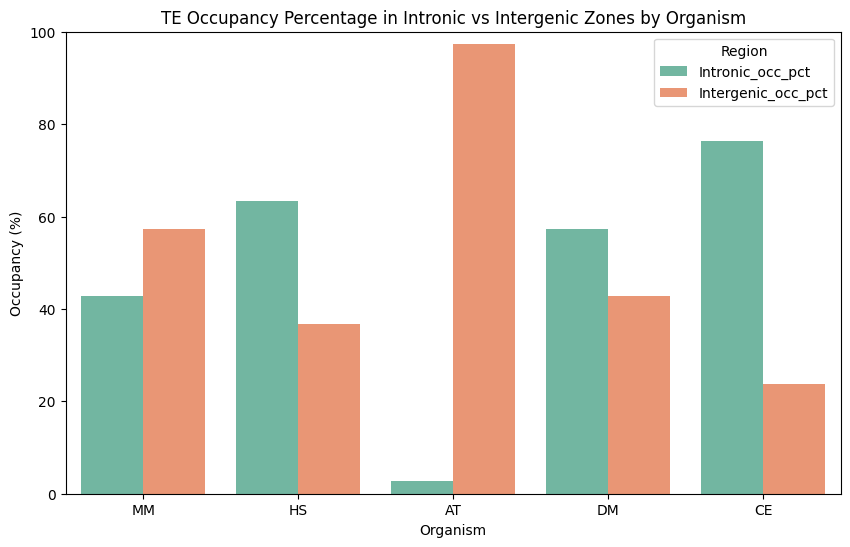

In [120]:
df['Intronic_occ'] = df[['SINE_occ_intronic', 'LINE_occ_intronic', 'LTR_occ_intronic', 'DNA_occ_intronic']].sum(axis=1)
df['Intergenic_occ'] = df[['SINE_occ_intergenic', 'LINE_occ_intergenic', 'LTR_occ_intergenic', 'DNA_occ_intergenic']].sum(axis=1)

df['Total_occ'] = df['Intronic_occ'] + df['Intergenic_occ']

df['Intronic_occ_pct'] = (df['Intronic_occ'] / df['Total_occ']) * 100
df['Intergenic_occ_pct'] = (df['Intergenic_occ'] / df['Total_occ']) * 100

df = df.reset_index()

df_long = df.melt(id_vars='index', value_vars=['Intronic_occ_pct', 'Intergenic_occ_pct'], 
                  var_name='Region', value_name='Occupancy')

df_long.rename(columns={'index': 'Organism'}, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='Organism', y='Occupancy', hue='Region', data=df_long, palette='Set2')

plt.title('TE Occupancy Percentage in Intronic vs Intergenic Zones by Organism')
plt.ylabel('Occupancy (%)')
plt.xlabel('Organism')
plt.ylim(0, 100)
plt.legend(title='Region')
plt.show()

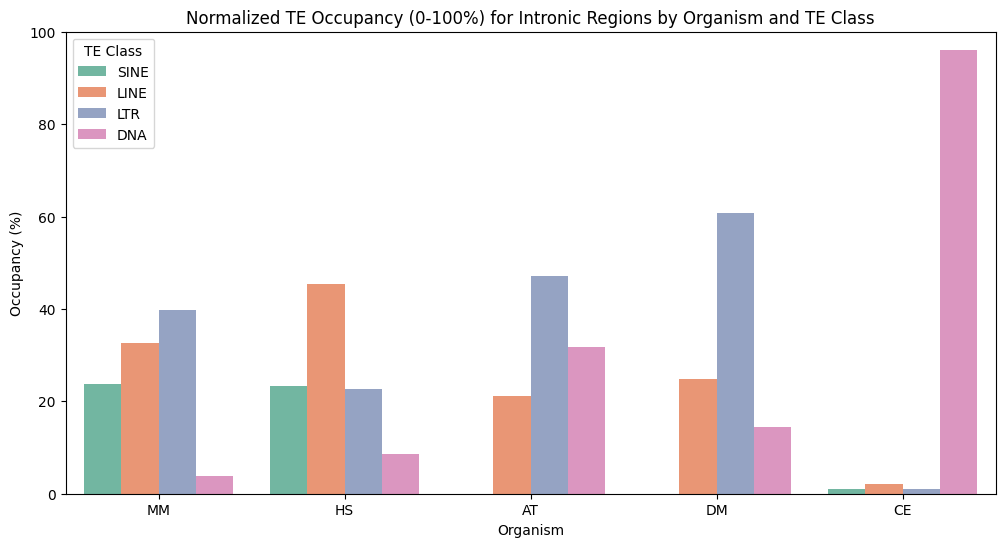

In [121]:
# Step 2: Select the columns related to occupancies for intronic regions
occ_columns_intronic = ['SINE_occ_intronic', 'LINE_occ_intronic', 'LTR_occ_intronic', 'DNA_occ_intronic']

# Step 3: Create a DataFrame for intronic regions
df_intronic = df[occ_columns_intronic].copy()
df_intronic['Region'] = 'Intronic'
df_intronic['Organism'] = organism_names  # Assuming organism names are the index of df

# Step 4: Rename columns to represent the TE classes
df_intronic.columns = ['SINE', 'LINE', 'LTR', 'DNA', 'Region', 'Organism']

# Step 5: Melt the DataFrame into long format
df_long_intronic = df_intronic.melt(id_vars=['Organism', 'Region'], var_name='TE_Class', value_name='Occupancy')

# Step 6: Normalize occupancies so that the total occupancy for each organism sums to 100%
df_long_intronic['Total_Occupancy'] = df_long_intronic.groupby('Organism')['Occupancy'].transform('sum')
df_long_intronic['Occupancy_pct'] = (df_long_intronic['Occupancy'] / df_long_intronic['Total_Occupancy']) * 100

# Step 7: Create the barplot
plt.figure(figsize=(12, 6))
sns.barplot(x='Organism', y='Occupancy_pct', hue='TE_Class', data=df_long_intronic, palette='Set2', dodge=True)

# Step 8: Customize the plot
plt.title('Normalized TE Occupancy (0-100%) for Intronic Regions by Organism and TE Class')
plt.ylabel('Occupancy (%)')
plt.xlabel('Organism')
plt.ylim(0, 100)  # Adjust y-axis to represent percentages (0-100%)
plt.legend(title='TE Class')
plt.xticks(rotation=0)
plt.show()

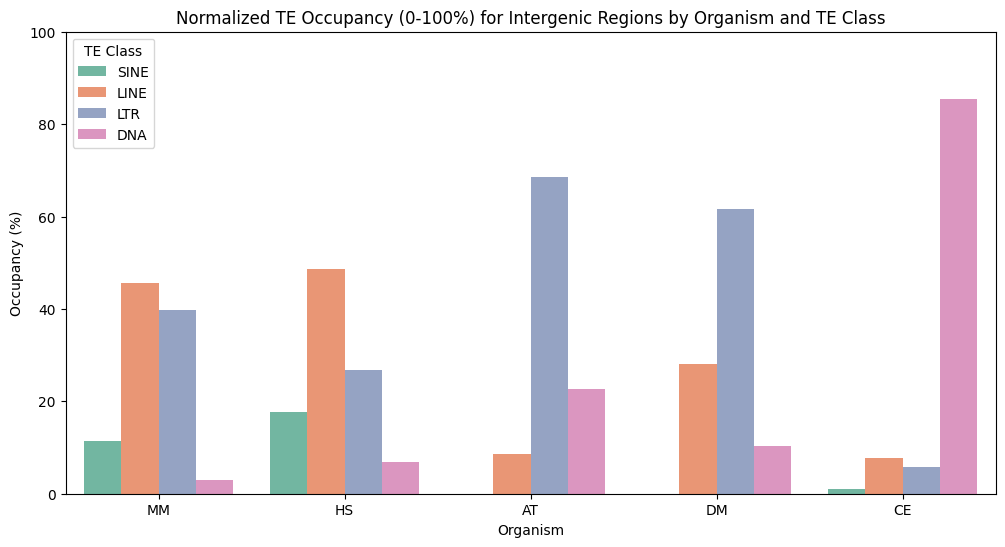

In [122]:
# Step 2: Select the columns related to occupancies for intergenic regions
occ_columns_intergenic = ['SINE_occ_intergenic', 'LINE_occ_intergenic', 'LTR_occ_intergenic', 'DNA_occ_intergenic']

# Step 3: Create a DataFrame for intergenic regions
df_intergenic = df[occ_columns_intergenic].copy()
df_intergenic['Region'] = 'Intergenic'
df_intergenic['Organism'] = organism_names  # Assuming organism names are the index of df

# Step 4: Rename columns to represent the TE classes
df_intergenic.columns = ['SINE', 'LINE', 'LTR', 'DNA', 'Region', 'Organism']

# Step 5: Melt the DataFrame into long format
df_long_intergenic = df_intergenic.melt(id_vars=['Organism', 'Region'], var_name='TE_Class', value_name='Occupancy')

# Step 6: Normalize occupancies so that the total occupancy for each organism sums to 100%
df_long_intergenic['Total_Occupancy'] = df_long_intergenic.groupby('Organism')['Occupancy'].transform('sum')
df_long_intergenic['Occupancy_pct'] = (df_long_intergenic['Occupancy'] / df_long_intergenic['Total_Occupancy']) * 100

# Step 7: Create the barplot
plt.figure(figsize=(12, 6))
sns.barplot(x='Organism', y='Occupancy_pct', hue='TE_Class', data=df_long_intergenic, palette='Set2', dodge=True)

# Step 8: Customize the plot
plt.title('Normalized TE Occupancy (0-100%) for Intergenic Regions by Organism and TE Class')
plt.ylabel('Occupancy (%)')
plt.xlabel('Organism')
plt.ylim(0, 100)  # Adjust y-axis to represent percentages (0-100%)
plt.legend(title='TE Class')
plt.xticks(rotation=0)
plt.show()

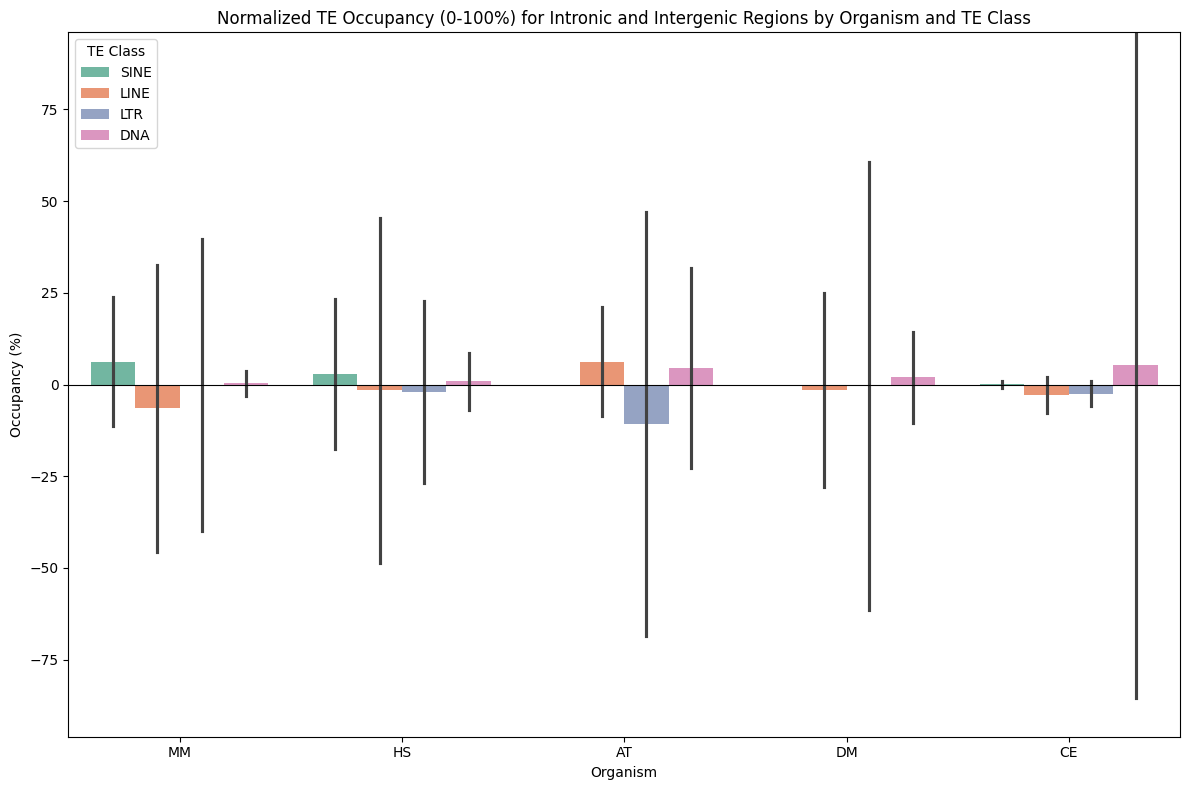

In [123]:
# Combine the intronic and intergenic data into one DataFrame

# Add a flag to differentiate between the two regions
df_long_intronic['Region_Type'] = 'Intronic'
df_long_intergenic['Region_Type'] = 'Intergenic'

# Combine both datasets into one
df_combined = pd.concat([df_long_intronic, df_long_intergenic])

# Make the 'Intergenic' occupancies negative to reflect them along the X-axis
df_combined.loc[df_combined['Region_Type'] == 'Intergenic', 'Occupancy_pct'] *= -1

# Plot the combined data
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Organism', 
    y='Occupancy_pct', 
    hue='TE_Class', 
    data=df_combined, 
    palette='Set2', 
    dodge=True
)

# Customize the plot
plt.title('Normalized TE Occupancy (0-100%) for Intronic and Intergenic Regions by Organism and TE Class')
plt.ylabel('Occupancy (%)')
plt.xlabel('Organism')

# Set the y-axis limits symmetrically around zero to give a mirror effect
max_y = df_combined['Occupancy_pct'].abs().max()
plt.ylim(-max_y, max_y)

# Add horizontal lines at y=0 for the X-axis
plt.axhline(0, color='black', linewidth=0.8)

# Customize legend and ticks
plt.legend(title='TE Class')
plt.xticks(rotation=0)

# Show the plot
plt.tight_layout()
plt.show()

Matriz de correlaciones, DATA NORMALIZADA! PERO POR COLUMNA EN VEZ DE POR FILA!
O sea, tomo la columna de los largos y la normalizo (por columna)
Por fila, es normalizar los largos de manera individual para cada organismo, y luego meterla al dataframe

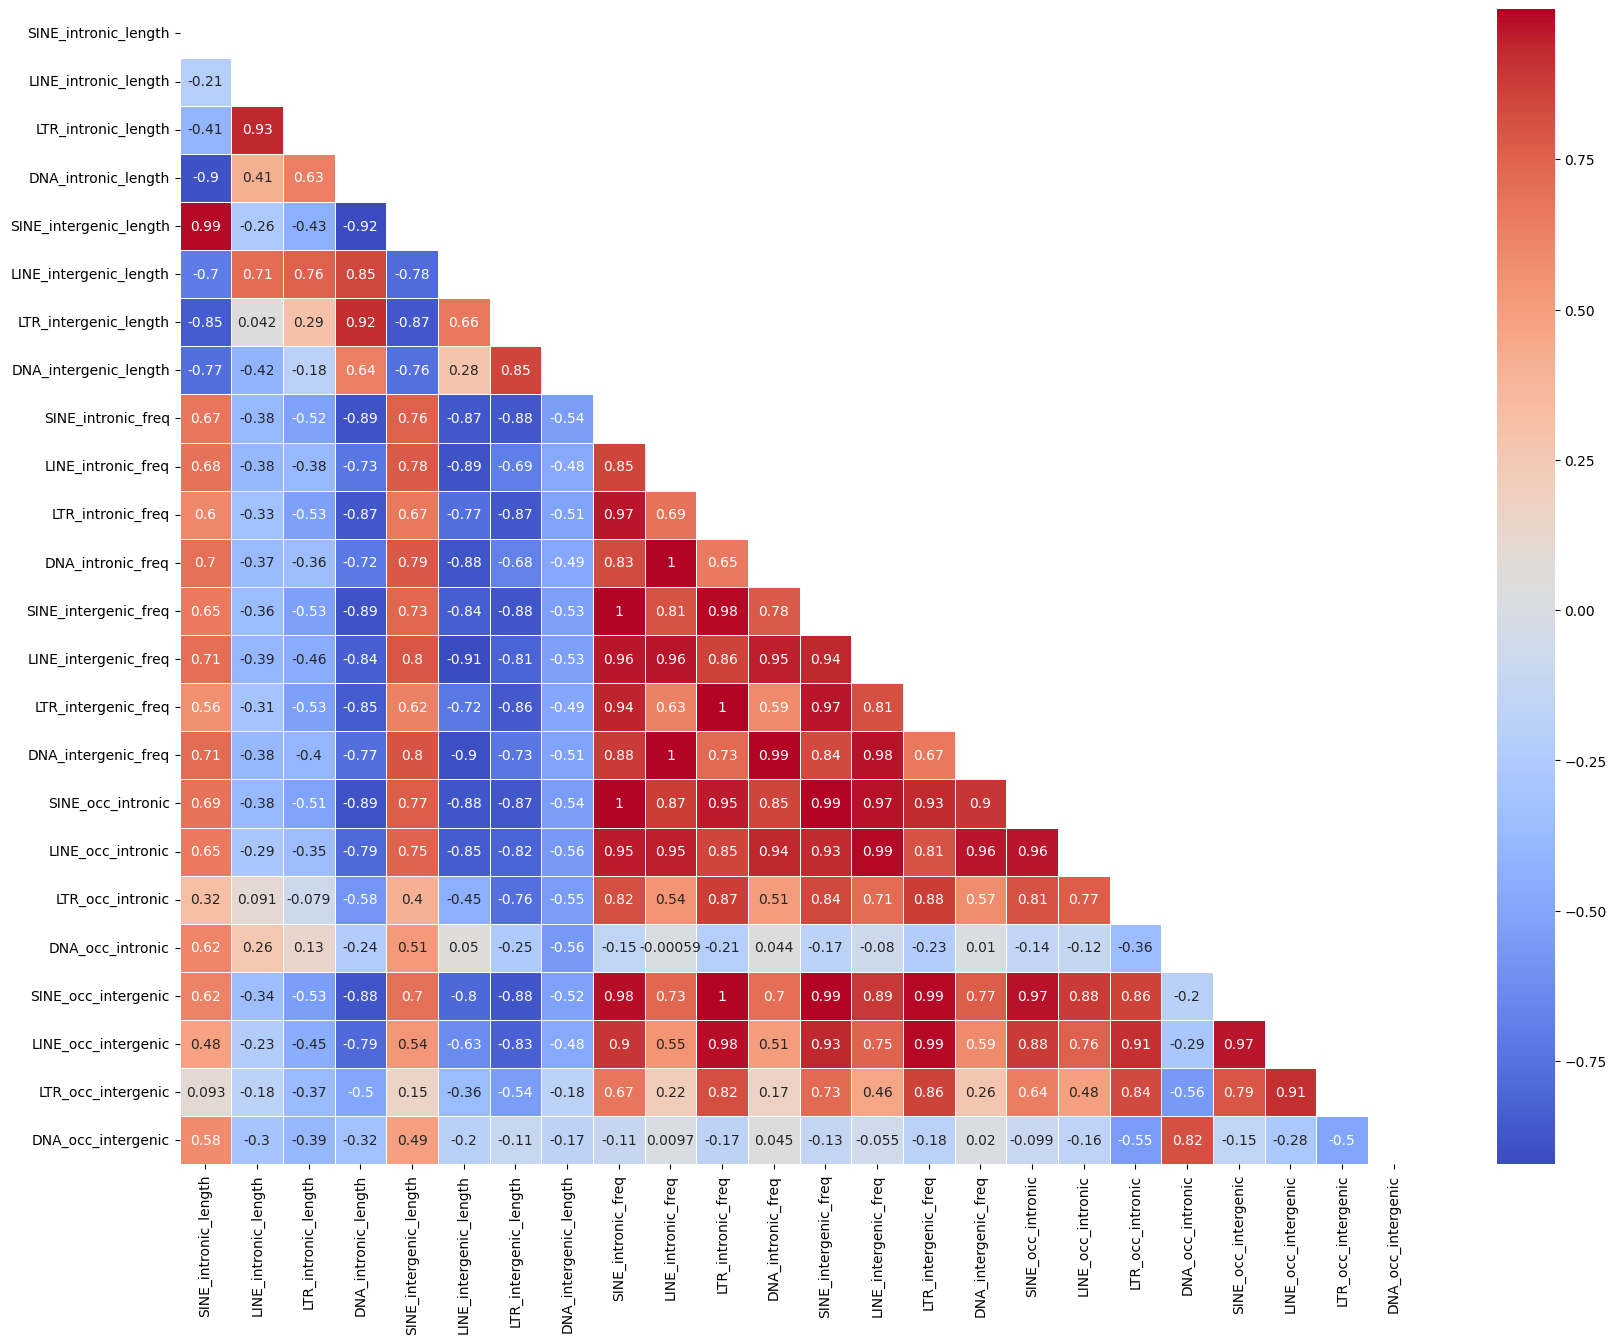

In [124]:
df_corr_mat = all_df.copy()

df_corr_mat['SINE_intronic_length'] = (df_corr_mat['SINE_intronic_length'] - df_corr_mat['SINE_intronic_length'].min()) / (df_corr_mat['SINE_intronic_length'].max() - df_corr_mat['SINE_intronic_length'].min())
df_corr_mat['LINE_intronic_length'] = (df_corr_mat['LINE_intronic_length'] - df_corr_mat['LINE_intronic_length'].min()) / (df_corr_mat['LINE_intronic_length'].max() - df_corr_mat['LINE_intronic_length'].min())
df_corr_mat['LTR_intronic_length'] = (df_corr_mat['LTR_intronic_length'] - df_corr_mat['LTR_intronic_length'].min()) / (df_corr_mat['LTR_intronic_length'].max() - df_corr_mat['LTR_intronic_length'].min())
df_corr_mat['DNA_intronic_length'] = (df_corr_mat['DNA_intronic_length'] - df_corr_mat['DNA_intronic_length'].min()) / (df_corr_mat['DNA_intronic_length'].max() - df_corr_mat['DNA_intronic_length'].min())

df_corr_mat['SINE_intergenic_length'] = (df_corr_mat['SINE_intergenic_length'] - df_corr_mat['SINE_intergenic_length'].min()) / (df_corr_mat['SINE_intergenic_length'].max() - df_corr_mat['SINE_intergenic_length'].min())
df_corr_mat['LINE_intergenic_length'] = (df_corr_mat['LINE_intergenic_length'] - df_corr_mat['LINE_intergenic_length'].min()) / (df_corr_mat['LINE_intergenic_length'].max() - df_corr_mat['LINE_intergenic_length'].min())
df_corr_mat['LTR_intergenic_length'] = (df_corr_mat['LTR_intergenic_length'] - df_corr_mat['LTR_intergenic_length'].min()) / (df_corr_mat['LTR_intergenic_length'].max() - df_corr_mat['LTR_intergenic_length'].min())
df_corr_mat['DNA_intergenic_length'] = (df_corr_mat['DNA_intergenic_length'] - df_corr_mat['DNA_intergenic_length'].min()) / (df_corr_mat['DNA_intergenic_length'].max() - df_corr_mat['DNA_intergenic_length'].min())

corr_matrix = df_corr_mat.corr()

plt.figure(figsize=(20, 15))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, mask=mask)

plt.show()

In [125]:
all_df.columns.tolist()

['SINE_intronic_length',
 'LINE_intronic_length',
 'LTR_intronic_length',
 'DNA_intronic_length',
 'SINE_intergenic_length',
 'LINE_intergenic_length',
 'LTR_intergenic_length',
 'DNA_intergenic_length',
 'SINE_intronic_freq',
 'LINE_intronic_freq',
 'LTR_intronic_freq',
 'DNA_intronic_freq',
 'SINE_intergenic_freq',
 'LINE_intergenic_freq',
 'LTR_intergenic_freq',
 'DNA_intergenic_freq',
 'SINE_occ_intronic',
 'LINE_occ_intronic',
 'LTR_occ_intronic',
 'DNA_occ_intronic',
 'SINE_occ_intergenic',
 'LINE_occ_intergenic',
 'LTR_occ_intergenic',
 'DNA_occ_intergenic']

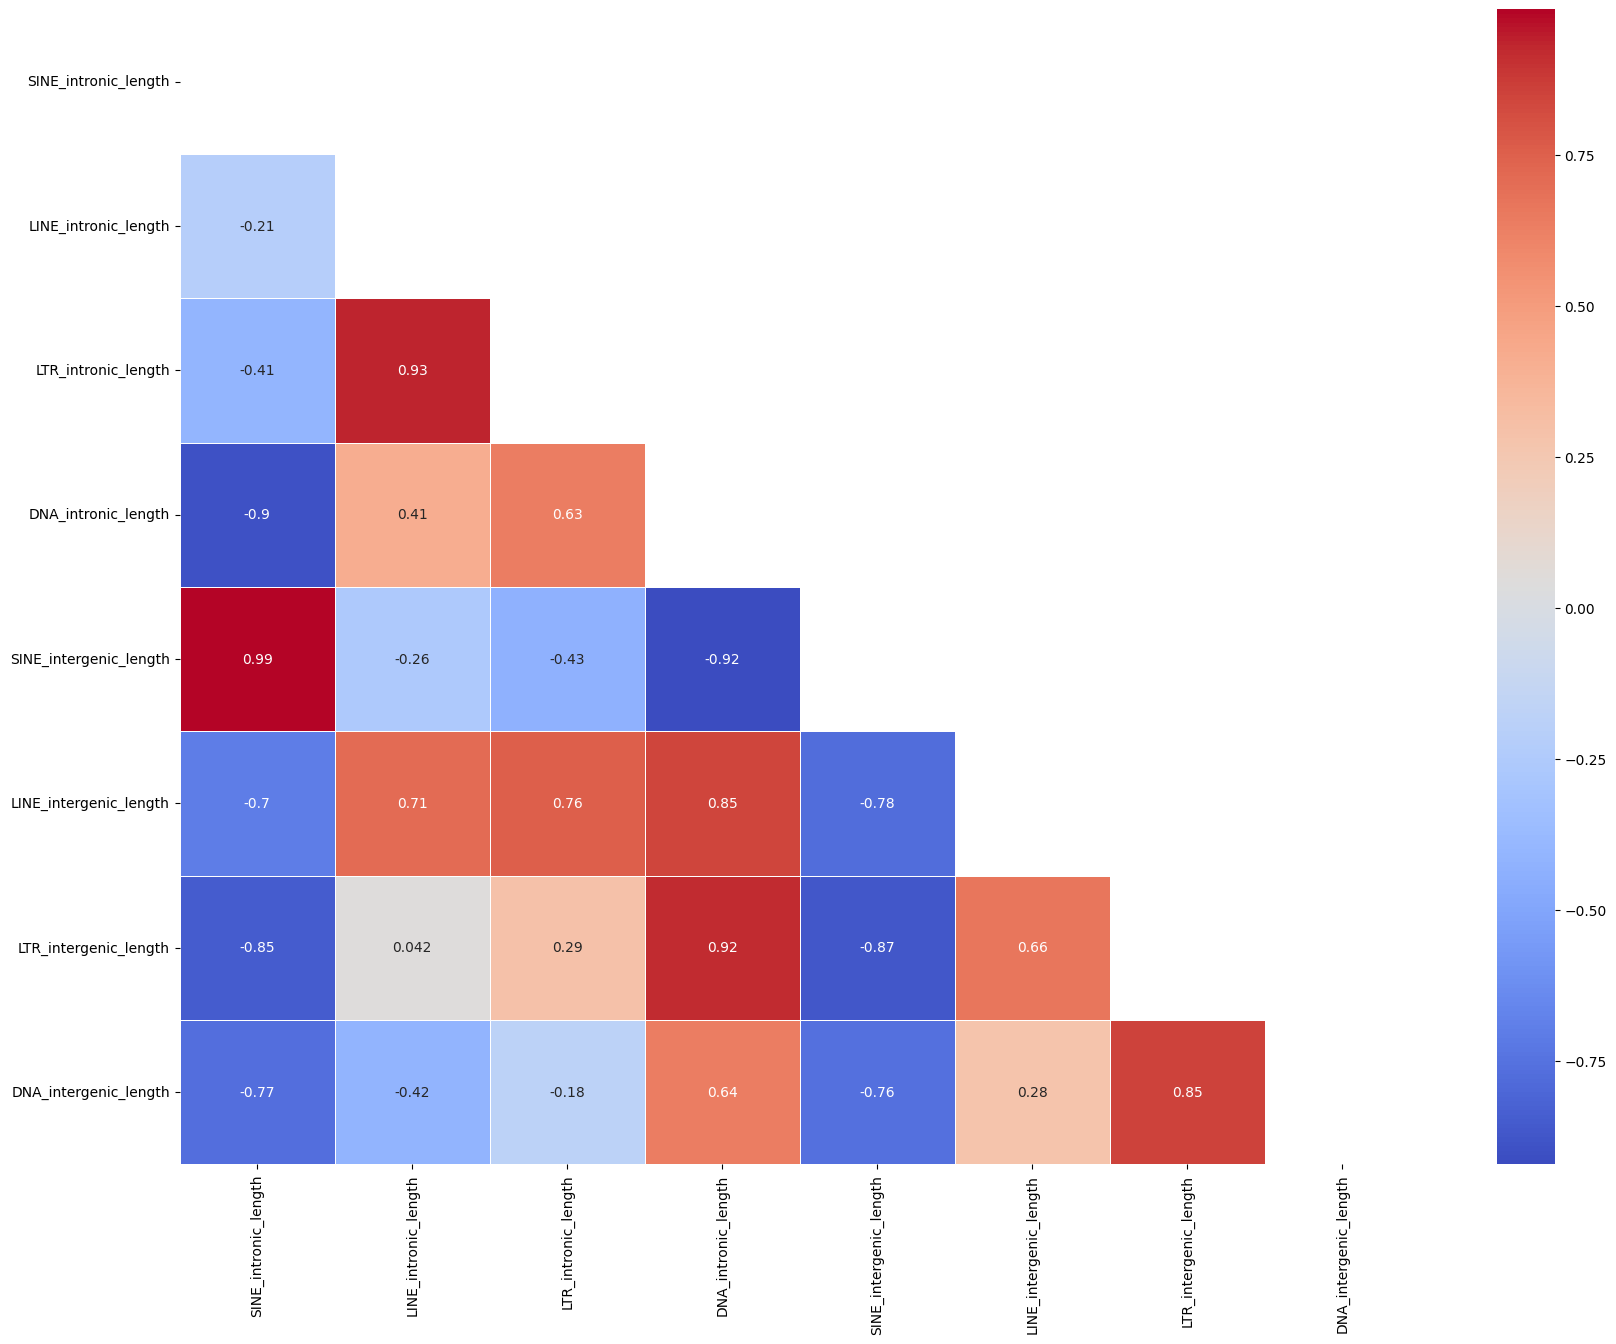

In [126]:
temp_df = df_corr_mat[['SINE_intronic_length',
 'LINE_intronic_length',
 'LTR_intronic_length',
 'DNA_intronic_length',
 'SINE_intergenic_length',
 'LINE_intergenic_length',
 'LTR_intergenic_length',
 'DNA_intergenic_length',]]

corr_matrix = temp_df.corr()

plt.figure(figsize=(20, 15))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, mask=mask)

plt.show()

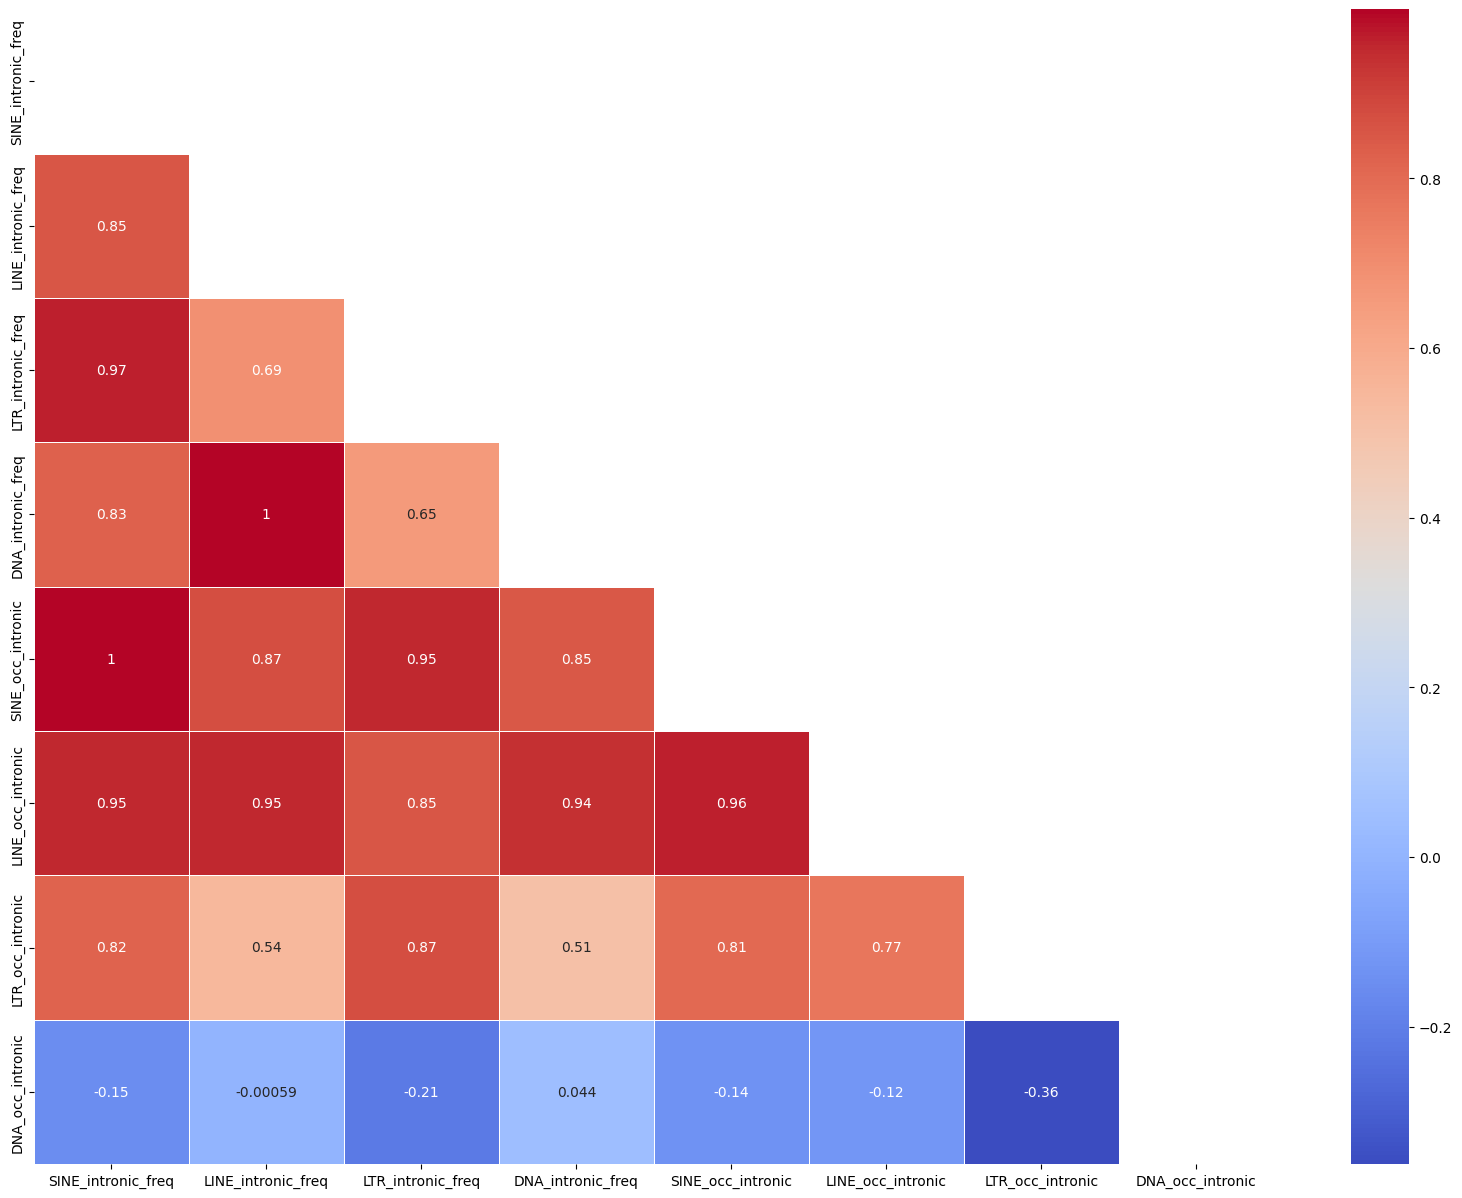

In [127]:
temp_df = df_corr_mat[[
 'SINE_intronic_freq',
 'LINE_intronic_freq',
 'LTR_intronic_freq',
 'DNA_intronic_freq',
 'SINE_occ_intronic',
 'LINE_occ_intronic',
 'LTR_occ_intronic',
 'DNA_occ_intronic',]]

corr_matrix = temp_df.corr()

plt.figure(figsize=(20, 15))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, mask=mask)

plt.show()

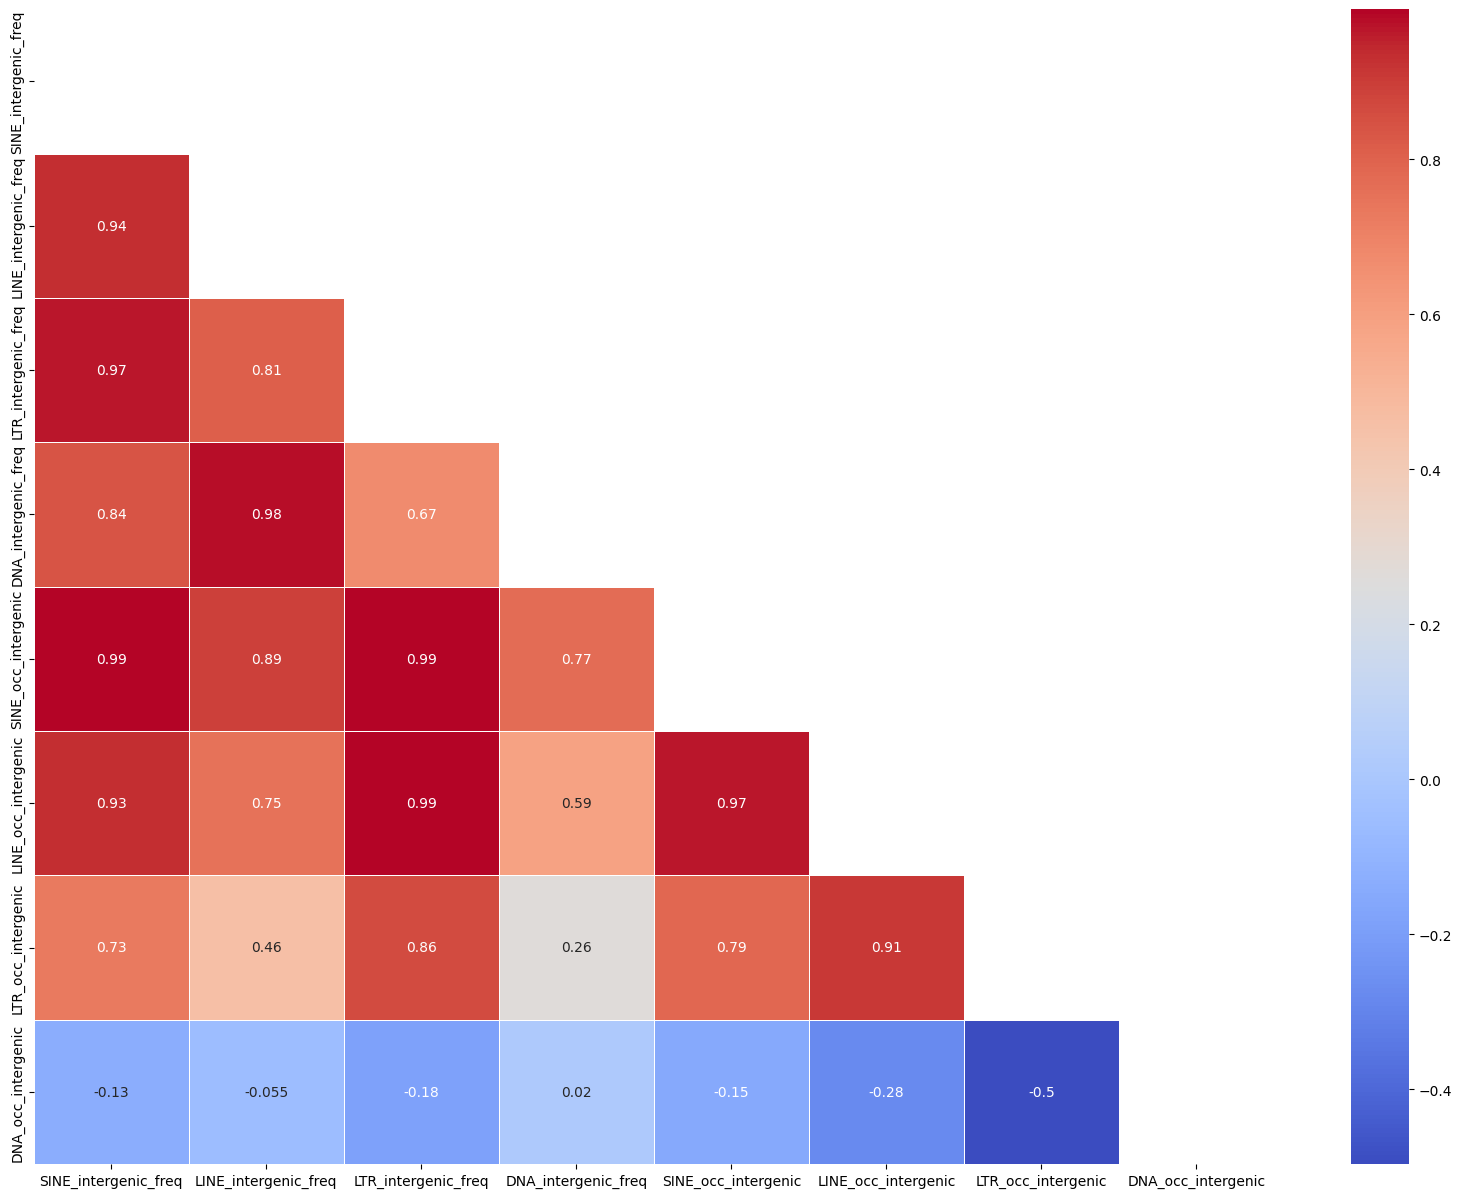

In [128]:
temp_df = df_corr_mat[[
 'SINE_intergenic_freq',
 'LINE_intergenic_freq',
 'LTR_intergenic_freq',
 'DNA_intergenic_freq',
 'SINE_occ_intergenic',
 'LINE_occ_intergenic',
 'LTR_occ_intergenic',
 'DNA_occ_intergenic',]]

corr_matrix = temp_df.corr()

plt.figure(figsize=(20, 15))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, mask=mask)

plt.show()

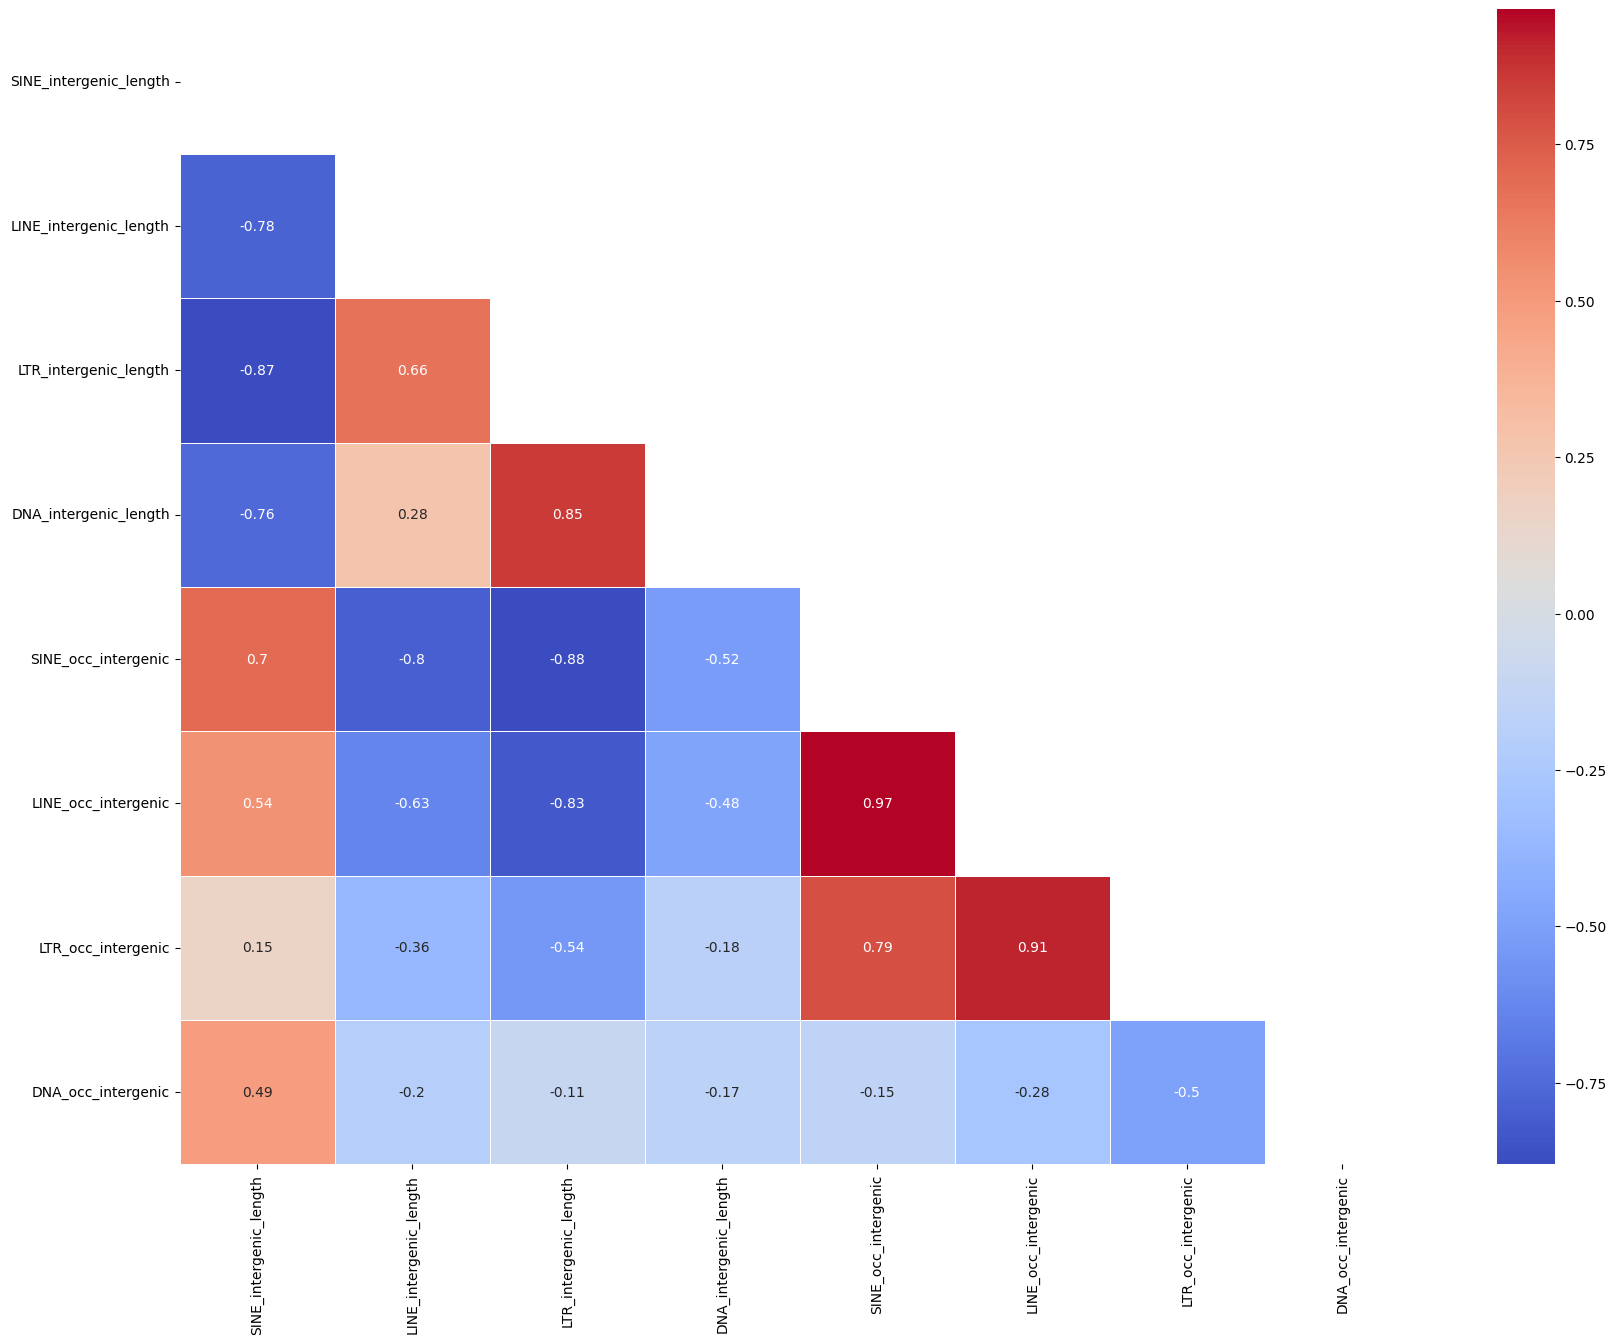

In [129]:
temp_df = df_corr_mat[[
 'SINE_intergenic_length',
 'LINE_intergenic_length',
 'LTR_intergenic_length',
 'DNA_intergenic_length',
 'SINE_occ_intergenic',
 'LINE_occ_intergenic',
 'LTR_occ_intergenic',
 'DNA_occ_intergenic',]]

corr_matrix = temp_df.corr()

plt.figure(figsize=(20, 15))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, mask=mask)

plt.show()

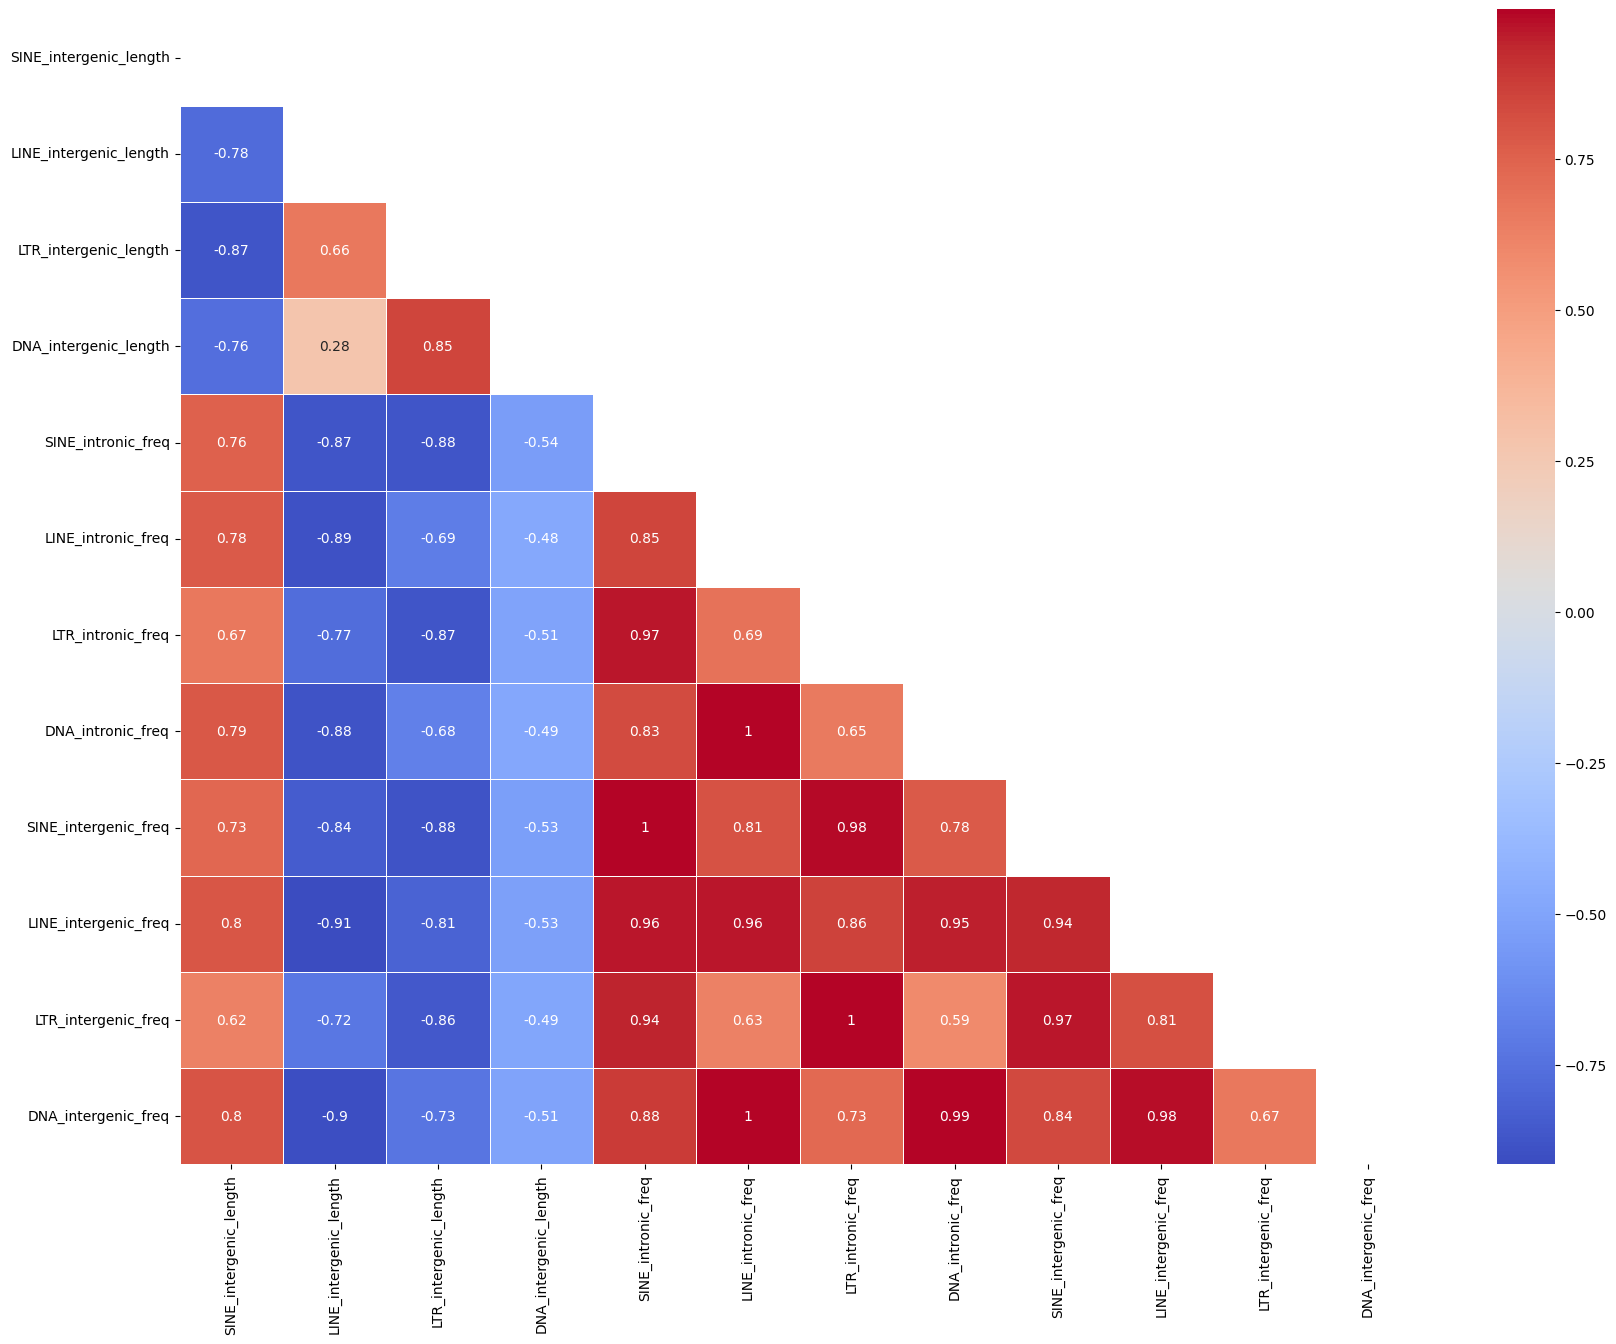

In [130]:
temp_df = df_corr_mat[[
 'SINE_intergenic_length',
 'LINE_intergenic_length',
 'LTR_intergenic_length',
 'DNA_intergenic_length',
 'SINE_intronic_freq',
 'LINE_intronic_freq',
 'LTR_intronic_freq',
 'DNA_intronic_freq',
 'SINE_intergenic_freq',
 'LINE_intergenic_freq',
 'LTR_intergenic_freq',
 'DNA_intergenic_freq',]]

corr_matrix = temp_df.corr()

plt.figure(figsize=(20, 15))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, mask=mask)

plt.show()

### Preferencias intronicas cromosoma a cromosoma en cada organismo

Mus musculus

In [131]:
mm_intronic_chr = df_per_chr(mm_occs_per_chr_intronic)
print(mm_intronic_chr)

                 SINE      LINE       LTR       DNA
NC_000067.7  0.086717  0.142495  0.158869  0.015459
NC_000068.8  0.098502  0.122647  0.158535  0.016138
NC_000069.7  0.079791  0.161116  0.149818  0.014927
NC_000070.7  0.108150  0.133577  0.169073  0.014609
NC_000071.7  0.115158  0.111559  0.174263  0.014174
NC_000072.7  0.088598  0.128695  0.149676  0.016696
NC_000073.7  0.113042  0.136685  0.174887  0.014798
NC_000074.7  0.095624  0.122190  0.163402  0.014688
NC_000075.7  0.116943  0.109668  0.165099  0.016179
NC_000076.7  0.086804  0.135600  0.163026  0.016040
NC_000077.7  0.135114  0.088166  0.174241  0.016356
NC_000078.7  0.104496  0.126750  0.177635  0.017473
NC_000079.7  0.079629  0.137300  0.160046  0.015863
NC_000080.7  0.079640  0.140046  0.155393  0.015726
NC_000081.7  0.084400  0.131522  0.159941  0.015194
NC_000082.7  0.084520  0.125931  0.155233  0.015959
NC_000083.7  0.103002  0.111973  0.172607  0.014476
NC_000084.7  0.084814  0.156821  0.159742  0.015741
NC_000085.7 

In [132]:
mm_intergenic_chr = df_per_chr(mm_occs_per_chr_intergenic)
print(mm_intergenic_chr)

                 SINE      LINE       LTR       DNA
NC_000067.7  0.055525  0.249576  0.202339  0.012922
NC_000068.8  0.060928  0.216760  0.186032  0.013289
NC_000069.7  0.046766  0.267592  0.187520  0.013053
NC_000070.7  0.062780  0.238585  0.201479  0.012814
NC_000071.7  0.064951  0.211389  0.201173  0.011881
NC_000072.7  0.057204  0.250013  0.192297  0.012918
NC_000073.7  0.065448  0.247820  0.218848  0.011711
NC_000074.7  0.056031  0.202119  0.184508  0.012134
NC_000075.7  0.067854  0.204070  0.199571  0.014264
NC_000076.7  0.053054  0.220068  0.202595  0.013680
NC_000077.7  0.083630  0.159181  0.201178  0.013321
NC_000078.7  0.056222  0.222763  0.190607  0.014050
NC_000079.7  0.050458  0.216176  0.202628  0.013137
NC_000080.7  0.048253  0.250040  0.190195  0.013125
NC_000081.7  0.047913  0.216136  0.190748  0.012192
NC_000082.7  0.047730  0.219711  0.191868  0.012712
NC_000083.7  0.054879  0.224036  0.203496  0.011201
NC_000084.7  0.058444  0.245551  0.204970  0.014196
NC_000085.7 

In [133]:
mm_pref_chr = df_pref_per_chr(mm_occs_per_chr_intronic, mm_occs_per_chr_intergenic)
print(mm_pref_chr)

                 SINE      LINE       LTR       DNA
NC_000067.7  1.561765  0.570950  0.785166  1.196385
NC_000068.8  1.616693  0.565822  0.852187  1.214388
NC_000069.7  1.706168  0.602095  0.798945  1.143571
NC_000070.7  1.722677  0.559872  0.839159  1.140108
NC_000071.7  1.772993  0.527741  0.866233  1.192966
NC_000072.7  1.548811  0.514753  0.778359  1.292478
NC_000073.7  1.727217  0.551549  0.799126  1.263679
NC_000074.7  1.706616  0.604545  0.885604  1.210509
NC_000075.7  1.723434  0.537404  0.827271  1.134239
NC_000076.7  1.636159  0.616175  0.804689  1.172468
NC_000077.7  1.615614  0.553873  0.866100  1.227894
NC_000078.7  1.858624  0.568989  0.931946  1.243655
NC_000079.7  1.578110  0.635130  0.789850  1.207484
NC_000080.7  1.650480  0.560092  0.817021  1.198139
NC_000081.7  1.761512  0.608517  0.838491  1.246212
NC_000082.7  1.770800  0.573168  0.809059  1.255398
NC_000083.7  1.876902  0.499798  0.848207  1.292412
NC_000084.7  1.451201  0.638649  0.779340  1.108874
NC_000085.7 

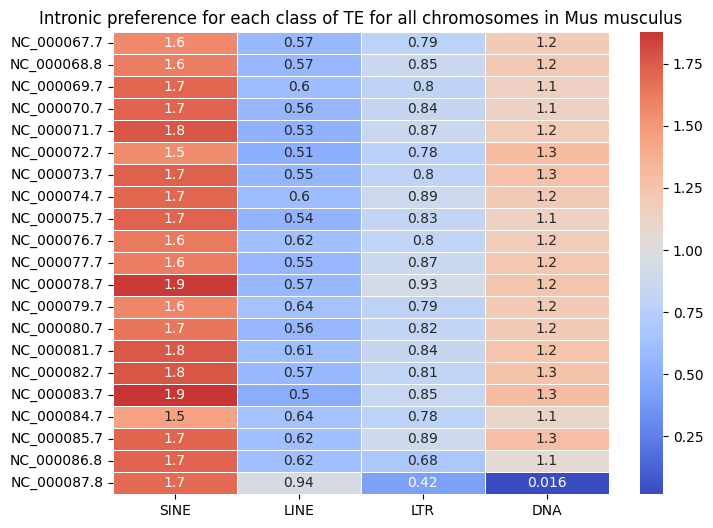

In [134]:
plt.figure(figsize=(8,6))
sns.heatmap(mm_pref_chr, annot=True, cmap="coolwarm", linewidth=0.5, center=1)
plt.title("Intronic preference for each class of TE for all chromosomes in Mus musculus")
plt.show()

Homo Sapiens

In [135]:
hs_intronic_chr = df_per_chr(hs_occs_per_chr_intronic)
print(hs_intronic_chr)

                  SINE      LINE       LTR       DNA
NC_000001.11  0.127918  0.241159  0.122145  0.043713
NC_000002.12  0.102451  0.235164  0.112364  0.046713
NC_000003.12  0.104607  0.238682  0.112623  0.047163
NC_000004.12  0.093547  0.244118  0.118843  0.043434
NC_000005.10  0.100982  0.242121  0.116561  0.046084
NC_000006.12  0.101935  0.232377  0.114098  0.046767
NC_000007.14  0.109127  0.235100  0.116885  0.044276
NC_000008.11  0.104756  0.236069  0.114046  0.042849
NC_000009.12  0.120669  0.239427  0.115337  0.044933
NC_000010.11  0.118851  0.228485  0.113421  0.045456
NC_000011.10  0.117113  0.242067  0.113089  0.042337
NC_000012.12  0.124573  0.239059  0.129075  0.045894
NC_000013.11  0.092110  0.223532  0.110741  0.042507
NC_000014.9   0.119884  0.246391  0.129041  0.046050
NC_000015.10  0.124439  0.251628  0.119621  0.046903
NC_000016.10  0.165780  0.213482  0.144027  0.045345
NC_000017.11  0.168415  0.224239  0.145071  0.044482
NC_000018.10  0.098577  0.221497  0.104778  0.

In [136]:
hs_intergenic_chr = df_per_chr(hs_occs_per_chr_intergenic)
print(hs_intergenic_chr)

                  SINE      LINE       LTR       DNA
NC_000001.11  0.104838  0.233218  0.133564  0.032627
NC_000002.12  0.100170  0.272500  0.144325  0.040850
NC_000003.12  0.083181  0.275589  0.158093  0.041165
NC_000004.12  0.091724  0.269315  0.159495  0.037945
NC_000005.10  0.082163  0.279557  0.151920  0.040045
NC_000006.12  0.088288  0.273297  0.152122  0.039847
NC_000007.14  0.100430  0.341819  0.158767  0.037552
NC_000008.11  0.119300  0.312166  0.176588  0.037337
NC_000009.12  0.069798  0.196186  0.113730  0.027704
NC_000010.11  0.129436  0.248412  0.142447  0.037731
NC_000011.10  0.200117  0.373235  0.198699  0.090569
NC_000012.12  0.141587  0.310550  0.164179  0.038383
NC_000013.11  0.052580  0.185154  0.111545  0.027872
NC_000014.9   0.060432  0.172301  0.106290  0.026348
NC_000015.10  0.095396  0.175676  0.118171  0.027160
NC_000016.10  0.138652  0.214275  0.129227  0.031010
NC_000017.11  0.193445  0.297042  0.154557  0.033836
NC_000018.10  0.071155  0.336088  0.126291  0.

In [137]:
hs_pref_chr = df_pref_per_chr(hs_occs_per_chr_intronic, hs_occs_per_chr_intergenic)
print(hs_pref_chr)

                  SINE      LINE       LTR       DNA
NC_000001.11  1.220144  1.034051  0.914506  1.339782
NC_000002.12  1.022777  0.862985  0.778549  1.143533
NC_000003.12  1.257581  0.866078  0.712383  1.145716
NC_000004.12  1.019873  0.906442  0.745121  1.144666
NC_000005.10  1.229056  0.866090  0.767248  1.150820
NC_000006.12  1.154567  0.850273  0.750043  1.173661
NC_000007.14  1.086590  0.687791  0.736200  1.179058
NC_000008.11  0.878085  0.756230  0.645830  1.147653
NC_000009.12  1.728814  1.220408  1.014131  1.621914
NC_000010.11  0.918222  0.919781  0.796235  1.204725
NC_000011.10  0.585223  0.648566  0.569145  0.467453
NC_000012.12  0.879835  0.769792  0.786184  1.195686
NC_000013.11  1.751816  1.207278  0.992789  1.525116
NC_000014.9   1.983789  1.429998  1.214043  1.747753
NC_000015.10  1.304443  1.432341  1.012268  1.726901
NC_000016.10  1.195655  0.996298  1.114530  1.462269
NC_000017.11  0.870611  0.754908  0.938620  1.314635
NC_000018.10  1.385382  0.659043  0.829650  1.

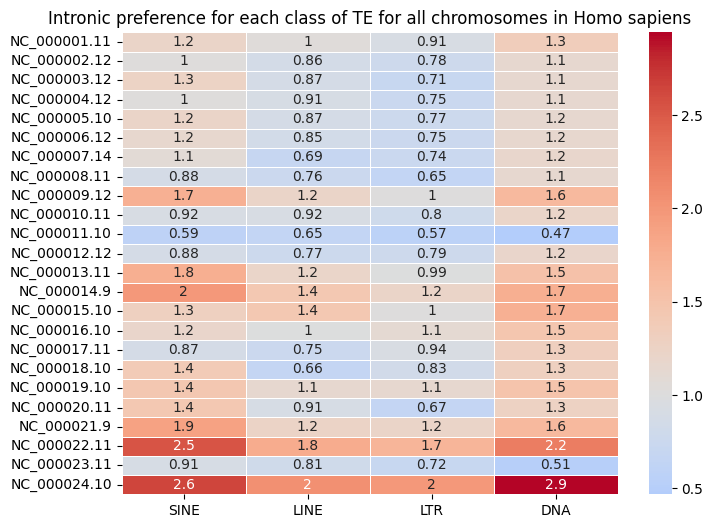

In [138]:
plt.figure(figsize=(8,6))
sns.heatmap(hs_pref_chr, annot=True, cmap="coolwarm", linewidth=0.5, center=1)
plt.title("Intronic preference for each class of TE for all chromosomes in Homo sapiens")
plt.show()

Arabidopsis Thaliana

In [139]:
at_intronic_chr = df_per_chr(at_occs_per_chr_intronic)
print(at_intronic_chr)

             SINE      LINE       LTR       DNA
NC_003070.9   0.0  0.000609  0.001449  0.001053
NC_003071.7   0.0  0.000672  0.001614  0.001039
NC_003074.8   0.0  0.000362  0.000840  0.000774
NC_003075.7   0.0  0.000604  0.001072  0.000735
NC_003076.8   0.0  0.000337  0.000576  0.000249
NC_037304.1   0.0  0.000000  0.021678  0.000000
NC_000932.1   0.0  0.000000  0.000000  0.000000


In [140]:
at_intergenic_chr = df_per_chr(at_occs_per_chr_intergenic)
print(at_intergenic_chr)

             SINE      LINE       LTR       DNA
NC_003070.9   0.0  0.006317  0.052362  0.017415
NC_003071.7   0.0  0.014678  0.076641  0.032312
NC_003074.8   0.0  0.009427  0.077431  0.027245
NC_003075.7   0.0  0.006874  0.093661  0.024197
NC_003076.8   0.0  0.008917  0.066461  0.020098
NC_037304.1   0.0  0.003265  0.032617  0.000000
NC_000932.1   0.0  0.000000  0.000000  0.000000


In [141]:
at_pref_chr = df_pref_per_chr(at_occs_per_chr_intronic, at_occs_per_chr_intergenic)
at_pref_chr.fillna(value=np.nan, inplace=True)
print(at_pref_chr)

             SINE      LINE       LTR       DNA
NC_003070.9   NaN  0.096476  0.027664  0.060441
NC_003071.7   NaN  0.045807  0.021060  0.032156
NC_003074.8   NaN  0.038422  0.010847  0.028401
NC_003075.7   NaN  0.087893  0.011445  0.030376
NC_003076.8   NaN  0.037823  0.008666  0.012407
NC_037304.1   NaN  0.000000  0.664631       NaN
NC_000932.1   NaN       NaN       NaN       NaN


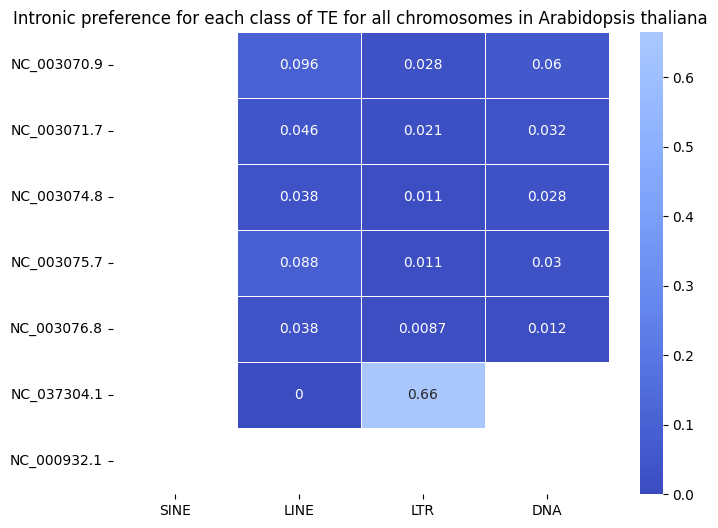

In [142]:
plt.figure(figsize=(8,6))
sns.heatmap(at_pref_chr, annot=True, cmap="coolwarm", linewidth=0.5, center=1)
plt.title("Intronic preference for each class of TE for all chromosomes in Arabidopsis thaliana")
plt.show()

Drosophila Melanogaster

In [143]:
dm_intronic_chr = df_per_chr(dm_occs_per_chr_intronic)
print(dm_intronic_chr)

             SINE      LINE       LTR       DNA
NC_004354.4   0.0  0.007229  0.050042  0.010473
NT_033779.5   0.0  0.017060  0.044236  0.013142
NT_033778.4   0.0  0.048598  0.097616  0.027454
NT_037436.4   0.0  0.038670  0.085609  0.021337
NT_033777.3   0.0  0.051128  0.111245  0.018957
NC_004353.4   0.0  0.041460  0.062325  0.208124
NC_024512.1   0.0  0.143116  0.489276  0.038074


In [144]:
dm_intergenic_chr = df_per_chr(dm_occs_per_chr_intergenic)
print(dm_intergenic_chr)

             SINE      LINE       LTR       DNA
NC_004354.4   0.0  0.045231  0.061309  0.011329
NT_033779.5   0.0  0.016977  0.054860  0.013631
NT_033778.4   0.0  0.055246  0.122288  0.029482
NT_037436.4   0.0  0.048718  0.103749  0.017433
NT_033777.3   0.0  0.017676  0.048692  0.007154
NC_004353.4   0.0  0.127567  0.017240  0.065916
NC_024512.1   0.0  0.164367  0.472523  0.057094


In [145]:
dm_pref_chr = df_pref_per_chr(dm_occs_per_chr_intronic, dm_occs_per_chr_intergenic)
dm_pref_chr.fillna(value=np.nan, inplace=True)
print(dm_pref_chr)

             SINE      LINE       LTR       DNA
NC_004354.4   NaN  0.159820  0.816222  0.924411
NT_033779.5   NaN  1.004898  0.806341  0.964147
NT_033778.4   NaN  0.879652  0.798247  0.931218
NT_037436.4   NaN  0.793757  0.825161  1.223894
NT_033777.3   NaN  2.892457  2.284695  2.649856
NC_004353.4   NaN  0.325007  3.615057  3.157422
NC_024512.1   NaN  0.870715  1.035453  0.666872


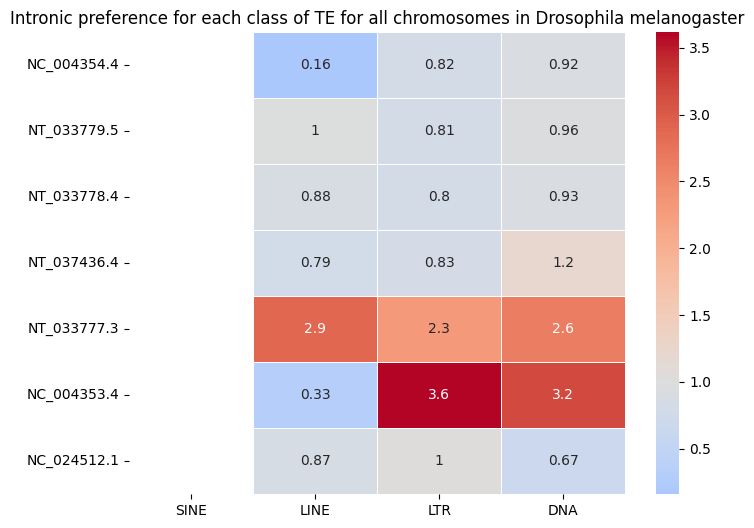

In [146]:
plt.figure(figsize=(8,6))
sns.heatmap(dm_pref_chr, annot=True, cmap="coolwarm", linewidth=0.5, center=1)
plt.title("Intronic preference for each class of TE for all chromosomes in Drosophila melanogaster")
plt.show()

Caenorhabditis elegans

In [147]:
ce_intronic_chr = df_per_chr(ce_occs_per_chr_intronic)
print(ce_intronic_chr)

                  SINE      LINE       LTR       DNA
NC_003279.8   0.000806  0.004072  0.000690  0.127066
NC_003280.10  0.000629  0.000944  0.000318  0.102533
NC_003281.10  0.000319  0.002469  0.000360  0.126652
NC_003282.8   0.000546  0.002757  0.003067  0.100001
NC_003283.11  0.000901  0.001709  0.001421  0.131303
NC_003284.9   0.003810  0.001874  0.000428  0.068544


In [148]:
ce_intergenic_chr = df_per_chr(ce_occs_per_chr_intergenic)
print(ce_intergenic_chr)

                  SINE      LINE       LTR       DNA
NC_003279.8   0.000347  0.003079  0.001791  0.045940
NC_003280.10  0.000255  0.003594  0.002215  0.049070
NC_003281.10  0.000258  0.002595  0.002352  0.041984
NC_003282.8   0.000296  0.004568  0.001054  0.047324
NC_003283.11  0.000505  0.004718  0.005049  0.050544
NC_003284.9   0.001300  0.005099  0.004938  0.035854


In [149]:
ce_pref_chr = df_pref_per_chr(ce_occs_per_chr_intronic, ce_occs_per_chr_intergenic)
ce_pref_chr.fillna(value=np.nan, inplace=True)
print(ce_pref_chr)

                  SINE      LINE       LTR       DNA
NC_003279.8   2.322227  1.322285  0.385079  2.765913
NC_003280.10  2.466564  0.262755  0.143349  2.089523
NC_003281.10  1.238742  0.951279  0.153179  3.016659
NC_003282.8   1.844085  0.603490  2.909806  2.113099
NC_003283.11  1.781763  0.362265  0.281519  2.597787
NC_003284.9   2.930635  0.367503  0.086587  1.911761


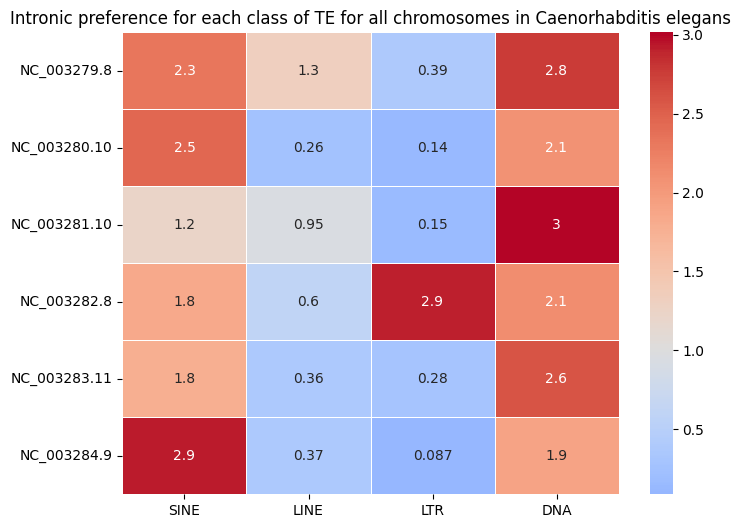

In [150]:
plt.figure(figsize=(8,6))
sns.heatmap(ce_pref_chr, annot=True, cmap="coolwarm", linewidth=0.5, center=1)
plt.title("Intronic preference for each class of TE for all chromosomes in Caenorhabditis elegans")
plt.show()

### Preferencias cromosoma a cromosoma, por frecuencia

Mus musculus

In [151]:
values_intronic = mm_freqs_per_chr_intronic.values()
keys = mm_freqs_per_chr_intronic.keys()

mm_freqs_intronic_chr = pd.DataFrame(data=values_intronic, index=keys, columns=titles)
print(mm_freqs_intronic_chr)

              SINE   LINE    LTR   DNA
NC_000067.7  55555  31621  75976  7728
NC_000068.8  65477  30670  82445  8313
NC_000069.7  37229  24651  51685  5265
NC_000070.7  55942  25244  68091  5953
NC_000071.7  60129  22350  74040  5993
NC_000072.7  45454  24534  58015  6582
NC_000073.7  52937  23989  63624  5594
NC_000074.7  41813  19779  55549  4953
NC_000075.7  52389  19310  59432  5731
NC_000076.7  39236  22055  56681  5642
NC_000077.7  60516  17245  66678  6008
NC_000078.7  35526  17546  47762  5137
NC_000079.7  29992  18673  43795  4607
NC_000080.7  32586  19639  44720  4962
NC_000081.7  28608  16604  41525  3934
NC_000082.7  27253  15563  38085  4011
NC_000083.7  31150  12575  41727  3517
NC_000084.7  28687  18092  39685  4066
NC_000085.7  23126  10344  28237  3068
NC_000086.8  32284  29005  39232  5038
NC_000087.8   1490   1309   1524    16


In [152]:
values_intergenic = mm_freqs_per_chr_intergenic.values()
keys = mm_freqs_per_chr_intergenic.keys()

mm_freqs_intergenic_chr = pd.DataFrame(data=values_intergenic, index=keys, columns=titles)
print(mm_freqs_intergenic_chr)

              SINE   LINE     LTR   DNA
NC_000067.7  43889  55732   98709  7543
NC_000068.8  41379  43441   82157  6706
NC_000069.7  33362  52543   80593  6575
NC_000070.7  39858  43058   80355  5894
NC_000071.7  37448  36829   77462  5288
NC_000072.7  34486  41528   71797  5665
NC_000073.7  37794  37814   76569  5048
NC_000074.7  29693  31473   63692  4870
NC_000075.7  31702  28396   59618  4943
NC_000076.7  27300  33122   64949  5143
NC_000077.7  38258  23145   64237  4673
NC_000078.7  26975  33480   60417  5113
NC_000079.7  26106  32171   62383  5018
NC_000080.7  23979  38401   57963  4619
NC_000081.7  20859  28306   51096  3952
NC_000082.7  19324  27280   48072  3708
NC_000083.7  21709  24842   49566  3320
NC_000084.7  19495  24402   43726  3476
NC_000085.7  14045  13828   27641  2364
NC_000086.8  40725  84367  101269  7418
NC_000087.8  16114  36910   60138  3909


In [153]:
mm_freqs_pref_chr = mm_freqs_intronic_chr / mm_freqs_intergenic_chr
print(mm_freqs_pref_chr)

                 SINE      LINE       LTR       DNA
NC_000067.7  1.265807  0.567376  0.769697  1.024526
NC_000068.8  1.582373  0.706015  1.003505  1.239636
NC_000069.7  1.115910  0.469159  0.641309  0.800760
NC_000070.7  1.403533  0.586279  0.847377  1.010010
NC_000071.7  1.605667  0.606859  0.955824  1.133321
NC_000072.7  1.318042  0.590782  0.808042  1.161871
NC_000073.7  1.400672  0.634395  0.830937  1.108162
NC_000074.7  1.408177  0.628443  0.872150  1.017043
NC_000075.7  1.652546  0.680025  0.996880  1.159417
NC_000076.7  1.437216  0.665872  0.872700  1.097025
NC_000077.7  1.581787  0.745085  1.038000  1.285684
NC_000078.7  1.316997  0.524074  0.790539  1.004694
NC_000079.7  1.148855  0.580430  0.702034  0.918095
NC_000080.7  1.358939  0.511419  0.771527  1.074258
NC_000081.7  1.371494  0.586589  0.812686  0.995445
NC_000082.7  1.410319  0.570491  0.792249  1.081715
NC_000083.7  1.434889  0.506199  0.841847  1.059337
NC_000084.7  1.471506  0.741415  0.907584  1.169735
NC_000085.7 

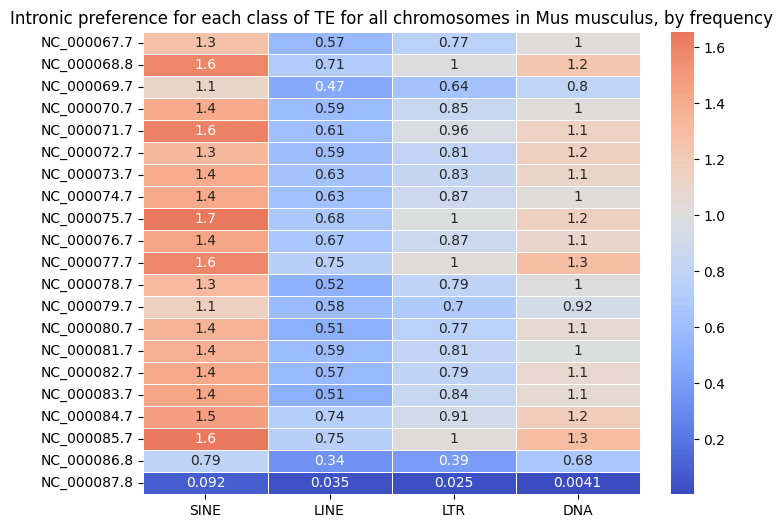

In [154]:
plt.figure(figsize=(8,6))
sns.heatmap(mm_freqs_pref_chr, annot=True, cmap="coolwarm", linewidth=0.5, center=1)
plt.title("Intronic preference for each class of TE for all chromosomes in Mus musculus, by frequency")
plt.show()

Homo sapiens

In [155]:
values_intronic = hs_freqs_per_chr_intronic.values()
keys = hs_freqs_per_chr_intronic.keys()

hs_freqs_intronic_chr = pd.DataFrame(data=values_intronic, index=keys, columns=titles)
print(hs_freqs_intronic_chr)

               SINE    LINE    LTR    DNA
NC_000001.11  84324  132662  68294  35411
NC_000002.12  67515  127860  66183  37612
NC_000003.12  62245  110918  56582  34605
NC_000004.12  45027   89414  49387  24867
NC_000005.10  49502   92709  48949  27430
NC_000006.12  45909   86404  45439  26213
NC_000007.14  45786   83586  44535  23817
NC_000008.11  41194   74874  39622  20530
NC_000009.12  39448   64032  32495  17903
NC_000010.11  43306   71675  38050  21044
NC_000011.10  45451   73212  36079  19194
NC_000012.12  46853   76657  42363  22164
NC_000013.11  20775   42985  22896  12062
NC_000014.9   28587   49552  27310  13733
NC_000015.10  30671   52890  26744  14731
NC_000016.10  34733   43754  28010  12952
NC_000017.11  36620   47793  28905  13089
NC_000018.10  18177   35346  17805  10226
NC_000019.10  27409   33410  26099   6958
NC_000020.11  26773   18893   7034   9398
NC_000021.9    8491   15890  11283   4415
NC_000022.11  17637   21607  13015   5004
NC_000023.11  27986   65063  27204

In [156]:
values_intergenic = hs_freqs_per_chr_intergenic.values()
keys = hs_freqs_per_chr_intergenic.keys()

hs_freqs_intergenic_chr = pd.DataFrame(data=values_intergenic, index=keys, columns=titles)
print(hs_freqs_intergenic_chr)

               SINE    LINE    LTR    DNA
NC_000001.11  49159   93478  61177  21335
NC_000002.12  42433   97910  61858  24729
NC_000003.12  32502   77107  49152  19501
NC_000004.12  31702   84456  57733  19581
NC_000005.10  32109   78432  50404  19137
NC_000006.12  29443   72502  45962  17524
NC_000007.14  30630   65370  44396  14681
NC_000008.11  27836   61169  40156  13915
NC_000009.12  24379   52024  33215  11629
NC_000010.11  26228   52696  33450  12609
NC_000011.10  26402   54865  33118  11891
NC_000012.12  25832   52486  35583  12463
NC_000013.11  16947   45522  30488  10596
NC_000014.9   16769   35624  24353   8597
NC_000015.10  16121   30853  18818   7588
NC_000016.10  22227   32972  24821   8424
NC_000017.11  19680   29603  21942   7137
NC_000018.10  13926   34419  22159   8171
NC_000019.10  15289   22018  19006   3649
NC_000020.11  18396   16195   9866   7240
NC_000021.9    6767   16374  13309   3723
NC_000022.11   9225   13883  10250   2772
NC_000023.11  32776  111450  56457

In [157]:
hs_freqs_pref_chr = hs_freqs_intronic_chr / hs_freqs_intergenic_chr
print(hs_freqs_pref_chr)

                  SINE      LINE       LTR       DNA
NC_000001.11  1.715332  1.419179  1.116335  1.659761
NC_000002.12  1.591097  1.305893  1.069918  1.520967
NC_000003.12  1.915113  1.438495  1.151164  1.774524
NC_000004.12  1.420320  1.058705  0.855438  1.269956
NC_000005.10  1.541686  1.182030  0.971133  1.433349
NC_000006.12  1.559250  1.191746  0.988621  1.495834
NC_000007.14  1.494809  1.278660  1.003131  1.622301
NC_000008.11  1.479882  1.224051  0.986702  1.475386
NC_000009.12  1.618114  1.230817  0.978323  1.539513
NC_000010.11  1.651136  1.360160  1.137519  1.668967
NC_000011.10  1.721498  1.334403  1.089408  1.614162
NC_000012.12  1.813758  1.460523  1.190540  1.778384
NC_000013.11  1.225881  0.944269  0.750984  1.138354
NC_000014.9   1.704753  1.390972  1.121422  1.597418
NC_000015.10  1.902549  1.714258  1.421192  1.941355
NC_000016.10  1.562649  1.327005  1.128480  1.537512
NC_000017.11  1.860772  1.614465  1.317337  1.833964
NC_000018.10  1.305256  1.026933  0.803511  1.

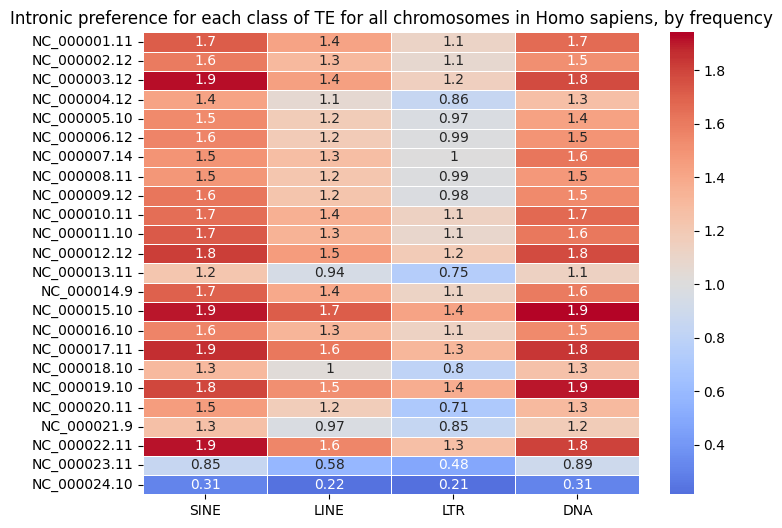

In [158]:
plt.figure(figsize=(8,6))
sns.heatmap(hs_freqs_pref_chr, annot=True, cmap="coolwarm", linewidth=0.5, center=1)
plt.title("Intronic preference for each class of TE for all chromosomes in Homo sapiens, by frequency")
plt.show()

Arabidopsis thaliana

In [159]:
values_intronic = at_freqs_per_chr_intronic.values()
keys = at_freqs_per_chr_intronic.keys()

at_freqs_intronic_chr = pd.DataFrame(data=values_intronic, index=keys, columns=titles)
print(at_freqs_intronic_chr)

             SINE  LINE  LTR  DNA
NC_003070.9     0    17   36   17
NC_003071.7     0    16   25    7
NC_003074.8     0     9   15   13
NC_003075.7     0    16   21    8
NC_003076.8     0    15   17    7
NC_037304.1     0     0    9    0
NC_000932.1     0     0    0    0


In [160]:
values_intergenic = at_freqs_per_chr_intergenic.values()
keys = at_freqs_per_chr_intergenic.keys()

at_freqs_intergenic_chr = pd.DataFrame(data=values_intergenic, index=keys, columns=titles)
print(at_freqs_intergenic_chr)

             SINE  LINE   LTR  DNA
NC_003070.9     0   277  1291  664
NC_003071.7     0   380  1356  824
NC_003074.8     0   296  1572  794
NC_003075.7     0   206  1332  625
NC_003076.8     0   325  1442  675
NC_037304.1     0     2    48    0
NC_000932.1     0     0     0    0


In [161]:
at_freqs_pref_chr = at_freqs_intronic_chr / at_freqs_intergenic_chr
at_freqs_pref_chr.replace([np.inf, -np.inf], 100, inplace=True)
print(at_freqs_pref_chr)

             SINE      LINE       LTR       DNA
NC_003070.9   NaN  0.061372  0.027885  0.025602
NC_003071.7   NaN  0.042105  0.018437  0.008495
NC_003074.8   NaN  0.030405  0.009542  0.016373
NC_003075.7   NaN  0.077670  0.015766  0.012800
NC_003076.8   NaN  0.046154  0.011789  0.010370
NC_037304.1   NaN  0.000000  0.187500       NaN
NC_000932.1   NaN       NaN       NaN       NaN


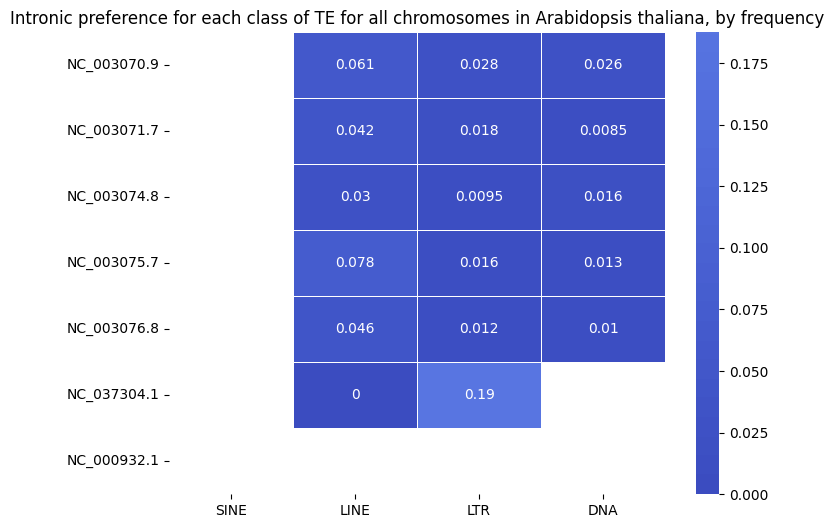

In [162]:
plt.figure(figsize=(8,6))
sns.heatmap(at_freqs_pref_chr, annot=True, cmap="coolwarm", linewidth=0.5, center=1)
plt.title("Intronic preference for each class of TE for all chromosomes in Arabidopsis thaliana, by frequency")
plt.show()

Drosophila melanogaster

In [163]:
values_intronic = dm_freqs_per_chr_intronic.values()
keys = dm_freqs_per_chr_intronic.keys()

dm_freqs_intronic_chr = pd.DataFrame(data=values_intronic, index=keys, columns=titles)
print(dm_freqs_intronic_chr)

             SINE  LINE   LTR   DNA
NC_004354.4     0    82   411   472
NT_033779.5     0   165   321   513
NT_033778.4     0   696  1265  1045
NT_037436.4     0   578  1105   846
NT_033777.3     0   937  2020   837
NC_004353.4     0    51    39   520
NC_024512.1     0   225   695   133


In [164]:
values_intergenic = dm_freqs_per_chr_intergenic.values()
keys = dm_freqs_per_chr_intergenic.keys()

dm_freqs_intergenic_chr = pd.DataFrame(data=values_intergenic, index=keys, columns=titles)
print(dm_freqs_intergenic_chr)

             SINE  LINE   LTR   DNA
NC_004354.4     0   494   784   492
NT_033779.5     0   286   979   656
NT_033778.4     0   994  2134  1150
NT_037436.4     0   948  2124   942
NT_033777.3     0   278   881   428
NC_004353.4     0    76    15   186
NC_024512.1     0   594  1486   333


In [165]:
dm_freqs_pref_chr = dm_freqs_intronic_chr / dm_freqs_intergenic_chr
print(dm_freqs_pref_chr)

             SINE      LINE       LTR       DNA
NC_004354.4   NaN  0.165992  0.524235  0.959350
NT_033779.5   NaN  0.576923  0.327886  0.782012
NT_033778.4   NaN  0.700201  0.592784  0.908696
NT_037436.4   NaN  0.609705  0.520245  0.898089
NT_033777.3   NaN  3.370504  2.292849  1.955607
NC_004353.4   NaN  0.671053  2.600000  2.795699
NC_024512.1   NaN  0.378788  0.467699  0.399399


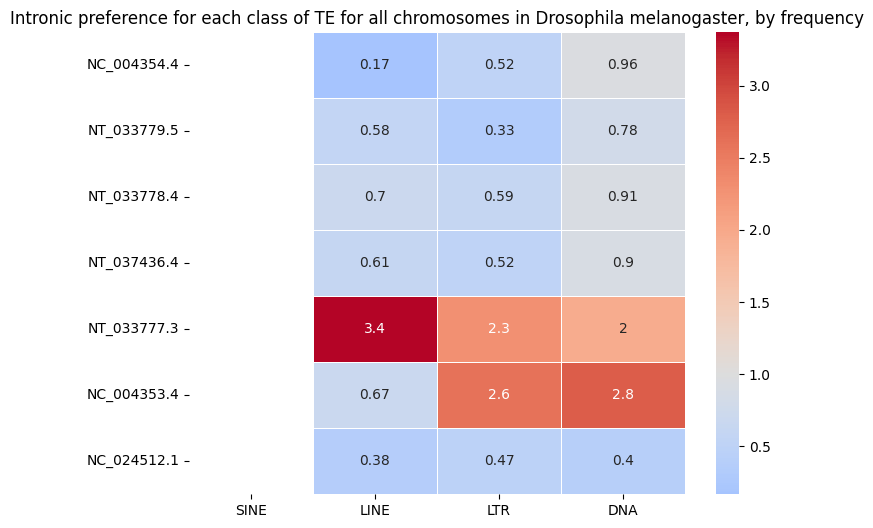

In [166]:
plt.figure(figsize=(8,6))
sns.heatmap(dm_freqs_pref_chr, annot=True, cmap="coolwarm", linewidth=0.5, center=1)
plt.title("Intronic preference for each class of TE for all chromosomes in Drosophila melanogaster, by frequency")
plt.show()

Caenorhabditis elegans

In [167]:
values_intronic = ce_freqs_per_chr_intronic.values()
keys = ce_freqs_per_chr_intronic.keys()

ce_freqs_intronic_chr = pd.DataFrame(data=values_intronic, index=keys, columns=titles)
print(ce_freqs_intronic_chr)

              SINE  LINE  LTR   DNA
NC_003279.8     30    33   17  3615
NC_003280.10    15    11    7  2346
NC_003281.10    10    22    9  3072
NC_003282.8     21    24   21  2436
NC_003283.11    41    29   15  3351
NC_003284.9    109    30   11  1735


In [168]:
values_intergenic = ce_freqs_per_chr_intergenic.values()
keys = ce_freqs_per_chr_intergenic.keys()

ce_freqs_intergenic_chr = pd.DataFrame(data=values_intergenic, index=keys, columns=titles)
print(ce_freqs_intergenic_chr)

              SINE  LINE  LTR   DNA
NC_003279.8     18    47   37  2020
NC_003280.10    18    56   43  2043
NC_003281.10    13    33   25  1743
NC_003282.8     23    76   41  2143
NC_003283.11    48   112   99  3080
NC_003284.9     90    82  117  1959


In [169]:
ce_freqs_pref_chr = ce_freqs_intronic_chr / ce_freqs_intergenic_chr
print(ce_freqs_pref_chr)

                  SINE      LINE       LTR       DNA
NC_003279.8   1.666667  0.702128  0.459459  1.789604
NC_003280.10  0.833333  0.196429  0.162791  1.148311
NC_003281.10  0.769231  0.666667  0.360000  1.762478
NC_003282.8   0.913043  0.315789  0.512195  1.136724
NC_003283.11  0.854167  0.258929  0.151515  1.087987
NC_003284.9   1.211111  0.365854  0.094017  0.885656


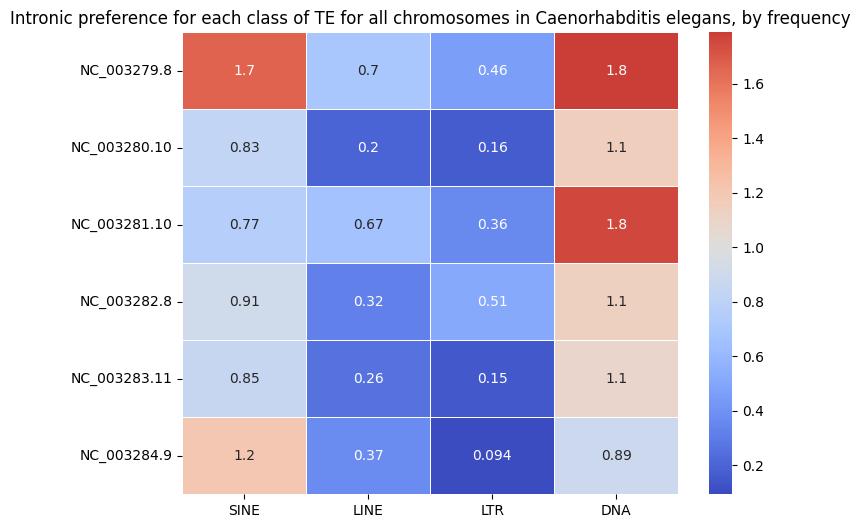

In [170]:
plt.figure(figsize=(8,6))
sns.heatmap(ce_freqs_pref_chr, annot=True, cmap="coolwarm", linewidth=0.5, center=1)
plt.title("Intronic preference for each class of TE for all chromosomes in Caenorhabditis elegans, by frequency")
plt.show()

In [171]:
all_df

SINE_intronic_length  LINE_intronic_length  LTR_intronic_length  \
MM            134.700456            367.034920           174.164810   
HS            209.029623            252.580837           239.123215   
AT              0.000000            127.232877           167.601626   
DM              0.000000            796.979592           906.991996   
CE            168.327434            520.691275           445.862500   

    DNA_intronic_length  SINE_intergenic_length  LINE_intergenic_length  \
MM           170.347560              156.795470              508.344587   
HS           166.090588              259.025968              314.774439   
AT           267.365385                0.000000              611.880888   
DM           288.522176                0.000000              824.126984   
CE           218.935065              168.000000              679.926108   

    LTR_intergenic_length  DNA_intergenic_length  SINE_intronic_freq  \
MM             246.932764             249.670366              838064   
HS             267.982478             205.240022              965418   
AT            1018.746201             662.192630                   0   
DM             774.636489             331.319635                   0   
CE             577.660221             235.194641                 226   

    LINE_intronic_freq  ...  LTR_intergenic_freq  DNA_intergenic_freq  \
MM              421361  ...              1386664               105326   
HS             1562484  ...               924555               311597   
AT                  73  ...                 7041                 3582   
DM                2744  ...                11642                 4599   
CE                 149  ...                  362                12988   

    SINE_occ_intronic  LINE_occ_intronic  LTR_occ_intronic  DNA_occ_intronic  \
MM           0.097778           0.133954          0.162772          0.015660   
HS           0.119947           0.234575          0.117405          0.044402   
AT           0.000000           0.000506          0.001123          0.000758   
DM           0.000000           0.035581          0.086652          0.020533   
CE           0.001157           0.002359          0.001085          0.110203   

    SINE_occ_intergenic  LINE_occ_intergenic  LTR_occ_intergenic  \
MM             0.062537             0.250585            0.218251   
HS             0.052980             0.145886            0.080227   
AT             0.000000             0.007598            0.059940   
DM             0.000000             0.029816            0.065556   
CE             0.000352             0.002753            0.002085   

    DNA_occ_intergenic  
MM            0.016761  
HS            0.020708  
AT            0.019821  
DM            0.011076  
CE            0.030460  

[5 rows x 24 columns]

In [172]:
mm_ilen_normalized = min_max_normalize(mm_intronic_lengths)
mm_igeniclen_normalized = min_max_normalize(mm_intergenic_lengths)
mm_ifreqs = min_max_normalize(mm_intronic_freqs)
mm_igenicfreqs = min_max_normalize(mm_intergenic_freqs)

In [173]:
hs_ilen_normalized = min_max_normalize(hs_intronic_lengths)
hs_igeniclen_normalized = min_max_normalize(hs_intergenic_lengths)
hs_ifreqs = min_max_normalize(hs_intronic_freqs)
hs_igenicfreqs = min_max_normalize(hs_intergenic_freqs)

In [174]:
at_ilen_normalized = min_max_normalize(at_intronic_lengths)
at_igeniclen_normalized = min_max_normalize(at_intergenic_lengths)
at_ifreqs = min_max_normalize(at_intronic_freqs)
at_igenicfreqs = min_max_normalize(at_intergenic_freqs)

In [175]:
dm_ilen_normalized = min_max_normalize(dm_intronic_lengths)
dm_igeniclen_normalized = min_max_normalize(dm_intergenic_lengths)
dm_ifreqs = min_max_normalize(dm_intronic_freqs)
dm_igenicfreqs = min_max_normalize(dm_intergenic_freqs)

In [176]:
ce_ilen_normalized = min_max_normalize(ce_intronic_lengths)
ce_igeniclen_normalized = min_max_normalize(ce_intergenic_lengths)
ce_ifreqs = min_max_normalize(ce_intronic_freqs)
ce_igenicfreqs = min_max_normalize(ce_intergenic_freqs)

In [177]:
for_mm = mm_ilen_normalized + mm_igeniclen_normalized + mm_ifreqs + mm_igenicfreqs + mm_occs_intronic + mm_occs_intergenic
for_hs = hs_ilen_normalized + hs_igeniclen_normalized + hs_ifreqs + mm_igenicfreqs + hs_occs_intronic + hs_occs_intergenic
for_at = at_ilen_normalized + at_igeniclen_normalized + at_ifreqs + at_igenicfreqs + at_occs_intronic + at_occs_intergenic
for_dm = dm_ilen_normalized + dm_igeniclen_normalized + dm_ifreqs + dm_igenicfreqs + dm_occs_intronic + dm_occs_intergenic
for_ce = ce_ilen_normalized + ce_igeniclen_normalized + ce_ifreqs + ce_igenicfreqs + ce_occs_intronic + ce_occs_intergenic

columns = ['SINE_intronic_length', 'LINE_intronic_length', 'LTR_intronic_length', 'DNA_intronic_length',
            'SINE_intergenic_length', 'LINE_intergenic_length', 'LTR_intergenic_length', 'DNA_intergenic_length',
            'SINE_intronic_freq', 'LINE_intronic_freq', 'LTR_intronic_freq', 'DNA_intronic_freq',
            'SINE_intergenic_freq', 'LINE_intergenic_freq', 'LTR_intergenic_freq', 'DNA_intergenic_freq',
            'SINE_occ_intronic', 'LINE_occ_intronic', 'LTR_occ_intronic', 'DNA_occ_intronic',
            'SINE_occ_intergenic', 'LINE_occ_intergenic', 'LTR_occ_intergenic', 'DNA_occ_intergenic',]

data = [for_mm, for_hs, for_at, for_dm, for_ce]
organism_names = ["MM", "HS", "AT", "DM", "CE"]
all_normalized_df = pd.DataFrame(data=data, columns=columns, index=organism_names)

print(all_normalized_df)

    SINE_intronic_length  LINE_intronic_length  LTR_intronic_length  \
MM              0.000000              1.000000             0.169860   
HS              0.496461              1.000000             0.844403   
AT              0.000000              0.475876             0.626864   
DM              0.000000              0.878706             1.000000   
CE              0.000000              1.000000             0.787638   

    DNA_intronic_length  SINE_intergenic_length  LINE_intergenic_length  \
MM             0.153430                0.000000                1.000000   
HS             0.000000                0.491042                1.000000   
AT             1.000000                0.000000                0.600622   
DM             0.318109                0.000000                1.000000   
CE             0.143623                0.000000                1.000000   

    LTR_intergenic_length  DNA_intergenic_length  SINE_intronic_freq  \
MM               0.256400               0.264188  

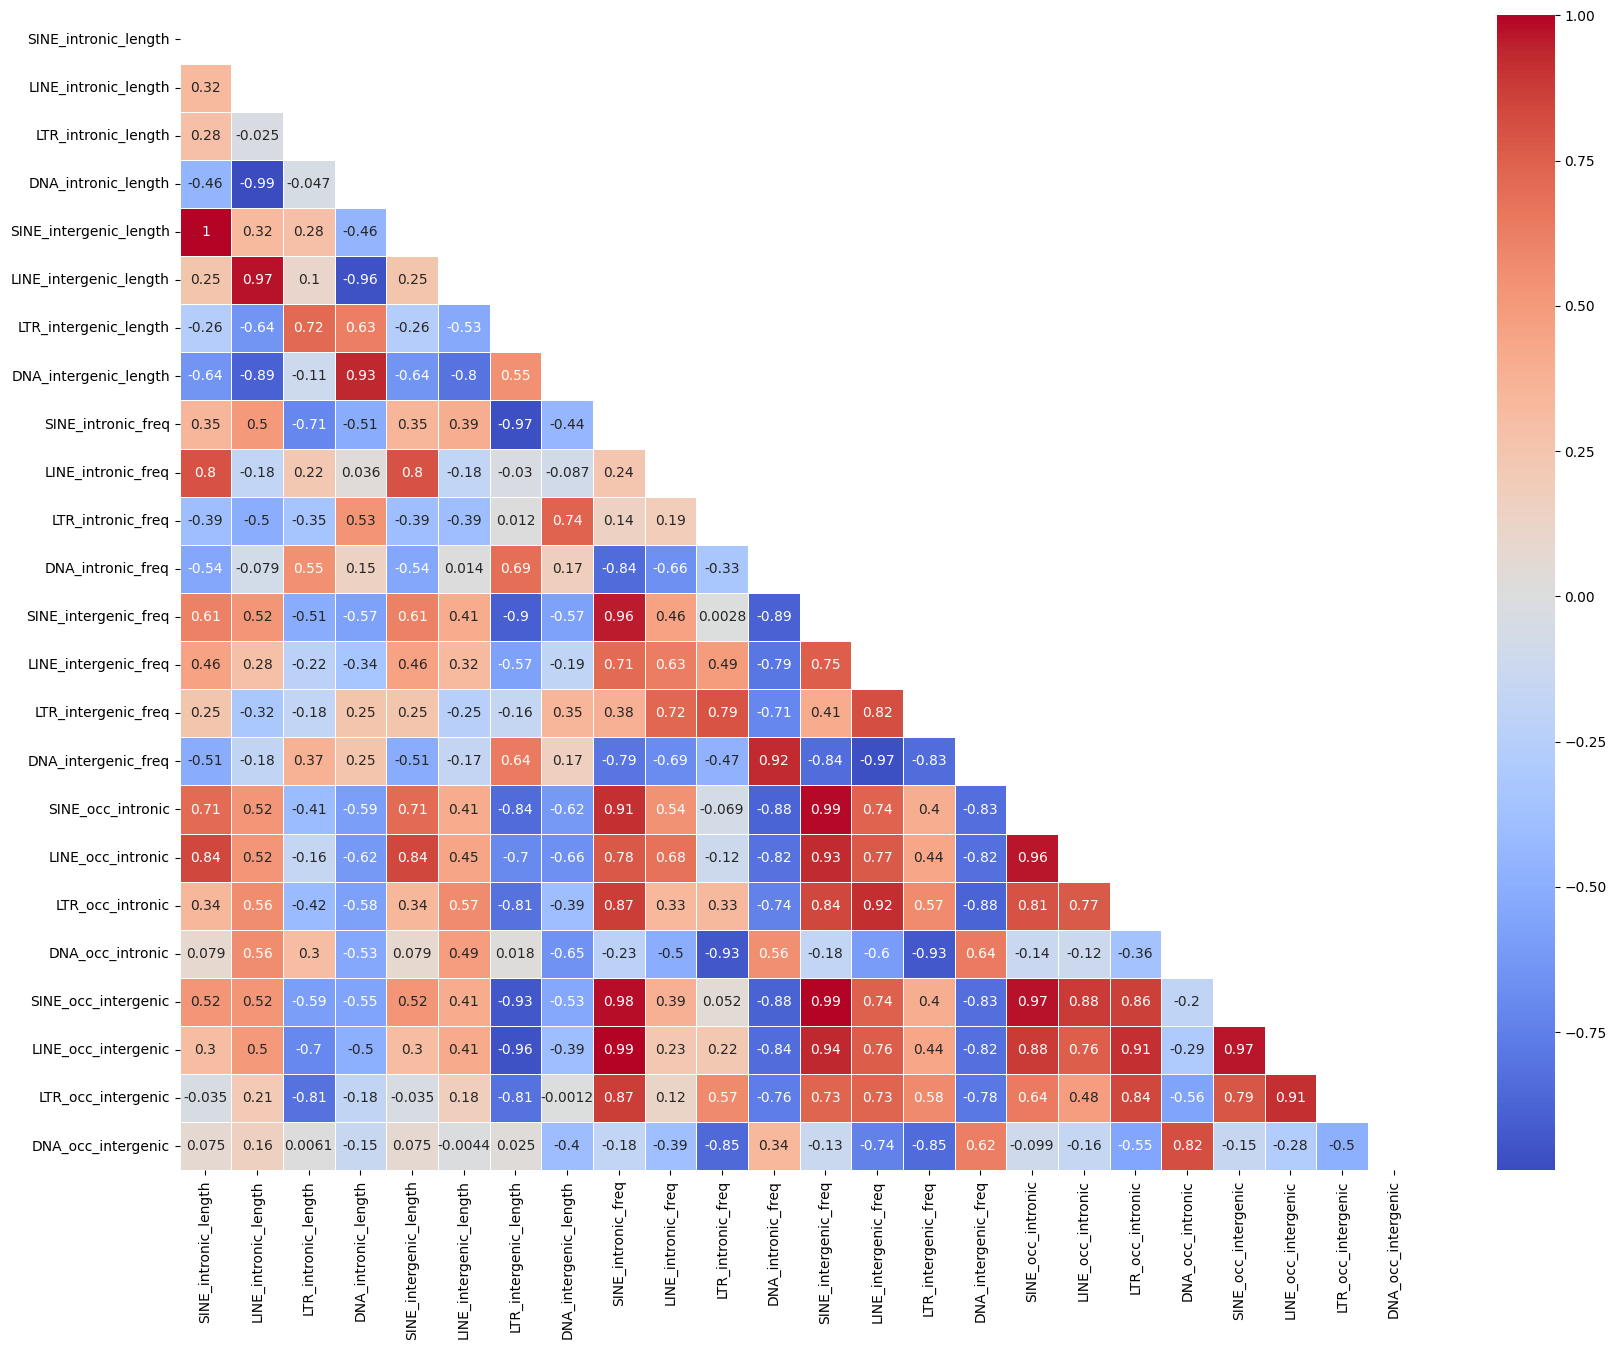

In [178]:
corr_matrix = all_normalized_df.corr()

plt.figure(figsize=(20, 15))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, mask=mask)

plt.show()

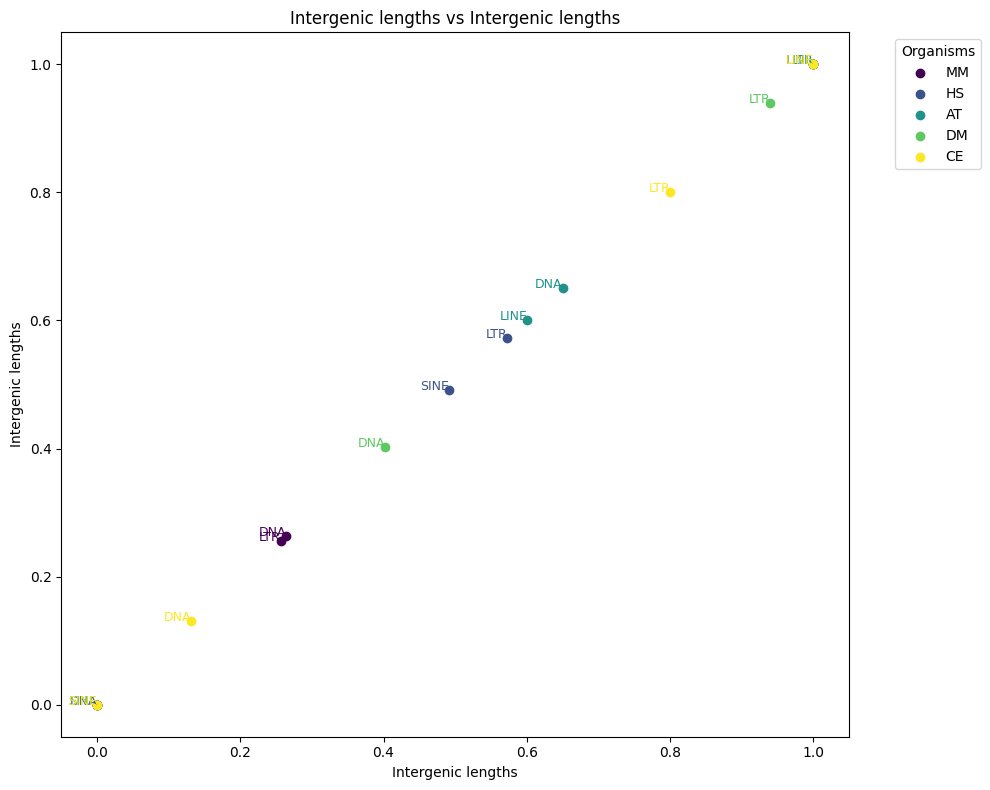

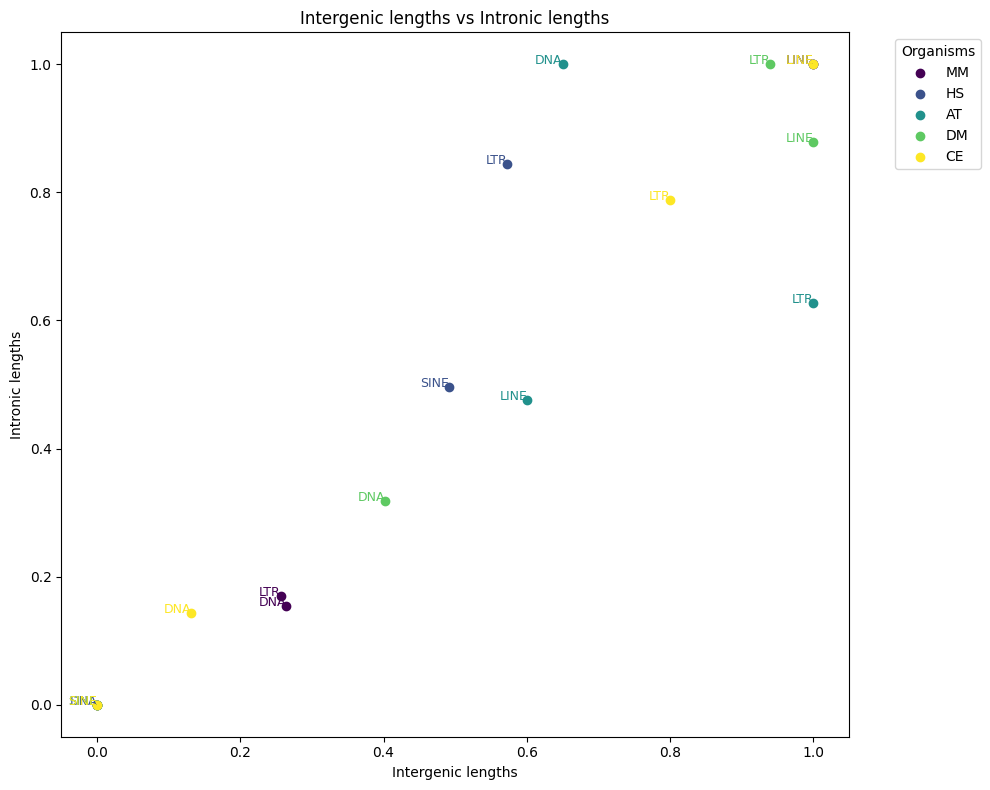

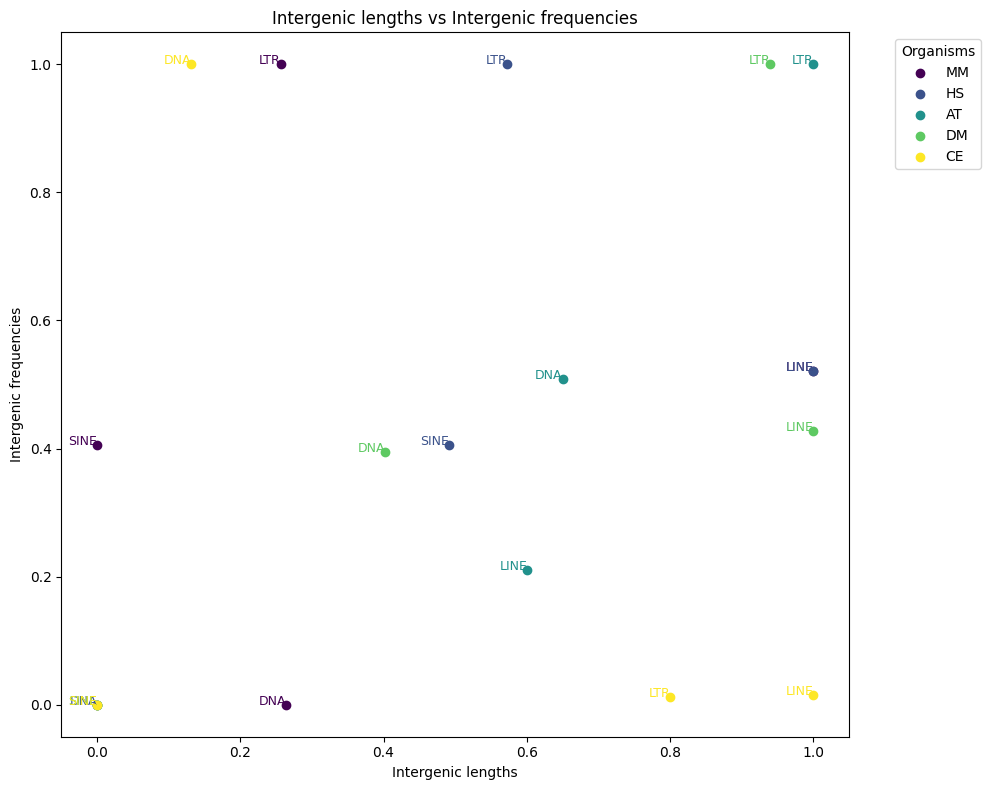

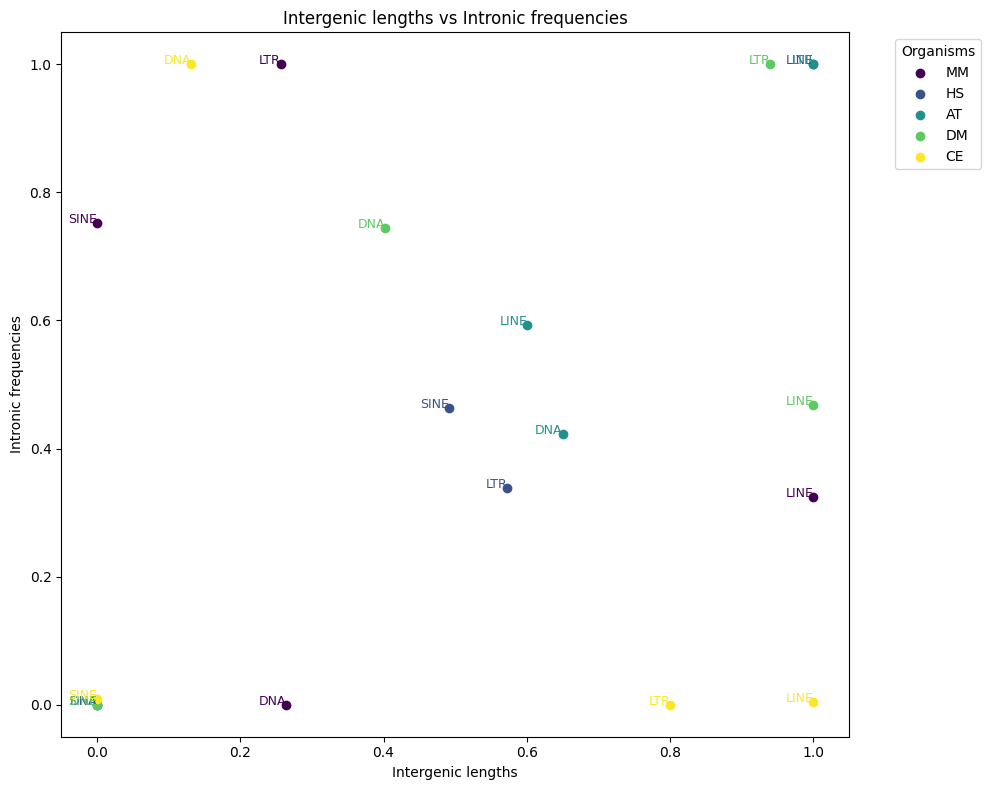

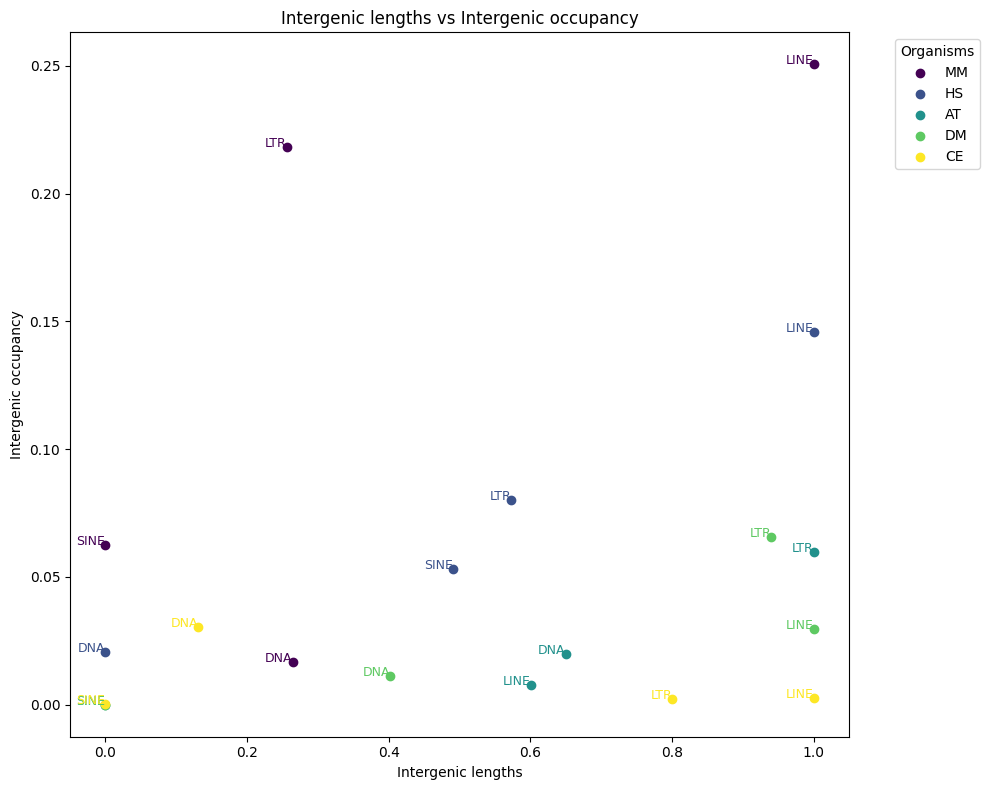

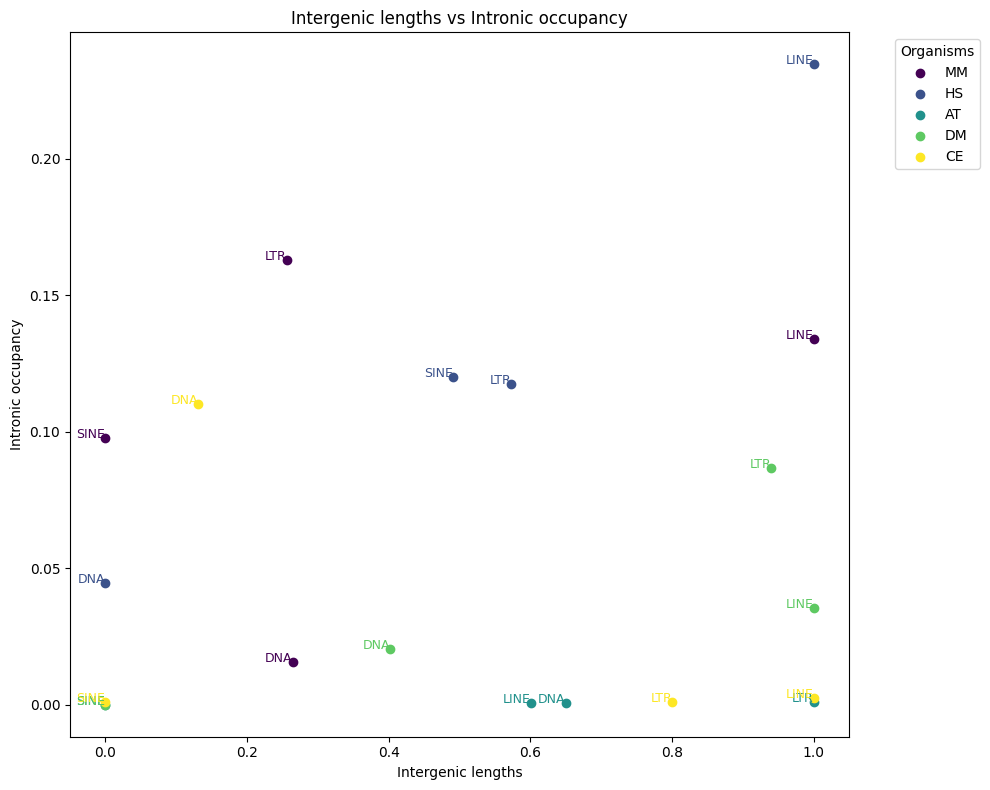

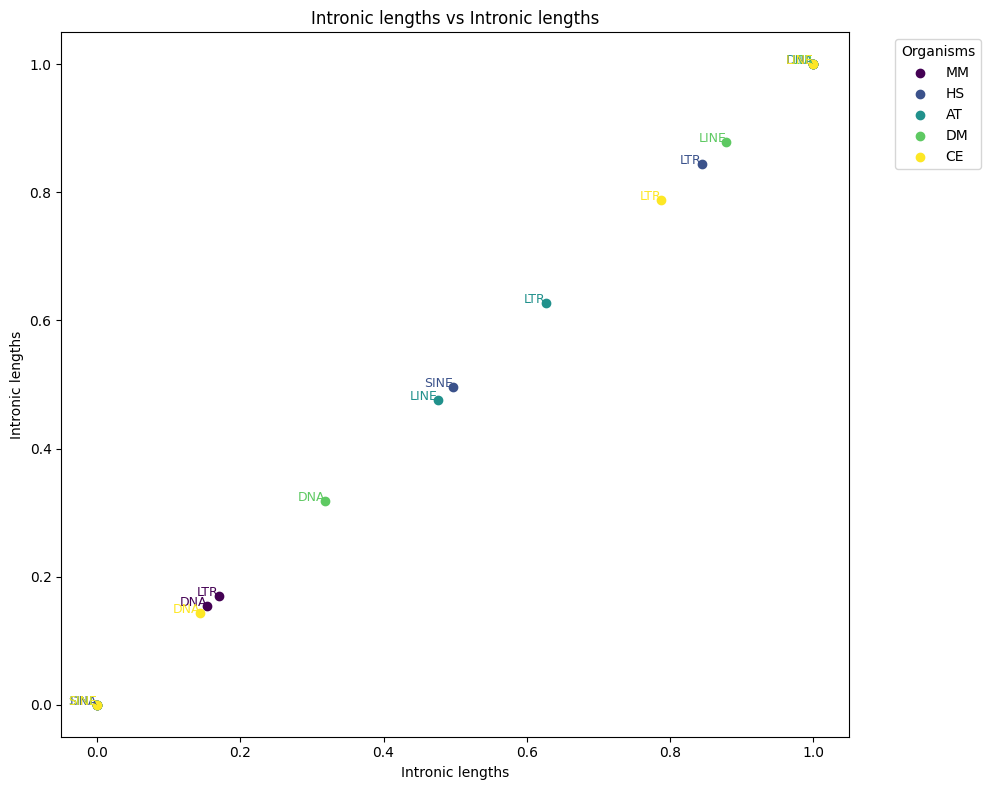

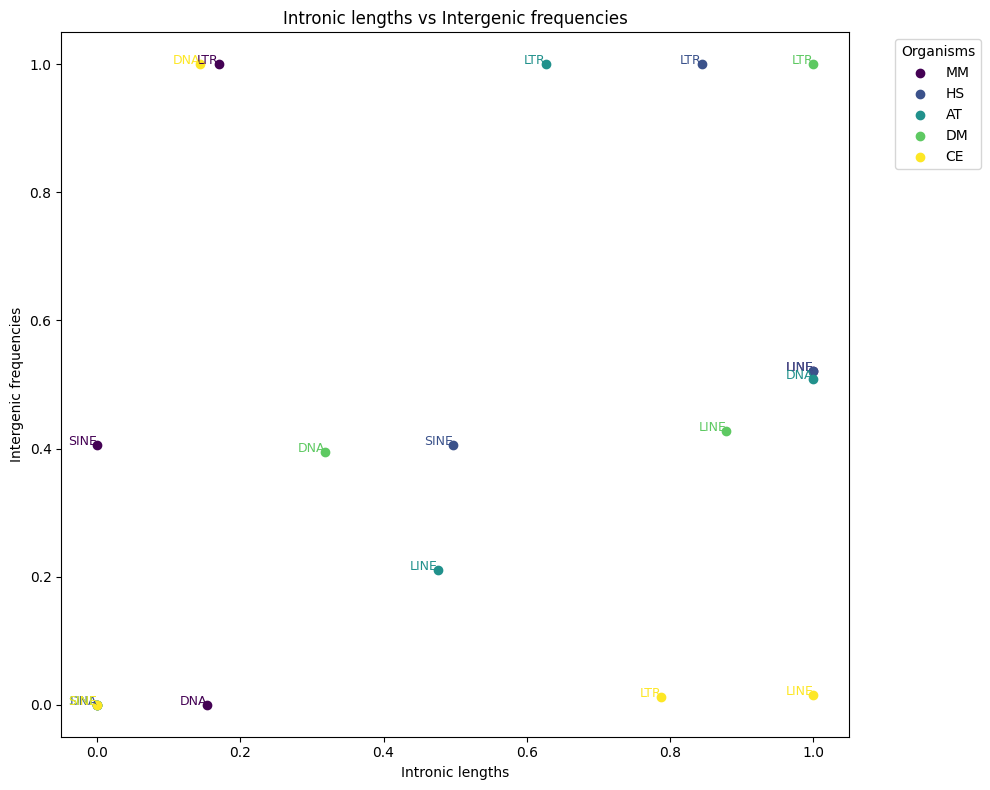

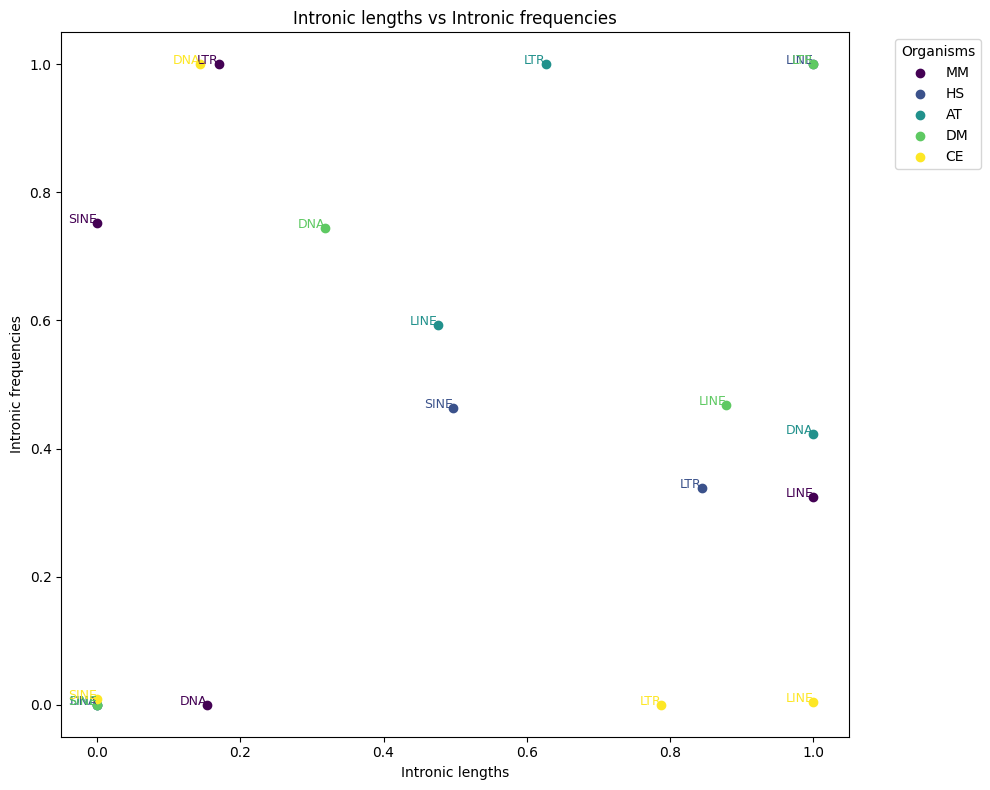

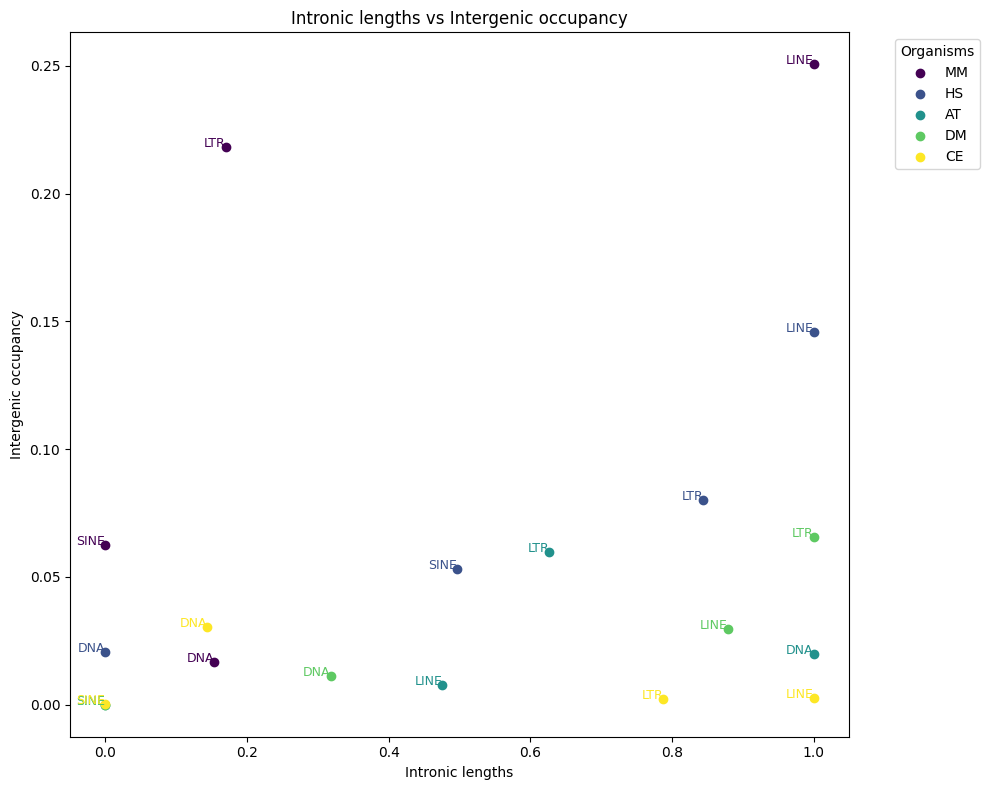

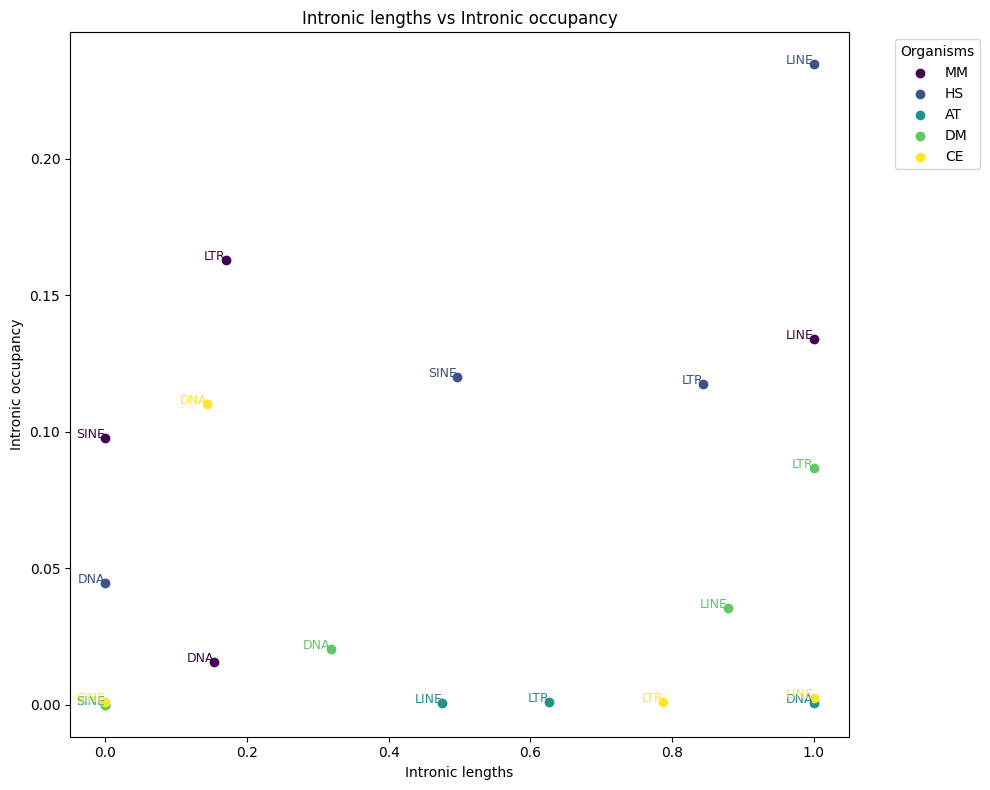

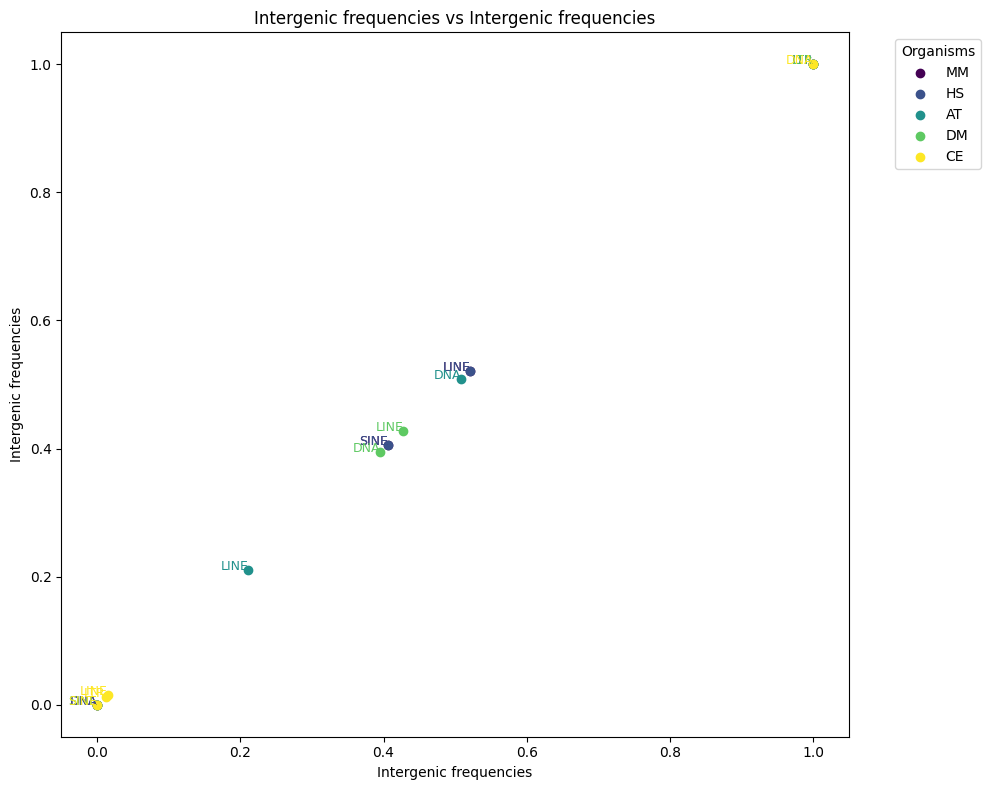

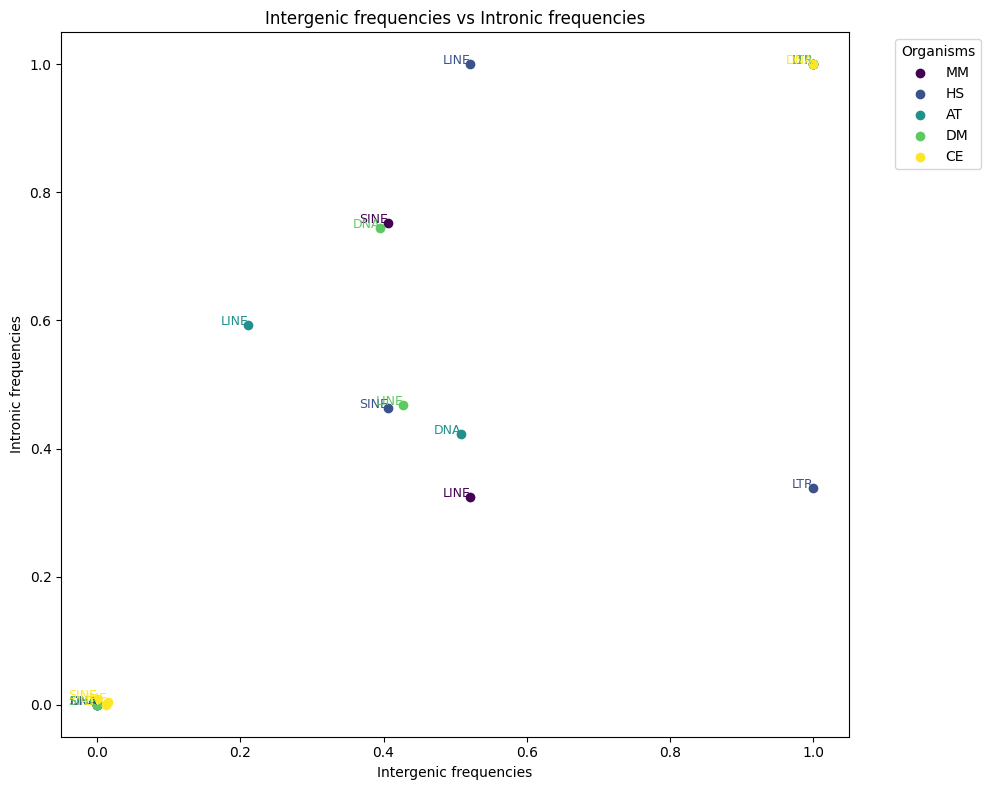

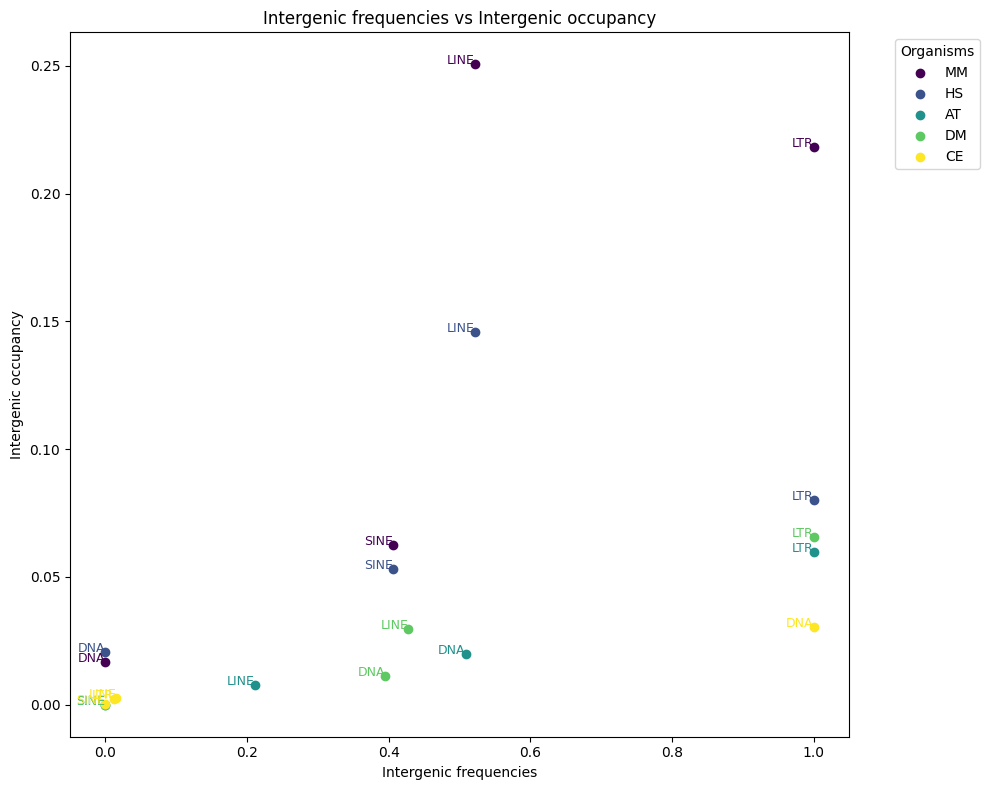

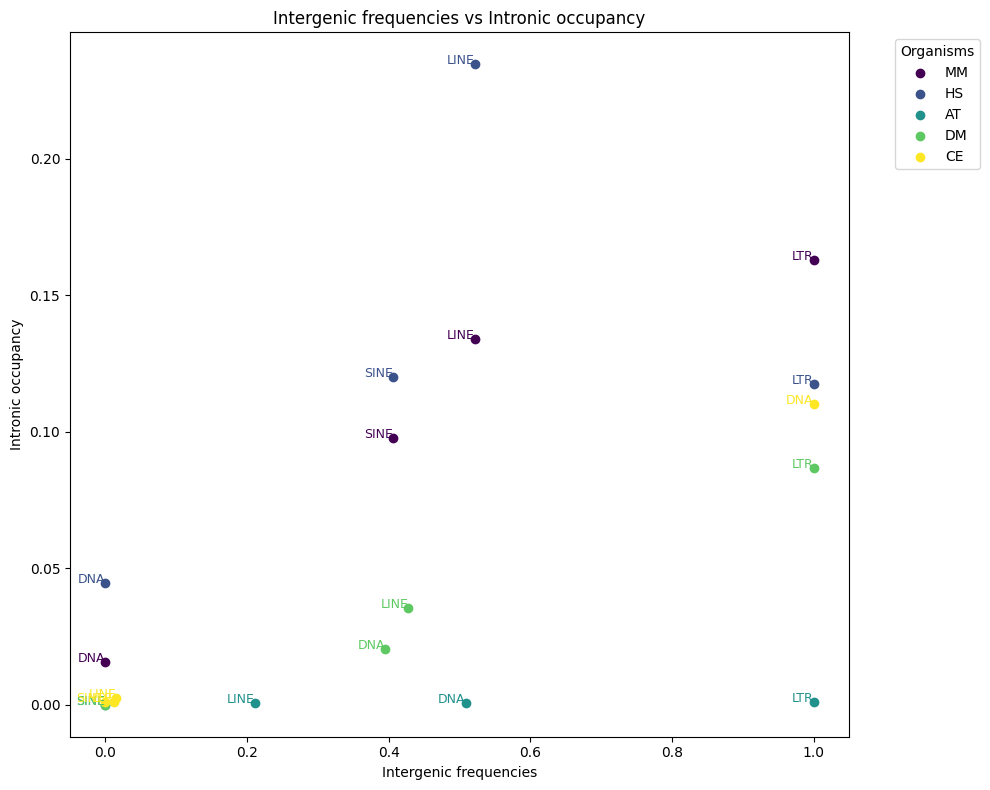

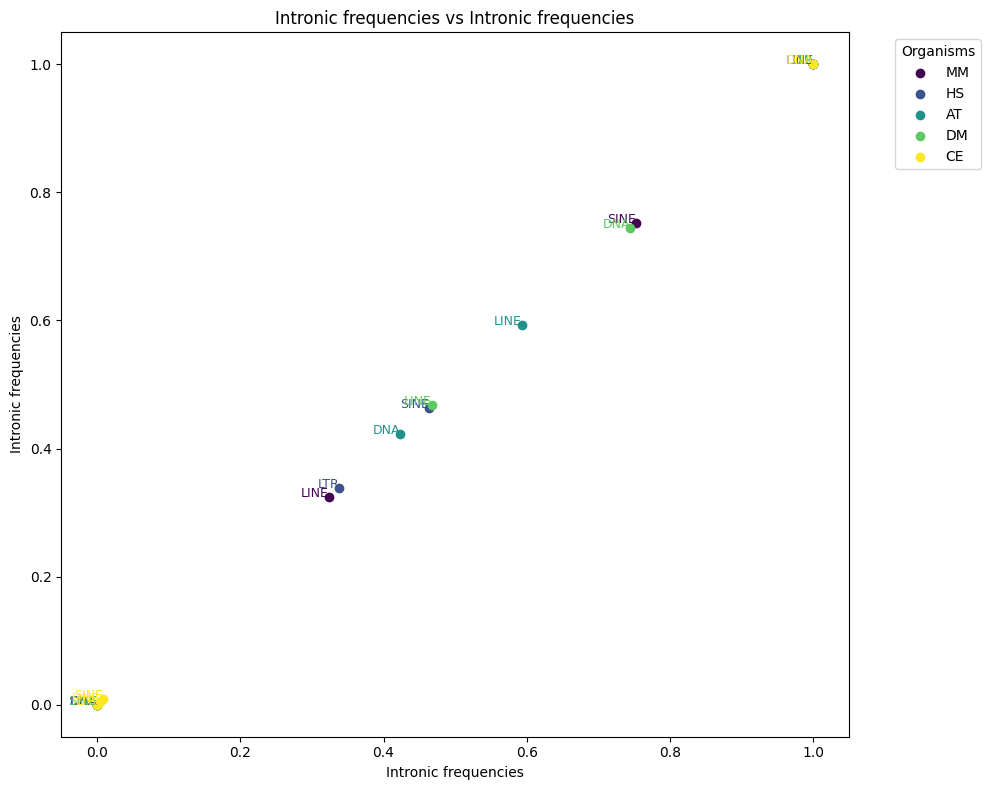

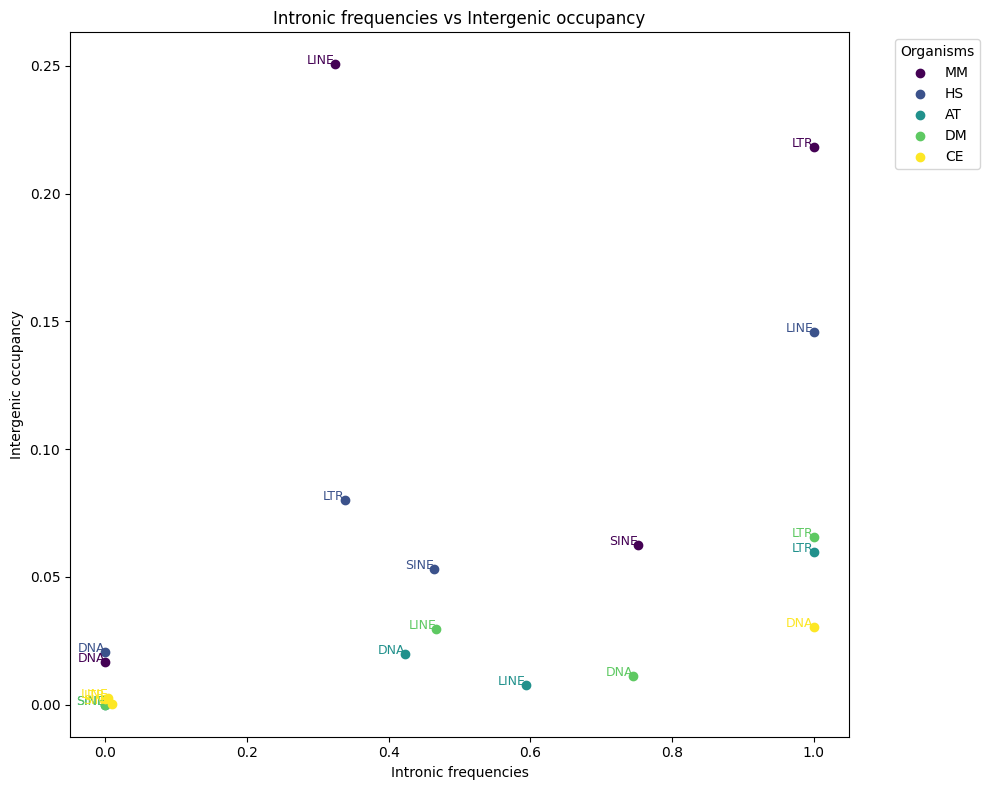

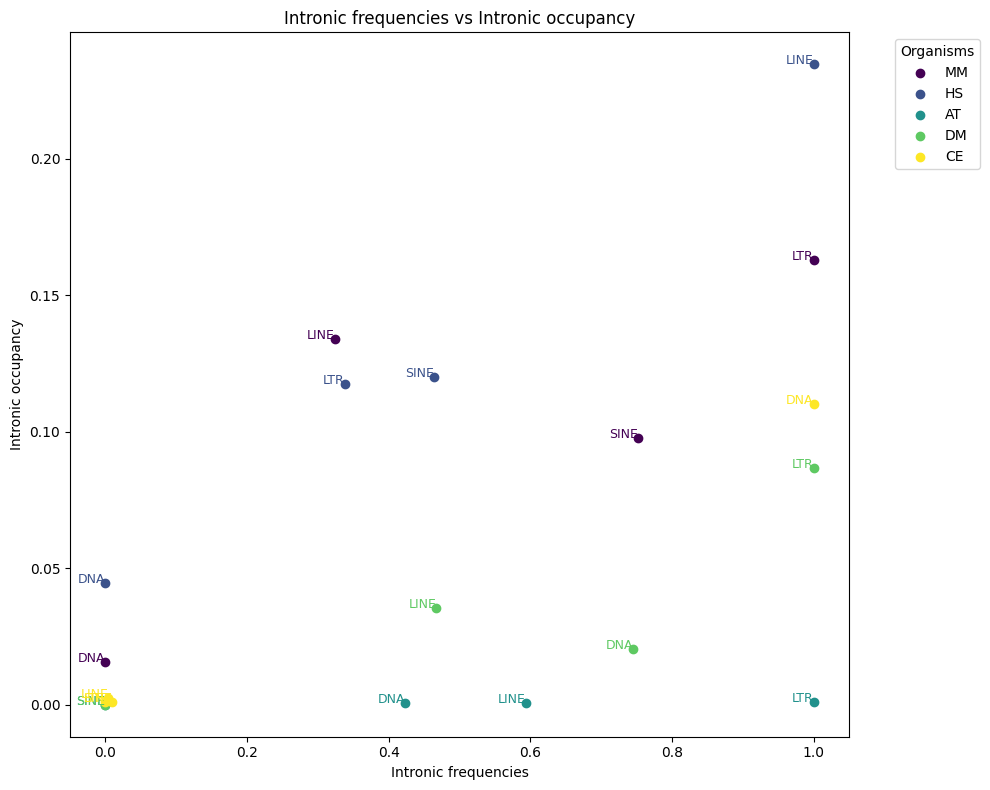

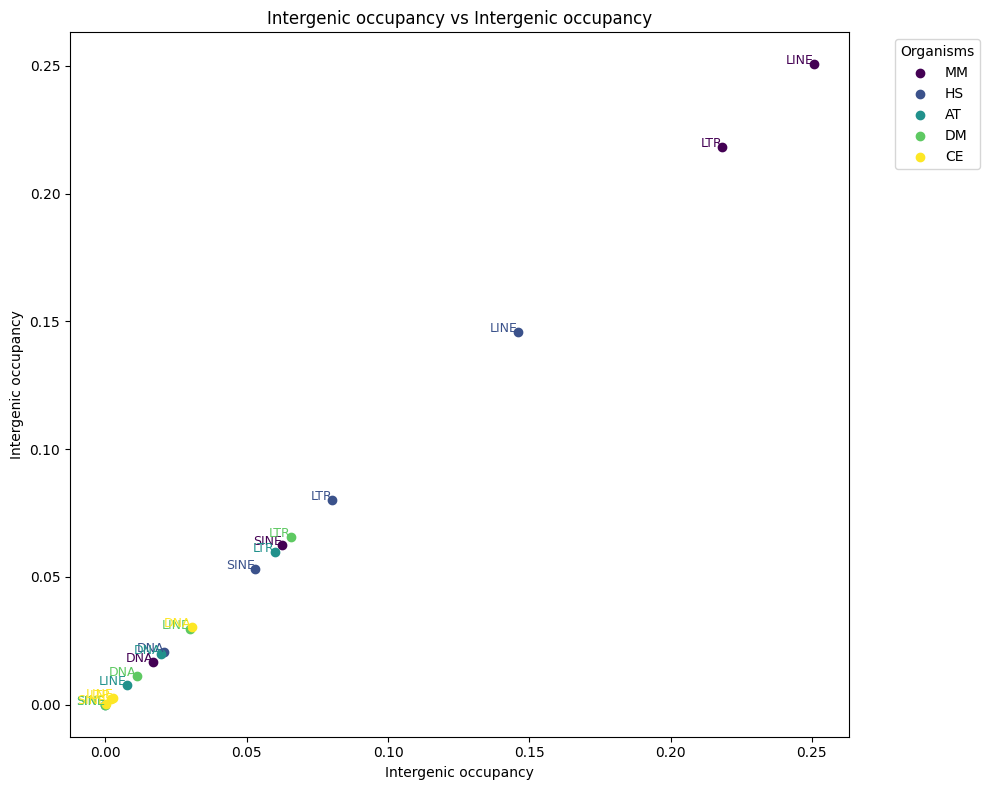

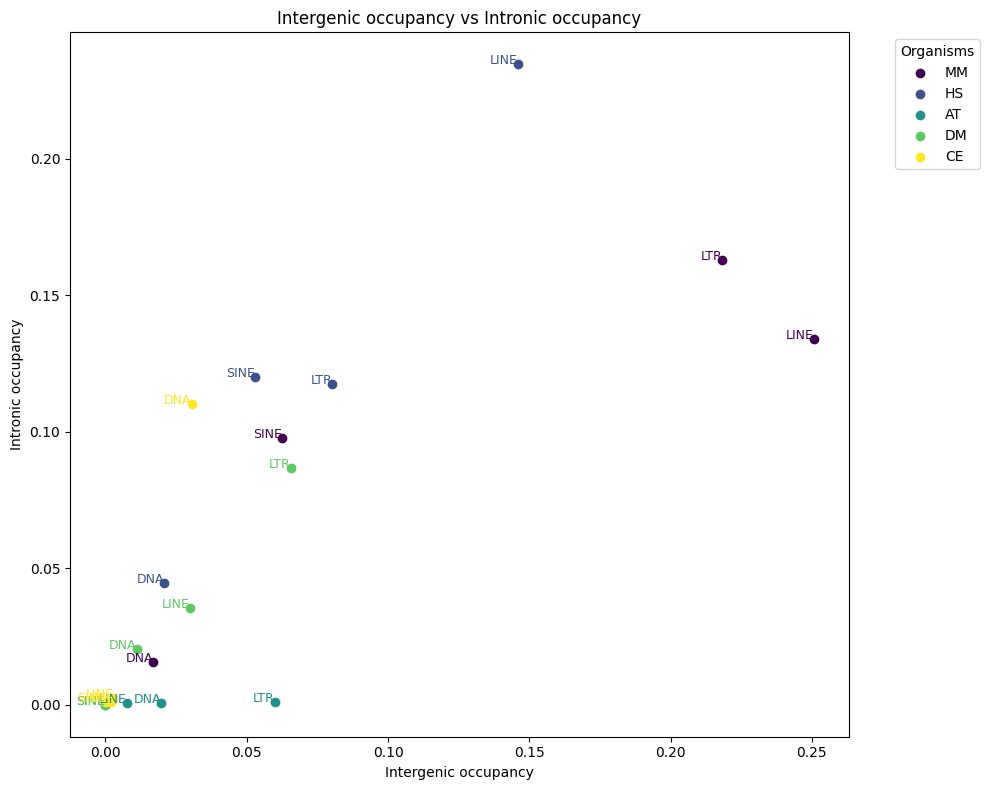

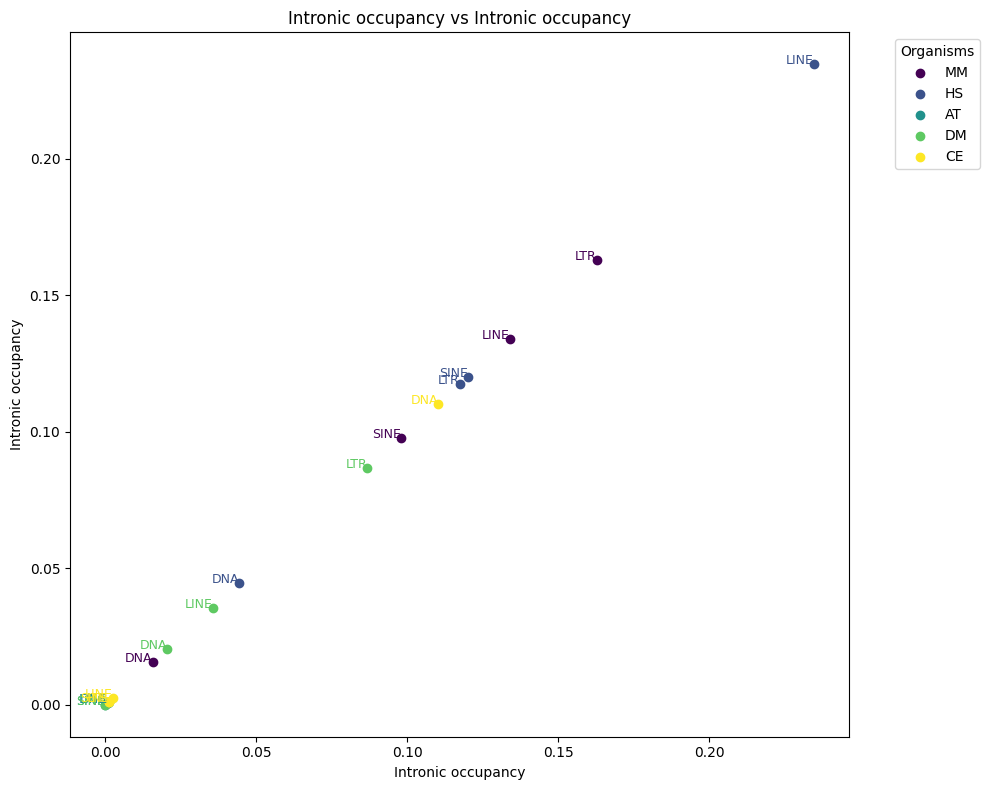

In [179]:
# Groups of columns
groups = {
    'Intergenic lengths': [
        'SINE_intergenic_length', 'LINE_intergenic_length', 'LTR_intergenic_length', 
        'DNA_intergenic_length',
    ],
    'Intronic lengths': [
        'SINE_intronic_length', 'LINE_intronic_length', 'LTR_intronic_length', 
        'DNA_intronic_length',
    ],
    'Intergenic frequencies': [
        'SINE_intergenic_freq', 'LINE_intergenic_freq', 'LTR_intergenic_freq', 
        'DNA_intergenic_freq',
    ],
    'Intronic frequencies': [
        'SINE_intronic_freq', 'LINE_intronic_freq', 'LTR_intronic_freq', 
        'DNA_intronic_freq',
    ],
    'Intergenic occupancy': [
        'SINE_occ_intergenic', 'LINE_occ_intergenic', 'LTR_occ_intergenic', 
        'DNA_occ_intergenic',
    ],
    'Intronic occupancy': [
        'SINE_occ_intronic', 'LINE_occ_intronic', 'LTR_occ_intronic', 
        'DNA_occ_intronic',
    ]
}

# Organism names and colors
organisms = all_normalized_df.index
colors = plt.cm.viridis(np.linspace(0, 1, len(organisms)))

# Plot combinations of the groups
group_names = list(groups.keys())
plot_count = 0
for i, group_x in enumerate(group_names):
    for j, group_y in enumerate(group_names):
        if i <= j:  # Avoid plotting the same pair twice or diagonal plots
            plot_count += 1
            plt.figure(figsize=(10, 8))
            
            for org, color in zip(organisms, colors):
                X = all_normalized_df.loc[org, groups[group_x]]
                Y = all_normalized_df.loc[org, groups[group_y]]
                
                # Label points with the element type (SINE, LINE, etc.)
                labels = ["SINE", "LINE", "LTR", "DNA",]
                for x, y, label in zip(X, Y, labels):
                    plt.scatter(x, y, color=color)
                    plt.text(x, y, label, fontsize=9, ha='right', color=color)

            # Create a legend
            for org, color in zip(organisms, colors):
                plt.scatter([], [], color=color, label=org)  # Empty scatter just to show legend

            plt.legend(title='Organisms', bbox_to_anchor=(1.05, 1), loc='upper left')

            plt.title(f'{group_x} vs {group_y}')
            plt.xlabel(group_x)
            plt.ylabel(group_y)
            plt.tight_layout()
            plt.show()